![Icon_Image](https://image.flaticon.com/icons/png/512/2959/2959609.png)
<h1><b>4Intelligence test case by Pedro Henrique Franco Fratucci</b></h1>

# <font color=green size= 6> <b>1. IMPORTS </font></b>
***


## <font color=green size= 5>1.1 LIBRARIES </font>
***

In [1]:
import inflection
import json
import pickle
import random
import requests
import warnings
import random
import datetime

import pandas                       as pd
import numpy                        as np
import matplotlib.pyplot            as plt
import seaborn                      as sns
import xgboost                      as xgb

from catboost                       import CatBoostRegressor
from scipy.stats                    import randint
from boruta                         import BorutaPy
from IPython.display                import Image
from sklearn.metrics                import mean_absolute_error, mean_squared_error
from sklearn.ensemble               import RandomForestRegressor
from sklearn.linear_model           import LinearRegression, Lasso
from sklearn.preprocessing          import MinMaxScaler
from scipy.stats                    import chi2_contingency
from category_encoders              import OneHotEncoder
from dateutil.relativedelta         import relativedelta
from sklearn.feature_selection      import RFE
%matplotlib inline

# hiding warning messages
warnings.filterwarnings('ignore')

## <font color=green size= 5>1.2 HELPER FUNCTIONS </font>
***

In [2]:
# creating a function that calcultes the correlation between categorical features
def cramer_v(var_x, var_y):
    
    # building a contigency matrix (or confusion matrix)
    confusion_matrix = pd.crosstab(var_x, var_y).values
    
    # getting the sum of all values in the matrix
    n = confusion_matrix.sum()
    
    # getting the rows, cols
    r, k = confusion_matrix.shape
    
    # getting the chi-squared
    chi2 = chi2_contingency(confusion_matrix)[0]
    
    # making the bias correction
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    kcorr = k - (k-1) ** 2 / (n-1)
    rcorr = r - (r-1) ** 2 / (n-1)
    
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))
   
    
    
# creating a function that calculates the mean absolute percentage error
def mean_absolute_percentage_error(y_test, y_pred):
    
    return np.mean(np.abs((y_test - y_pred) / y_test))



# creating a function which return a metrics dataset for each model in 'models' argument based on train and test datasets arguments
def get_models_performance(x_train, x_test, y_train, y_test, models):

    # creating an empty dataframe
    df_performance = pd.DataFrame()

    # iterating over each model analyzed
    for model in models:
        
        # printing the real model name
        print("Training " + type(model).__name__ + "...")
        
        # fitting the model to training data
        model.fit(x_train, y_train)

        # predicting the test dataset
        y_pred = model.predict(x_test)
        
        # calculating all evaluated metrics
        MAE = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
        MAPE = mean_absolute_percentage_error(np.expm1(y_test), np.expm1(y_pred))
        RMSE = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
        RMSPE = np.sqrt(np.mean(np.square((np.expm1(y_test) - np.expm1(y_pred)) / np.expm1(y_test))))
    
        # creating a dict with all the calculated metrics
        model_dict = {
                    'model': [type(model).__name__, '---'],
                    'MAE':   [MAE, np.nan],
                    'MAPE':  [MAPE, np.nan],
                    'RMSE':  [RMSE, np.nan],
                    'RMSPE': [RMSPE, np.nan]}

        # combining the 'model_dict' as a dataframe in the initially empty 'df_performance' dataframe
        df_performance = pd.concat([df_performance, pd.DataFrame(model_dict)])

    # resetting and drop 'df_performance' dataframe index
    df_performance.reset_index(drop= True, inplace= True)

    # getting only the odd numbered rows
    rows_to_drop = np.arange(1, len(models)*2, 2)

    # droping unwanted rows that have no data
    df_performance.drop(rows_to_drop, inplace= True)

    return df_performance



# creating a function which return a metrics dataset for each model crossvalidation in 'models' argument based on train and test datasets arguments
def cross_validation_models(x_train_test_cross, kfold, models, verbose= False):
    
    # creating an empty dataframe
    df_performance = pd.DataFrame()
    
    # iterating over each model analyzed
    for model in models: 
            
        if verbose:
            # printing the real model name
            print("\nValidating " + type(model).__name__ + "...")

        # creating an empty list for each evaluated metrics
        MAE_list   = []
        MAPE_list  = []
        RMSE_list  = []
        RMSPE_list = []
    
        # iterating over each k-fold analyzed
        for k in reversed(range(1, kfold+1)):

            if verbose:
                
                # priting the k-fold number evaluated
                print(f'\n KFold Number: {k}')

            # creating the Start and End Date for Validation arrays
            validation_start_date = x_train_test_cross['data'].max() - relativedelta(months=(k*22))
            validation_end_date   = x_train_test_cross['data'].max() - relativedelta(months=((k-1)*22))

            # filtering dataset
            train_array      = x_train_test_cross[x_train_test_cross['data'] < validation_start_date]
            validation_array = x_train_test_cross[(x_train_test_cross['data'] >= validation_start_date) & (x_train_test_cross['data'] <= validation_end_date)]

            # setting the training arrays
            x_train = train_array.drop(columns= ['data', 'ind_se']) 
            y_train = train_array['ind_se']

            # setting the validation arrays
            x_validation = validation_array.drop(columns= ['data', 'ind_se'])
            y_validation = validation_array['ind_se']

            # fitting the model
            m = model.fit(x_train, y_train)

            # predicting the time series
            y_pred = model.predict(x_validation)

            # calculating all evaluated metrics
            MAE   = mean_absolute_error(np.expm1(y_validation), np.expm1(y_pred))
            MAPE  = mean_absolute_percentage_error(np.expm1(y_validation), np.expm1(y_pred))
            RMSE  = np.sqrt(mean_squared_error(np.expm1(y_validation), np.expm1(y_pred)))
            RMSPE = np.sqrt(np.mean(np.square((np.expm1(y_validation) - np.expm1(y_pred)) / np.expm1(y_validation))))

            # saving each metrics evaluated for the model and k-fold evaluateds in its respective list
            MAE_list.append(MAE)
            MAPE_list.append(MAPE)
            RMSE_list.append(RMSE)  
            RMSPE_list.append(RMSPE) 
            
        # creating a dict with all the calculated metrics average value and its deviation
        model_dict = {'Model Name': [type(model).__name__, '---'],
        'MAE CV':   [np.round(np.mean(MAE_list), 3).astype( str ) + ' +/- ' + (2 * np.round(np.std(MAE_list), 4)).astype(str), np.nan],
        'MAPE CV':  [np.round(np.mean(MAPE_list), 3).astype( str ) + ' +/- ' + (2* np.round(np.std(MAPE_list), 4)).astype(str), np.nan],
        'RMSE CV':  [np.round(np.mean(RMSE_list), 3).astype( str ) + ' +/- ' + (2 * np.round(np.std(RMSE_list), 4)).astype(str), np.nan],
        'RMSPE CV': [np.round(np.mean(RMSPE_list), 3).astype( str ) + ' +/- ' + (2 * np.round(np.std(RMSPE_list), 4)).astype(str), np.nan]}   
            
        # combining the 'model_dict' as a dataframe in the initially empty 'df_performance' dataframe
        df_performance = pd.concat([df_performance, pd.DataFrame(model_dict)])
 
    # resetting and drop 'df_performance' dataframe index
    df_performance.reset_index(drop= True, inplace= True)

    # getting only the odd numbered rows
    rows_to_drop = np.arange(1, len(models)*2, 2)

    # droping unwanted rows that have no data
    df_performance.drop(rows_to_drop, inplace= True)

    return df_performance

## <font color=green size= 5>1.3 DATA LOAD </font>
***

In [3]:
# loading the whole dataset as 'df_raw' dataframe
df_raw = pd.read_excel('../data/Bases_Final_ADS_Jun2021.xlsx', sheet_name= 'dados')

# displaying the 'df_raw' first 5 dataframe's observations  
df_raw.head()

,data_tidy,com_co,com_n,com_ne,com_s,com_se,ind_co,ind_n,ind_ne,ind_s,...,pmc_a_s,temp_max_s,temp_min_s,pmc_r_s,pim_s,pmc_a_se,temp_max_se,temp_min_se,pmc_r_se,pim_se
0,2004-01-01,307.28207,193.80956,589.29026,704.00174,2450.45329,364.326990,840.29035,2015.78331,1810.98019,...,49.488,28.320430,19.165591,54.848,78.497,50.755550,27.618279,20.365591,47.369,75.454326
1,2004-02-01,290.14685,175.49530,550.77261,733.89486,2396.96520,372.651510,810.25628,1942.01969,1931.86643,...,46.932,28.213793,18.634483,51.696,80.047,48.108250,28.047126,20.089655,45.738,72.953183
2,2004-03-01,307.10015,182.75690,573.02799,738.45706,2402.52074,408.630620,880.88796,2082.25048,2149.03063,...,54.556,27.595699,17.848387,57.356,95.784,54.134850,28.181720,19.749463,49.252,83.942665
3,2004-04-01,329.16091,189.49076,603.93873,743.57047,2580.91388,419.430051,861.61210,2056.94675,2164.76220,...,53.024,26.797778,17.729310,58.216,92.275,52.015075,27.537778,19.650000,49.755,79.495481
4,2004-05-01,303.23791,191.64219,570.17652,696.57947,2344.08400,407.523810,901.70980,2100.19137,2164.98022,...,54.860,20.615054,12.606452,60.436,92.550,54.345225,25.391398,17.573118,51.849,84.187962


# <font color=green size= 6> <b>2. DESCRIPTIVE ANALYSIS </font></b>
***

In [4]:
# creating the 'df1' dataframe as a copy from the original 'df_raw' dataframe, to work with
df1 = df_raw.copy()

# displaying the 'df1' first 5 dataframe's observations  
df1.head()

,data_tidy,com_co,com_n,com_ne,com_s,com_se,ind_co,ind_n,ind_ne,ind_s,...,pmc_a_s,temp_max_s,temp_min_s,pmc_r_s,pim_s,pmc_a_se,temp_max_se,temp_min_se,pmc_r_se,pim_se
0,2004-01-01,307.28207,193.80956,589.29026,704.00174,2450.45329,364.326990,840.29035,2015.78331,1810.98019,...,49.488,28.320430,19.165591,54.848,78.497,50.755550,27.618279,20.365591,47.369,75.454326
1,2004-02-01,290.14685,175.49530,550.77261,733.89486,2396.96520,372.651510,810.25628,1942.01969,1931.86643,...,46.932,28.213793,18.634483,51.696,80.047,48.108250,28.047126,20.089655,45.738,72.953183
2,2004-03-01,307.10015,182.75690,573.02799,738.45706,2402.52074,408.630620,880.88796,2082.25048,2149.03063,...,54.556,27.595699,17.848387,57.356,95.784,54.134850,28.181720,19.749463,49.252,83.942665
3,2004-04-01,329.16091,189.49076,603.93873,743.57047,2580.91388,419.430051,861.61210,2056.94675,2164.76220,...,53.024,26.797778,17.729310,58.216,92.275,52.015075,27.537778,19.650000,49.755,79.495481
4,2004-05-01,303.23791,191.64219,570.17652,696.57947,2344.08400,407.523810,901.70980,2100.19137,2164.98022,...,54.860,20.615054,12.606452,60.436,92.550,54.345225,25.391398,17.573118,51.849,84.187962


## <font color=green size= 5>2.1 ORIGINAL DATASET SUMMARY  </font>
***

- **`data_tidy`**: Observation date [dd-mm-aaaa].
- **`com_co`**: Commerce electric power consumption from Brazil Midwest region [GWh].
- **`com_n`**: Commerce electric power consumption from Brazil North region [GWh].
- **`com_ne`**: Commerce electric power consumption from Brazil Northeast region [GWh]. 
- **`com_s`**: Commerce electric power consumption from Brazil South region [GWh].
- **`com_se`**: Commerce electric power consumption from Brazil Southeast region [GWh].
- **`ind_co`**: Industry electric power consumption from Brazil Midwest region [GWh].
- **`ind_n`**: Industry electric power consumption from Brazil North region [GWh].
- **`ind_ne`**: Industry electric power consumption from Brazil Northeast region [GWh].
- **`ind_s`**: Industry electric power consumption from Brazil South region [GWh].
- **`ind_se`**: Industry electric power consumption from Brazil Southeast region [GWh].
- **`res_co`**: Residential electric power consumption from Brazil Midwest region [GWh].
- **`res_n`**: Residential electric power consumption from Brazil North region [GWh].
- **`res_ne`**: Residential electric power consumption from Brazil Northeast region [GWh].
- **`res_s`**: Residential electric power consumption from Brazil South region [GWh].
- **`res_se`**: Residential electric power consumption from Brazil Southeast region [GWh].
- **`renda_real`**: Real income [R\$].
- **`pop_ocup_br`**: Brazilian working population(^10³).
- **`massa_r`**: Real income mass.
- **`du`**: Observation month's working days.

- **`pmc_a_co`**: Extended monthly commerce survey from Brazil Midwest region [adm].
- **`temp_max_co`**: Monthly maximum temperature from Brazil Midwest region [ºC].
- **`temp_min_co`**: Monthly minimum temperature from Brazil Midwest region [ºC].
- **`pmc_r_co`**: Restrict monthly commerce survey from Brazil Midwest region [adm].
- **`pim_co`**: Industrial production from Brazil Midwest region [adm].

- **`pmc_a_n`**: Extended monthly commerce survey from Brazil North region.
- **`temp_max_n`**: Monthly maximum temperature from Brazil North region [ºC].
- **`temp_min_n`**: Monthly minimum temperature from Brazil North region [ºC].
- **`pmc_r_n`**: Restrict monthly commerce survey from Brazil North region [adm].
- **`pim_n`**: Industrial production from Brazil North region [adm].

- **`pmc_a_ne`**: Extended monthly commerce survey from Brazil Northeast region [adm].
- **`temp_max_ne`**: Monthly maximum temperature from Brazil Northeast region [ºC].
- **`temp_min_ne`**: Monthly minimum temperature from Brazil Northeast region [ºC].
- **`pmc_r_ne`**: Restrict monthly commerce survey from Brazil Northeast region [adm].
- **`pim_ne`**: Industrial production from Brazil Northeast region [adm].

- **`pmc_a_s`**: Extended monthly commerce survey from Brazil South region [adm].
- **`temp_max_s`**: Monthly maximum temperature from Brazil South region [ºC].
- **`temp_min_s`**: Monthly minimum temperature from Brazil South region [ºC].
- **`pmc_r_s`**: Restrict monthly commerce survey from Brazil South region [adm].
- **`pim_s`**: Industrial production from Brazil South region [adm].

- **`pmc_a_se`**: Extended monthly commerce survey from Brazil Southeast region [adm].
- **`temp_max_se`**: Monthly maximum temperature from Brazil Southeast region [ºC].
- **`temp_min_se`**: Monthly minimum temperature from Brazil Southeast region [ºC].
- **`pmc_r_se`**: Restrict monthly commerce survey from Brazil Southeast region [adm].
- **`pim_se`**: Industrial production from Brazil Southeast region [adm].

***

## <font color=green size= 5>2.2 DIMENSIONS CHECK </font>
***

In [5]:
# printing the 'df1' dataframe obsevations amount
print(f"The dataframe 'df1' has {df1.shape[0]} observations.")

# printing the 'df1' dataframe columns amount
print(f"The dataframe 'df1' has {df1.shape[1]} columns.")

The dataframe 'df1' has 228 observations.
The dataframe 'df1' has 45 columns.


***
**As seen above:**

We have a significant amount of columns/features and just a few observations. We might need to discard some features after the EDA, so we don't go into the dimensionality curse when we apply the ML model to predict the Brazil Southeast industry electric consumption.

## <font color=green size= 5>2.3 COLUMNS RENAME </font>
***

In [6]:
# checking the 'df1' dataframe's columns names
df1.columns

Index(['data_tidy', 'com_co', 'com_n', 'com_ne', 'com_s', 'com_se', 'ind_co',
       'ind_n', 'ind_ne', 'ind_s', 'ind_se', 'res_co', 'res_n', 'res_ne',
       'res_s', 'res_se', 'renda_r', 'pop_ocup_br', 'massa_r', 'du',
       'pmc_a_co', 'temp_max_co', 'temp_min_co', 'pmc_r_co', 'pim_co',
       'pmc_a_n', 'temp_max_n', 'temp_min_n', 'pmc_r_n', 'pim_n', 'pmc_a_ne',
       'temp_max_ne', 'temp_min_ne', 'pmc_r_ne', 'pim_ne', 'pmc_a_s',
       'temp_max_s', 'temp_min_s', 'pmc_r_s', 'pim_s', 'pmc_a_se',
       'temp_max_se', 'temp_min_se', 'pmc_r_se', 'pim_se'],
      dtype='object')

In [7]:
# creating the 'columns' list with the 'df1' dataframe new columns names
columns = ['data', 'com_co', 'com_n', 'com_ne', 'com_s', 'com_se', 'ind_co',
       'ind_n', 'ind_ne', 'ind_s', 'ind_se', 'res_co', 'res_n', 'res_ne',
       'res_s', 'res_se', 'renda_r', 'pop_ocup', 'massa_r', 'du',
       'pmc_a_co', 'temp_max_co', 'temp_min_co', 'pmc_r_co', 'pim_co',
       'pmc_a_n', 'temp_max_n', 'temp_min_n', 'pmc_r_n', 'pim_n', 'pmc_a_ne',
       'temp_max_ne', 'temp_min_ne', 'pmc_r_ne', 'pim_ne', 'pmc_a_s',
       'temp_max_s', 'temp_min_s', 'pmc_r_s', 'pim_s', 'pmc_a_se',
       'temp_max_se', 'temp_min_se', 'pmc_r_se', 'pim_se']

# changing the 'df1' dataframe columns names for the 'new_columns' list values       
snakecase = lambda x: inflection.underscore(x)
new_columns = list(map(snakecase, columns))
df1.columns = new_columns

# displaying the 'df1' first 5 dataframe's observations  
df1.head()

,data,com_co,com_n,com_ne,com_s,com_se,ind_co,ind_n,ind_ne,ind_s,...,pmc_a_s,temp_max_s,temp_min_s,pmc_r_s,pim_s,pmc_a_se,temp_max_se,temp_min_se,pmc_r_se,pim_se
0,2004-01-01,307.28207,193.80956,589.29026,704.00174,2450.45329,364.326990,840.29035,2015.78331,1810.98019,...,49.488,28.320430,19.165591,54.848,78.497,50.755550,27.618279,20.365591,47.369,75.454326
1,2004-02-01,290.14685,175.49530,550.77261,733.89486,2396.96520,372.651510,810.25628,1942.01969,1931.86643,...,46.932,28.213793,18.634483,51.696,80.047,48.108250,28.047126,20.089655,45.738,72.953183
2,2004-03-01,307.10015,182.75690,573.02799,738.45706,2402.52074,408.630620,880.88796,2082.25048,2149.03063,...,54.556,27.595699,17.848387,57.356,95.784,54.134850,28.181720,19.749463,49.252,83.942665
3,2004-04-01,329.16091,189.49076,603.93873,743.57047,2580.91388,419.430051,861.61210,2056.94675,2164.76220,...,53.024,26.797778,17.729310,58.216,92.275,52.015075,27.537778,19.650000,49.755,79.495481
4,2004-05-01,303.23791,191.64219,570.17652,696.57947,2344.08400,407.523810,901.70980,2100.19137,2164.98022,...,54.860,20.615054,12.606452,60.436,92.550,54.345225,25.391398,17.573118,51.849,84.187962


***
**As seen above:**

We renamed the columns/features **`data_tidy`** to **`data`** and **`pop_ocup_br`** to **`pop_ocup`**.

## <font color=green size= 5>2.4 ORIGINAL DATA TYPES CHECK </font>
***

In [8]:
# checking the 'df1' dataframe columns values type 
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 45 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   data         228 non-null    datetime64[ns]
 1   com_co       206 non-null    float64       
 2   com_n        206 non-null    float64       
 3   com_ne       206 non-null    float64       
 4   com_s        206 non-null    float64       
 5   com_se       206 non-null    float64       
 6   ind_co       206 non-null    float64       
 7   ind_n        206 non-null    float64       
 8   ind_ne       206 non-null    float64       
 9   ind_s        206 non-null    float64       
 10  ind_se       206 non-null    float64       
 11  res_co       206 non-null    float64       
 12  res_n        206 non-null    float64       
 13  res_ne       206 non-null    float64       
 14  res_s        206 non-null    float64       
 15  res_se       206 non-null    float64       
 16  renda_r 

***
**As seen above:**

All columns are in the expected value type, **`data`** as datetime64 and all the others as numerical types: float64 and int64.

## <font color=green size= 5>2.5 MISSING DATA CHECK </font>
***

In [9]:
# checking the 'df1' dataframe columns NaN values 
df1.isna().sum()

data            0
com_co         22
com_n          22
com_ne         22
com_s          22
com_se         22
ind_co         22
ind_n          22
ind_ne         22
ind_s          22
ind_se         22
res_co         22
res_n          22
res_ne         22
res_s          22
res_se         22
renda_r        98
pop_ocup        0
massa_r        98
du              0
pmc_a_co        0
temp_max_co     0
temp_min_co     0
pmc_r_co        0
pim_co          0
pmc_a_n         0
temp_max_n      0
temp_min_n      0
pmc_r_n         0
pim_n           0
pmc_a_ne        0
temp_max_ne     0
temp_min_ne     0
pmc_r_ne        0
pim_ne          0
pmc_a_s         0
temp_max_s      0
temp_min_s      0
pmc_r_s         0
pim_s           0
pmc_a_se        0
temp_max_se     0
temp_min_se     0
pmc_r_se        0
pim_se          0
dtype: int64

In [10]:
# displaying the 'df1' observations with NaN values for the 'com_co' column
df1.loc[df1['com_co'].isnull()]

,data,com_co,com_n,com_ne,com_s,com_se,ind_co,ind_n,ind_ne,ind_s,...,pmc_a_s,temp_max_s,temp_min_s,pmc_r_s,pim_s,pmc_a_se,temp_max_se,temp_min_se,pmc_r_se,pim_se
206,2021-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,109.342297,28.483630,19.463400,114.057620,107.377658,102.869087,29.656336,21.058587,102.861504,82.737395
207,2021-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,101.064747,26.159756,17.569656,104.788098,102.218763,94.241224,28.071241,20.193866,95.278607,82.378939
208,2021-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,101.050041,22.360465,14.772303,103.680821,108.277568,95.191733,25.543384,17.997973,96.216951,89.213434
209,2021-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,99.141203,21.040461,12.246276,101.781382,104.216181,93.081274,25.084524,17.207192,93.248462,88.322010
210,2021-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100.866861,20.558677,11.808473,101.760444,108.906742,94.597792,25.030878,16.524591,94.383083,92.415160
211,2021-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,103.091154,22.100447,12.683786,103.068711,112.955375,96.499363,25.456828,16.789763,95.671568,95.892364
212,2021-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98.355278,23.304799,14.754417,99.983425,104.326637,91.508157,27.567455,18.683656,91.873176,91.650249
213,2021-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,103.882423,24.417991,16.179386,104.738144,109.992390,94.715525,28.260280,19.973731,95.422355,93.754645
214,2021-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,107.271939,25.745498,17.253699,109.727741,105.811747,98.223652,27.657544,20.111149,100.094698,86.402606
215,2021-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,123.469705,28.306952,19.189452,135.936870,88.264410,112.955303,29.092269,21.201404,122.167337,75.109567


***
**As seen above:**

- As expected, those 22 observations with NaN values for commerce, industry and residential electric consumptions for all Brazilian regions are from the same 22 observations.
<br>

- By looking to the **`data`** column in the dataframe above, we notice that these 22 observations are observations that didn't occurred yet in our timeline.
<br>

- By taking in consideration that these 22 observations have informations about others columns/features, such as: **`pop_ocup`**, **`temp_max_s`**,  **`temp_min_s`**... we will consider that these informations are projections that we will use to predict the missing values with our ML model.
<br>

- We will segregate these 22 observations as a separated dataset, to use in the future as our 'df_real_predictions_raw'.

In [11]:
# creating the 'df_real_predictions_raw' dataset with the 22 last observations from the 'df1' dataset
df_real_predictions_raw = df1.tail(22)

# resetting the 'df_test_raw' dataset index
df_real_predictions_raw.reset_index(drop= True, inplace= True)

# displaying the 'df_real_predictions_raw' first 5 dataframe's observations  
df_real_predictions_raw.head()

,data,com_co,com_n,com_ne,com_s,com_se,ind_co,ind_n,ind_ne,ind_s,...,pmc_a_s,temp_max_s,temp_min_s,pmc_r_s,pim_s,pmc_a_se,temp_max_se,temp_min_se,pmc_r_se,pim_se
0,2021-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,109.342297,28.483630,19.463400,114.057620,107.377658,102.869087,29.656336,21.058587,102.861504,82.737395
1,2021-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,101.064747,26.159756,17.569656,104.788098,102.218763,94.241224,28.071241,20.193866,95.278607,82.378939
2,2021-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,101.050041,22.360465,14.772303,103.680821,108.277568,95.191733,25.543384,17.997973,96.216951,89.213434
3,2021-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,99.141203,21.040461,12.246276,101.781382,104.216181,93.081274,25.084524,17.207192,93.248462,88.322010
4,2021-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100.866861,20.558677,11.808473,101.760444,108.906742,94.597792,25.030878,16.524591,94.383083,92.415160


In [12]:
# removing those 22 future observations from the 'df1' dataframe
df1 = df1.iloc[0:-22]

# displaying the 'df1' last 5 dataframe's observations  
df1.tail()

,data,com_co,com_n,com_ne,com_s,com_se,ind_co,ind_n,ind_ne,ind_s,...,pmc_a_s,temp_max_s,temp_min_s,pmc_r_s,pim_s,pmc_a_se,temp_max_se,temp_min_se,pmc_r_se,pim_se
201,2020-10-01,642.381500,456.34655,1187.47472,1176.02231,3823.68202,904.78175,1311.62725,1989.17984,3037.01060,...,109.776277,23.191308,16.432437,111.425736,110.248,104.062000,25.484258,21.443497,105.295018,93.647687
202,2020-11-01,626.848590,440.55832,1145.31477,1217.82553,3673.80926,849.41843,1237.75480,1809.09201,3005.06224,...,114.466187,23.717689,17.266165,117.706922,105.207,109.051067,25.001333,20.956892,111.494946,85.227544
203,2020-12-01,630.988150,433.15654,1167.41656,1309.26410,3916.63173,846.31309,1270.55749,1832.88037,2875.93985,...,132.299461,25.873208,18.708423,146.804402,95.349,126.255031,26.260605,22.443055,137.334905,78.214518
204,2021-01-01,576.475770,388.11766,1218.40485,1336.38905,3951.84243,801.04435,1267.39003,1907.27970,2828.84970,...,106.520930,26.214964,19.681944,113.019006,94.941,101.597599,27.128683,23.132233,103.143866,78.170288
205,2021-02-01,601.318439,366.80642,1192.52907,1369.10081,3907.53364,807.45650,1207.67138,1818.73298,2854.09326,...,97.346842,26.413938,18.899653,103.947354,95.624,93.371718,25.865171,22.377857,94.828878,76.198104


In [13]:
# checking the 'df1' dataframe columns NaN values again
df1.isna().sum()

data            0
com_co          0
com_n           0
com_ne          0
com_s           0
com_se          0
ind_co          0
ind_n           0
ind_ne          0
ind_s           0
ind_se          0
res_co          0
res_n           0
res_ne          0
res_s           0
res_se          0
renda_r        98
pop_ocup        0
massa_r        98
du              0
pmc_a_co        0
temp_max_co     0
temp_min_co     0
pmc_r_co        0
pim_co          0
pmc_a_n         0
temp_max_n      0
temp_min_n      0
pmc_r_n         0
pim_n           0
pmc_a_ne        0
temp_max_ne     0
temp_min_ne     0
pmc_r_ne        0
pim_ne          0
pmc_a_s         0
temp_max_s      0
temp_min_s      0
pmc_r_s         0
pim_s           0
pmc_a_se        0
temp_max_se     0
temp_min_se     0
pmc_r_se        0
pim_se          0
dtype: int64

***
**As seen above:**
    
By removing the last 22 observations from the **df1** dataset, we now have only NaN values in the **`renda_r`** and **`massa_r`** columns.

Both columns have 98 NaN values observations, probably from the same observations, lets check it.

In [14]:
# creating the 'df_renda_real_null' dataframe filtering observations with NaN values for the 'renda_r' column
df_renda_real_null = df1[df1['renda_r'].isna()]

# creating the 'df_massa_real_null' dataframe filtering observations with NaN values for the 'mass_r' column
df_massa_real_null = df1[df1['massa_r'].isna()]

# transforming both datasets index values to a list and check if their lists matches (are equals)
if df_renda_real_null.index.values.tolist() == df_massa_real_null.index.values.tolist():
    print('Both dataframes are equals!')
    
else:
    print('The dataframes are not equals!')
    
#
print(f" \nThe missing values for 'renda_r' and 'massa_r' columns represents {round((df_renda_real_null.shape[0] / df1.shape[0]) * 100,2)}% of the 'df1' dataframe.")

Both dataframes are equals!
 
The missing values for 'renda_r' and 'massa_r' columns represents 47.57% of the 'df1' dataframe.


***
**As seen above:**
    
Almost half of the 'df1' dataframe contains missing values for **`renda_r`** and **`massa_r`**.

I tried to search some official sources of information about these two features, but I couldn't find any. Coincidentally, I found only informations from 2012 ahead, which are those filled in the original dataset.

- Deleting these entire observations are out of question, because that would delete almost half of the dataset informations.

- I consider that replacing these missing values with the columns mean or median values would be an inappropriate approach, because we are dealing with a time series.

- I tried to fill with interpolate() function, but the results didn't look good.

- I could use some regression ML model to predict these two features missing values. But as I have a short time, I will keep it as a next step.

So, I decided to keep these two columns, only until do the EDA. This because I can still get some insights about these features, even if they started to be mapped at 2012.

## <font color=green size= 5>2.6 DATA STATISTICAL DESCRIPTION </font>
***

We are going to filter the **df1** dataframe with only numerical values (float and int), so we can evaluate these features statistically.

In [15]:
# creating the 'num_attributes' dataframe with only numerical features from the 'df1' dataframe
num_attributes = df1.select_dtypes(include = ['int32', 'int64', 'float64'])

In [16]:
# calculating the central tendency value - mean
ct1 = pd.DataFrame(np.round(num_attributes.apply(np.mean), 2)).T

# calcultating the central tendency value - median
ct2 = pd.DataFrame(np.round(num_attributes.apply(np.median), 2)).T


# calcultating the dispersion value - std
d1 = pd.DataFrame(np.round(num_attributes.apply(np.std))).T

# calcultating the dispersion value - min
d2 = pd.DataFrame(np.round(num_attributes.apply(min))).T

# calcultating the dispersion value - max
d3 = pd.DataFrame(np.round(num_attributes.apply(max))).T

# calcultating the dispersion value - range
d4 = pd.DataFrame(np.round(num_attributes.apply(lambda x: x.max() - x.min()))).T

# calcultating the dispersion value - kurtosis
d5 = pd.DataFrame(np.round(num_attributes.apply(lambda x: x.skew()),2)).T

# calcultating the dispersion value - std
d6 = pd.DataFrame(np.round(num_attributes.apply(lambda x: x.kurtosis()),2)).T


# concatenating the calculated values above in a dataframe named 'df1_statistical'
df1_statistical = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()

# inserting the 'df1_statistical' columns names
df1_statistical.columns = ['column', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

# displaying the 'df1_statistical' dataframe
df1_statistical

,column,min,max,range,mean,median,std,skew,kurtosis
0,com_co,283.0,683.0,400.0,499.41,520.50,117.0,-0.30,-1.30
1,com_n,175.0,460.0,285.0,327.08,340.64,85.0,-0.17,-1.43
2,com_ne,539.0,1391.0,851.0,949.48,972.27,229.0,-0.14,-1.38
3,com_s,628.0,1553.0,925.0,1058.51,1090.08,229.0,-0.05,-1.00
4,com_se,2159.0,4572.0,2412.0,3399.49,3488.67,621.0,-0.13,-1.17
5,ind_co,364.0,905.0,540.0,645.97,693.92,146.0,-0.22,-1.43
6,ind_n,810.0,1322.0,512.0,1121.51,1140.07,122.0,-0.30,-0.96
7,ind_ne,1452.0,2575.0,1123.0,2164.58,2215.21,258.0,-0.32,-1.08
8,ind_s,1811.0,3037.0,1226.0,2495.47,2557.74,260.0,-0.45,-0.64
9,ind_se,6331.0,8796.0,2464.0,7828.91,7783.61,518.0,-0.15,-0.32


***
**As seen above:**

Ignoring the **`renda_r`** and **`massa_r`** columns values, which we know that have missing values, there are no key points *i.e* there are no values inconsistencies or values range inconsistencies through the others columns. 
<br>
<br>

**But, we have some observations/insights already:**

- Brazil southeast region leads all electric consumption aspects: Commerce, Industrial and Residential.
<br>

- Brazil North region has the highest average temperature over all regions, but its average residential and commerce electric consumption are the lowest ones. We need to take in consideration that we are not looking at the region's population, some of these electric consumption values discrepancy could also come from the regions population differences. Something to look in EDA.
<br>

- The minimum regions monthly industrial productions are close to each other, between 60 and 65, something to look in EDA.
<br>

- Most of the columns/features values are fairly symmetric, i.e, skew values between -0.5 and 0.5. 
<br>

- **`pim_ne, pim_co`**, **`temp_min_co`**, **`temp_max_co`** columns are moderated skewed, with values between -1.0 and -0.5 or 0.5 and 1.0.
<br>

- Most of the columns/features values are "light-tailed" distributed, *i.e*, kurtosis values lower than 1. This indicates that their values distribution has as much data in each tail as it does in the peak.  
<br>

- **`pim_ne`**, **`temp_min_n`** **`temp_max_co`** columns have positive kurtosis values. These values are closer to 0, indicating a normal distribution, something to look in EDA.

# <font color=green size= 6> <b>3. FEATURES ENGINEERING </font></b>
***

In [17]:
# creating the 'df2' dataframe as a copy from the original 'df1' dataframe, to work with
df2 = df1.copy()

# displaying the 'df2' first 5 dataframe's observations  
df2.head()

,data,com_co,com_n,com_ne,com_s,com_se,ind_co,ind_n,ind_ne,ind_s,...,pmc_a_s,temp_max_s,temp_min_s,pmc_r_s,pim_s,pmc_a_se,temp_max_se,temp_min_se,pmc_r_se,pim_se
0,2004-01-01,307.28207,193.80956,589.29026,704.00174,2450.45329,364.326990,840.29035,2015.78331,1810.98019,...,49.488,28.320430,19.165591,54.848,78.497,50.755550,27.618279,20.365591,47.369,75.454326
1,2004-02-01,290.14685,175.49530,550.77261,733.89486,2396.96520,372.651510,810.25628,1942.01969,1931.86643,...,46.932,28.213793,18.634483,51.696,80.047,48.108250,28.047126,20.089655,45.738,72.953183
2,2004-03-01,307.10015,182.75690,573.02799,738.45706,2402.52074,408.630620,880.88796,2082.25048,2149.03063,...,54.556,27.595699,17.848387,57.356,95.784,54.134850,28.181720,19.749463,49.252,83.942665
3,2004-04-01,329.16091,189.49076,603.93873,743.57047,2580.91388,419.430051,861.61210,2056.94675,2164.76220,...,53.024,26.797778,17.729310,58.216,92.275,52.015075,27.537778,19.650000,49.755,79.495481
4,2004-05-01,303.23791,191.64219,570.17652,696.57947,2344.08400,407.523810,901.70980,2100.19137,2164.98022,...,54.860,20.615054,12.606452,60.436,92.550,54.345225,25.391398,17.573118,51.849,84.187962


## <font color=green size= 5>3.1 IMPORT NEW FEATURES </font>
***

In this section I will import some new features, which includes: 

- **`pop_resid_co`**: Annual Brazil Midwest region resident population.
- **`pop_resid_n`**: Annual Brazil North region resident population.
- **`pop_resid_ne`**: Annual Brazil Northeast region resident population.
- **`pop_resid_s`**: Annual Brazil South region resident population.
- **`pop_resid_ce`**: Annual Brazil Southeast region resident population.
- **`pop_resid`**: Annual total Brazil resident population.

- **`pib`**: Annual Brazil PIB (10^6) [R\$].
- **`pib_pc`**: Annual Brazil PIB per capita [R$].
- **`horario_verao`**: Represents if the observation period was in the Daylight Saving Time period. 1 Indicates an affirmative, 0 indicates a negative.
<br>

All these informations were imported from the IBGE data source (SIDRA).

- **`pop_resid_co`**, **`pop_resid_n`**, **`pop_resid_ne`**, **`pop_resid_s`**, **`pop_resid_ce`** and **`pop_resid`** data source: <a href="https://sidra.ibge.gov.br/tabela/6579">**Here**</a></font>
<br>

- **`pib`** and **`pib_pc`** data source: <a href="https://sidra.ibge.gov.br/Tabela/6784">**Here**</a></font>
<br>

**OBS:** **`horario_verao`** informations were created manually by me, based on this source: <a href="https://pt.wikipedia.org/wiki/Lista_de_per%C3%ADodos_em_que_vigorou_o_hor%C3%A1rio_de_ver%C3%A3o_no_Brasil">**Here**</a></font>
<br>

Its important to know that **`horario_verao`** feature were not applied to the North and Northeast regions, so is expected that its does not impact the electric consumption in these regions, something to look in the EDA.

### <font color=green size= 4>3.1.1 RESIDENT POPULATIONS FEATURES IMPORT </font>
***

In [18]:
# loading the resident population dataset as 'df2_populacao'
df2_populacao = pd.read_excel('../data/Bases_Populacao_Residente_IBGE.xlsx', sheet_name= 'populacao')

# renaming the 'Unnamed: 0' column to 'regiao'
df2_populacao.rename(columns={'Unnamed: 0':'regiao'}, inplace= True)

# setting the 'regiao' column as the 'df2_populacao' dataframe's index
df2_populacao.set_index('regiao', inplace= True)

# displaying the 'df2_populacao' dataframe's content   
df2_populacao

,2004,2005,2006,2008,2009,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
regiao,,,,,,,,,,,,,,,
Brasil,181569056,184184264,186770562,189605006,191480630,192379287,193904015,201032714,202768562,204450049,206081432,207660929,208494900,210147125,211755692
Norte,14373260,14698878,15022060,15142686,15359608,16095187,16303145,16983484,17231027,17472636,17707783,17936201,18182253,18430980,18672591
Nordeste,50424713,51019091,51609027,53080679,53591197,53501859,53907144,55794707,56186190,56559481,56915936,57254159,56760780,57071654,57374243
Sudeste,77374720,78472017,79561095,80187706,80915332,80975616,81565983,84465570,85115623,85745520,86356952,86949714,87711946,88371433,89012240
Sul,26635629,26973511,27308863,27497986,27719118,27562433,27708514,28795762,29016114,29230180,29439773,29644948,29754036,29975984,30192315
Centro-Oeste,12760734,13020767,13269517,13695949,13895375,14244192,14419229,14993191,15219608,15442232,15660988,15875907,16085885,16297074,16504303


***
**As seen above:**

Our imported informations about the resident population don't have the informations about the 2007, 2010 and 2021 years. Then we will consider the resident population at these years as the average resident population between their "neighbors years".

- These informations are annually, so I will assume the premise that the Resident Populations didn't change through each the year's months.
<br>

- There won't be informations about 2021, but with are these informations between 2004 and 2020, we can still possibly get some good insights.
<br>

- As these features don't have informations about 2021 and I dealing with a short time to analyze, we won't consider them to be a variable to the ML models.

In [19]:
# creating the 'regions' list with the 'df2_populacao' dataframe index values
regions = df2_populacao.index.tolist()

# creating the 'column_labels' list with the 'df2' new columns names that we are going to create
column_labels = ['pop_resid', 'pop_resid_n', 'pop_resid_ne', 'pop_resid_se', 'pop_resid_s', 'pop_resid_co']

# iterating over the zipped 'regions' and 'column_labels' lists to create the new features in 'df2' dataframe
for region, label in zip(regions, column_labels):
    
    df2[label] = df2.apply(lambda x: 
                               np.nan if str(x['data'].year) == '2021' else \
                           
                               int(( df2_populacao.loc[[region], str(x['data'].year -1)][0] + df2_populacao.loc[[region], \
                               str(x['data'].year +1)][0] ) / 2) if str(x['data'].year) in ('2007', '2010') else \
                           
                               df2_populacao.loc[[region], str(x['data'].year)][0], axis= 1)

# displaying the 'df2' first 5 dataframe's observations   
print('\n df2 dataframe head:')
display(df2.head())

# displaying the 'df2' last 5 dataframe's observations   
print('\n df2 dataframe tail:')
display(df2.tail())


 df2 dataframe head:


,data,com_co,com_n,com_ne,com_s,com_se,ind_co,ind_n,ind_ne,ind_s,...,temp_max_se,temp_min_se,pmc_r_se,pim_se,pop_resid,pop_resid_n,pop_resid_ne,pop_resid_se,pop_resid_s,pop_resid_co
0,2004-01-01,307.28207,193.80956,589.29026,704.00174,2450.45329,364.326990,840.29035,2015.78331,1810.98019,...,27.618279,20.365591,47.369,75.454326,181569056.0,14373260.0,50424713.0,77374720.0,26635629.0,12760734.0
1,2004-02-01,290.14685,175.49530,550.77261,733.89486,2396.96520,372.651510,810.25628,1942.01969,1931.86643,...,28.047126,20.089655,45.738,72.953183,181569056.0,14373260.0,50424713.0,77374720.0,26635629.0,12760734.0
2,2004-03-01,307.10015,182.75690,573.02799,738.45706,2402.52074,408.630620,880.88796,2082.25048,2149.03063,...,28.181720,19.749463,49.252,83.942665,181569056.0,14373260.0,50424713.0,77374720.0,26635629.0,12760734.0
3,2004-04-01,329.16091,189.49076,603.93873,743.57047,2580.91388,419.430051,861.61210,2056.94675,2164.76220,...,27.537778,19.650000,49.755,79.495481,181569056.0,14373260.0,50424713.0,77374720.0,26635629.0,12760734.0
4,2004-05-01,303.23791,191.64219,570.17652,696.57947,2344.08400,407.523810,901.70980,2100.19137,2164.98022,...,25.391398,17.573118,51.849,84.187962,181569056.0,14373260.0,50424713.0,77374720.0,26635629.0,12760734.0



 df2 dataframe tail:


,data,com_co,com_n,com_ne,com_s,com_se,ind_co,ind_n,ind_ne,ind_s,...,temp_max_se,temp_min_se,pmc_r_se,pim_se,pop_resid,pop_resid_n,pop_resid_ne,pop_resid_se,pop_resid_s,pop_resid_co
201,2020-10-01,642.381500,456.34655,1187.47472,1176.02231,3823.68202,904.78175,1311.62725,1989.17984,3037.01060,...,25.484258,21.443497,105.295018,93.647687,211755692.0,18672591.0,57374243.0,89012240.0,30192315.0,16504303.0
202,2020-11-01,626.848590,440.55832,1145.31477,1217.82553,3673.80926,849.41843,1237.75480,1809.09201,3005.06224,...,25.001333,20.956892,111.494946,85.227544,211755692.0,18672591.0,57374243.0,89012240.0,30192315.0,16504303.0
203,2020-12-01,630.988150,433.15654,1167.41656,1309.26410,3916.63173,846.31309,1270.55749,1832.88037,2875.93985,...,26.260605,22.443055,137.334905,78.214518,211755692.0,18672591.0,57374243.0,89012240.0,30192315.0,16504303.0
204,2021-01-01,576.475770,388.11766,1218.40485,1336.38905,3951.84243,801.04435,1267.39003,1907.27970,2828.84970,...,27.128683,23.132233,103.143866,78.170288,NaN,NaN,NaN,NaN,NaN,NaN
205,2021-02-01,601.318439,366.80642,1192.52907,1369.10081,3907.53364,807.45650,1207.67138,1818.73298,2854.09326,...,25.865171,22.377857,94.828878,76.198104,NaN,NaN,NaN,NaN,NaN,NaN


### <font color=green size= 4>3.1.2 PIB FEATURES IMPORT </font>
***

In [20]:
# loading the PIB dataset as 'df2_pib_total' dataframe
df2_pib_total = pd.read_excel('../data/Bases_PIB_IBGE.xlsx', sheet_name= 'PIB-total')

# loading the PIB per capita dataset as 'df2_pib_per_capita' dataframe
df2_pib_per_capita = pd.read_excel('../data/Bases_PIB_IBGE.xlsx', sheet_name= 'PIB-per_capita')

# merging the 'df2_pib_total' dataframe with the 'df2_pib_per_capita' dataframe on 'ano' column
df2_pib_geral = pd.merge(df2_pib_total, df2_pib_per_capita, on= 'ano', how= 'left')

# setting the 'ano' column as the 'df2_pib_geral' dataframe's index
df2_pib_geral.set_index('ano', inplace= True)

# displaying the 'df2_pib_geral' dataframe's content   
df2_pib_geral

,PIB (10^6) [R$],PIB per capita [R$]
ano,,
2004,1957751,10705.99
2005,2170585,11733.45
2006,2409450,12880.52
2007,2720263,14390.01
2008,3109803,16280.82
2009,3333039,17271.34
2010,3885847,19938.60
2011,4376382,22259.91
2012,4814760,24278.35


***
**As seen above:**

We could calculate the Brazil resident population by (PIB / PIB_per_capita) for the 2007 and 2010 years that, as seen before, we didn't have informations about. But, we wouldn't have informations about each region resident population, so we will keep as it is.

- These informations are annually, so I will assume the premise that the PIB and PIB Per Capita didn't change through each the year's months.
<br>

- There won't be PIB informations about 2019, 2020 and 2021, but with are these informations between 2004 and 2018, we can still possibly get some good insights.
<br>

- As these features don't have informations about 2019, 2020 and 2021 and I dealing with a short time to analyze, we won't consider them to be a variable to the ML models. 

In [21]:
# creating the 'pib' column in the 'df2' dataframe
df2['pib'] = df2.apply(lambda x:
                                np.nan if x['data'].year in (2019, 2020, 2021) else
                                df2_pib_geral.loc[[x['data'].year], 'PIB (10^6) [R$]'].values[0], axis= 1)  
    
# creating the 'pib_pc' column in the 'df2' dataframe
df2['pib_pc'] = df2.apply(lambda x:
                                np.nan if x['data'].year in (2019, 2020, 2021) else
                                df2_pib_geral.loc[[x['data'].year], 'PIB per capita [R$]'].values[0], axis= 1)  

# displaying the 'df2' first 5 dataframe's observations   
print('\n df2 dataframe head:')
display(df2.head())

# displaying the 'df2' last 5 dataframe's observations   
print('\n df2 dataframe tail:')
display(df2.tail())


 df2 dataframe head:


,data,com_co,com_n,com_ne,com_s,com_se,ind_co,ind_n,ind_ne,ind_s,...,pmc_r_se,pim_se,pop_resid,pop_resid_n,pop_resid_ne,pop_resid_se,pop_resid_s,pop_resid_co,pib,pib_pc
0,2004-01-01,307.28207,193.80956,589.29026,704.00174,2450.45329,364.326990,840.29035,2015.78331,1810.98019,...,47.369,75.454326,181569056.0,14373260.0,50424713.0,77374720.0,26635629.0,12760734.0,1957751.0,10705.99
1,2004-02-01,290.14685,175.49530,550.77261,733.89486,2396.96520,372.651510,810.25628,1942.01969,1931.86643,...,45.738,72.953183,181569056.0,14373260.0,50424713.0,77374720.0,26635629.0,12760734.0,1957751.0,10705.99
2,2004-03-01,307.10015,182.75690,573.02799,738.45706,2402.52074,408.630620,880.88796,2082.25048,2149.03063,...,49.252,83.942665,181569056.0,14373260.0,50424713.0,77374720.0,26635629.0,12760734.0,1957751.0,10705.99
3,2004-04-01,329.16091,189.49076,603.93873,743.57047,2580.91388,419.430051,861.61210,2056.94675,2164.76220,...,49.755,79.495481,181569056.0,14373260.0,50424713.0,77374720.0,26635629.0,12760734.0,1957751.0,10705.99
4,2004-05-01,303.23791,191.64219,570.17652,696.57947,2344.08400,407.523810,901.70980,2100.19137,2164.98022,...,51.849,84.187962,181569056.0,14373260.0,50424713.0,77374720.0,26635629.0,12760734.0,1957751.0,10705.99



 df2 dataframe tail:


,data,com_co,com_n,com_ne,com_s,com_se,ind_co,ind_n,ind_ne,ind_s,...,pmc_r_se,pim_se,pop_resid,pop_resid_n,pop_resid_ne,pop_resid_se,pop_resid_s,pop_resid_co,pib,pib_pc
201,2020-10-01,642.381500,456.34655,1187.47472,1176.02231,3823.68202,904.78175,1311.62725,1989.17984,3037.01060,...,105.295018,93.647687,211755692.0,18672591.0,57374243.0,89012240.0,30192315.0,16504303.0,NaN,NaN
202,2020-11-01,626.848590,440.55832,1145.31477,1217.82553,3673.80926,849.41843,1237.75480,1809.09201,3005.06224,...,111.494946,85.227544,211755692.0,18672591.0,57374243.0,89012240.0,30192315.0,16504303.0,NaN,NaN
203,2020-12-01,630.988150,433.15654,1167.41656,1309.26410,3916.63173,846.31309,1270.55749,1832.88037,2875.93985,...,137.334905,78.214518,211755692.0,18672591.0,57374243.0,89012240.0,30192315.0,16504303.0,NaN,NaN
204,2021-01-01,576.475770,388.11766,1218.40485,1336.38905,3951.84243,801.04435,1267.39003,1907.27970,2828.84970,...,103.143866,78.170288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
205,2021-02-01,601.318439,366.80642,1192.52907,1369.10081,3907.53364,807.45650,1207.67138,1818.73298,2854.09326,...,94.828878,76.198104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### <font color=green size= 4>3.1.3 DAYLIGHT SAVING TIME FEATURE IMPORT </font>
***

In [22]:
# loading the daylight saving time dataset as 'df2_horario_verao' dataframe
df2_horario_verao = pd.read_excel('../data/Bases_Horario_de_Verao.xlsx', sheet_name= 'dados')

# setting the 'data' column as the 'df2_horario_verao' dataframe's index
df2_horario_verao.set_index('data', inplace= True)

# displaying the 'df2_horario_verao' first 5 dataframe's observations   
df2_horario_verao.head()

,DST
data,
2004-01-01,1
2004-02-01,1
2004-03-01,0
2004-04-01,0
2004-05-01,0


In [23]:
# creating the 'horario_verao' column in the 'df2' dataframe
df2['horario_verao'] = df2.apply(lambda x:
                                df2_horario_verao.loc[[x['data']], 'DST'][0], axis= 1)

# displaying the 'df2' first 5 dataframe's observations   
df2.head()

,data,com_co,com_n,com_ne,com_s,com_se,ind_co,ind_n,ind_ne,ind_s,...,pim_se,pop_resid,pop_resid_n,pop_resid_ne,pop_resid_se,pop_resid_s,pop_resid_co,pib,pib_pc,horario_verao
0,2004-01-01,307.28207,193.80956,589.29026,704.00174,2450.45329,364.326990,840.29035,2015.78331,1810.98019,...,75.454326,181569056.0,14373260.0,50424713.0,77374720.0,26635629.0,12760734.0,1957751.0,10705.99,1
1,2004-02-01,290.14685,175.49530,550.77261,733.89486,2396.96520,372.651510,810.25628,1942.01969,1931.86643,...,72.953183,181569056.0,14373260.0,50424713.0,77374720.0,26635629.0,12760734.0,1957751.0,10705.99,1
2,2004-03-01,307.10015,182.75690,573.02799,738.45706,2402.52074,408.630620,880.88796,2082.25048,2149.03063,...,83.942665,181569056.0,14373260.0,50424713.0,77374720.0,26635629.0,12760734.0,1957751.0,10705.99,0
3,2004-04-01,329.16091,189.49076,603.93873,743.57047,2580.91388,419.430051,861.61210,2056.94675,2164.76220,...,79.495481,181569056.0,14373260.0,50424713.0,77374720.0,26635629.0,12760734.0,1957751.0,10705.99,0
4,2004-05-01,303.23791,191.64219,570.17652,696.57947,2344.08400,407.523810,901.70980,2100.19137,2164.98022,...,84.187962,181569056.0,14373260.0,50424713.0,77374720.0,26635629.0,12760734.0,1957751.0,10705.99,0


## <font color=green size= 5>3.2 MIND MAP FOR HYPOTHESIS </font>
***

I created this mind map to map all the variables that can possibly significatively impact the Electric Consumption, be it a Residential Consumption, Industrial Consumption or Commerce Consumption, and help me to create some Hypothesis to validate and get some insights from them.

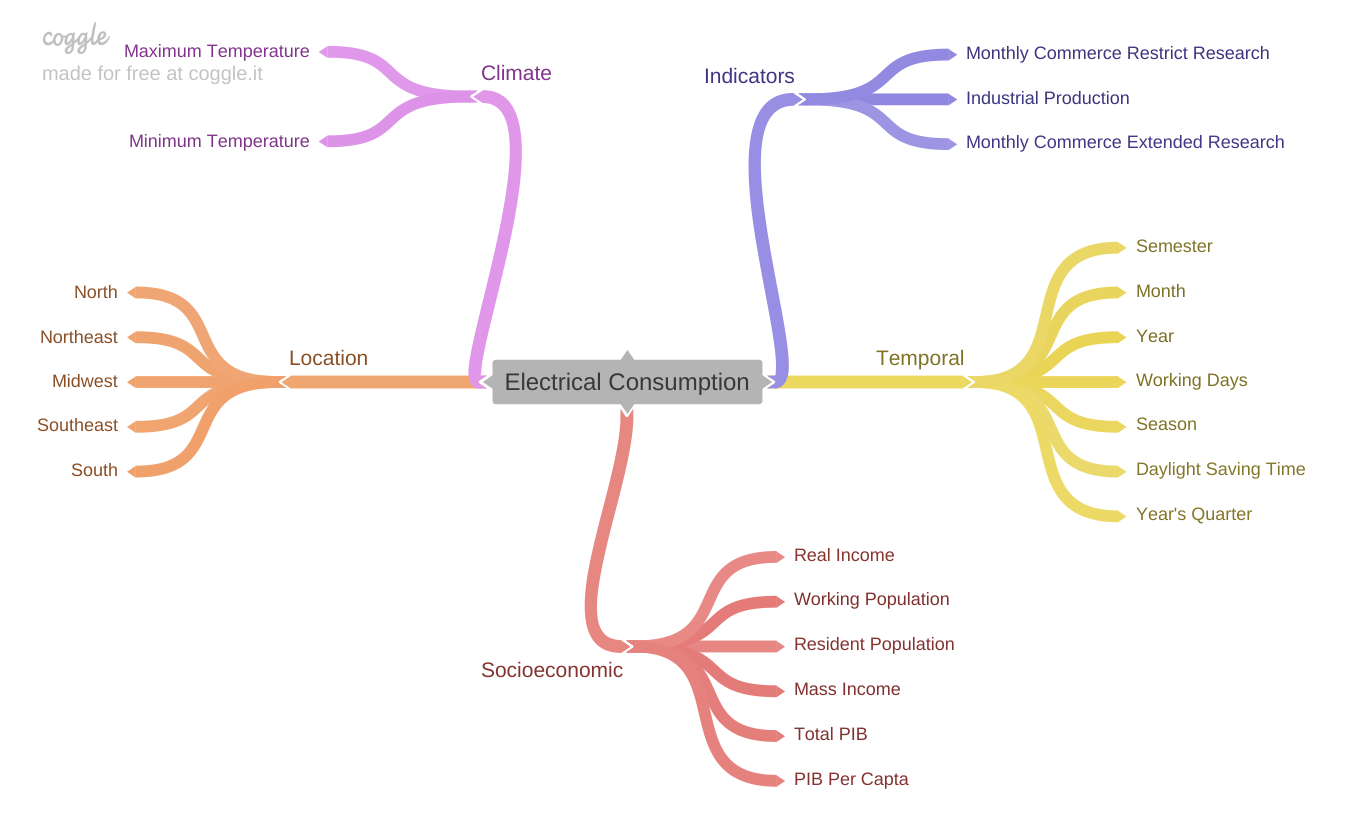

In [24]:
Image('../images/mind_map.png')

## <font color=green size= 5>3.3 FEATURES TRANSFORMATION </font>
***

In this section I will create some new features from the atual features, based on the variables that I mapped in the mind map image.

In [25]:
# creating the 'mes' column in the 'df2' dataframe
df2['mes'] = df2['data'].dt.month

# creating the 'ano' column in the 'df2' dataframe
df2['ano'] = df2['data'].dt.year

# creating the 'estacao' column in the 'df2' dataframe
df2['estacao'] = df2['data'].apply(lambda x: 
                                                 'Verao' if 1 <= x.month <= 3 else
                                                 'Outono'   if 4 <= x.month <= 6 else
                                                 'Inverno' if 7 <= x.month <= 9 else
                                                 'Primavera')

# creating the 'trimestre' column in the 'df2' dataframe
df2['trimestre'] = df2['data'].apply(lambda x: 
                                                 1 if 1 <= x.month <= 3 else
                                                 2 if 4 <= x.month <= 6 else
                                                 3 if 7 <= x.month <= 9 else
                                                 4)

# creating the 'semestre' column in the 'df2' dataframe
df2['semestre'] = df2['data'].apply(lambda x: 
                                                 1 if 1 <= x.month <= 6 else
                                                 2)

In [26]:
# displaying the 'df2' first 5 dataframe's observations
df2.head()

,data,com_co,com_n,com_ne,com_s,com_se,ind_co,ind_n,ind_ne,ind_s,...,pop_resid_s,pop_resid_co,pib,pib_pc,horario_verao,mes,ano,estacao,trimestre,semestre
0,2004-01-01,307.28207,193.80956,589.29026,704.00174,2450.45329,364.326990,840.29035,2015.78331,1810.98019,...,26635629.0,12760734.0,1957751.0,10705.99,1,1,2004,Verao,1,1
1,2004-02-01,290.14685,175.49530,550.77261,733.89486,2396.96520,372.651510,810.25628,1942.01969,1931.86643,...,26635629.0,12760734.0,1957751.0,10705.99,1,2,2004,Verao,1,1
2,2004-03-01,307.10015,182.75690,573.02799,738.45706,2402.52074,408.630620,880.88796,2082.25048,2149.03063,...,26635629.0,12760734.0,1957751.0,10705.99,0,3,2004,Verao,1,1
3,2004-04-01,329.16091,189.49076,603.93873,743.57047,2580.91388,419.430051,861.61210,2056.94675,2164.76220,...,26635629.0,12760734.0,1957751.0,10705.99,0,4,2004,Outono,2,1
4,2004-05-01,303.23791,191.64219,570.17652,696.57947,2344.08400,407.523810,901.70980,2100.19137,2164.98022,...,26635629.0,12760734.0,1957751.0,10705.99,0,5,2004,Outono,2,1


## <font color=green size= 5>3.4 OUTLIERS MANIPULATION </font>
***

There will be no outliers manipulation. This because the outliers are part of the information. 

For example, we can't delete **`res_co`** outliers, because probably they are referring to a specific period (summer, for example) and we will lose the bias of the period.

# <font color=green size= 6> <b>4. EXPLORATORY DATA ANALYSIS </font></b>
***

In [27]:
# creating the 'df3' dataframe as a copy from the original 'df2' dataframe, to work with
df3 = df2.copy()

# displaying the 'df3' first 5 dataframe's observations  
df3.head()

,data,com_co,com_n,com_ne,com_s,com_se,ind_co,ind_n,ind_ne,ind_s,...,pop_resid_s,pop_resid_co,pib,pib_pc,horario_verao,mes,ano,estacao,trimestre,semestre
0,2004-01-01,307.28207,193.80956,589.29026,704.00174,2450.45329,364.326990,840.29035,2015.78331,1810.98019,...,26635629.0,12760734.0,1957751.0,10705.99,1,1,2004,Verao,1,1
1,2004-02-01,290.14685,175.49530,550.77261,733.89486,2396.96520,372.651510,810.25628,1942.01969,1931.86643,...,26635629.0,12760734.0,1957751.0,10705.99,1,2,2004,Verao,1,1
2,2004-03-01,307.10015,182.75690,573.02799,738.45706,2402.52074,408.630620,880.88796,2082.25048,2149.03063,...,26635629.0,12760734.0,1957751.0,10705.99,0,3,2004,Verao,1,1
3,2004-04-01,329.16091,189.49076,603.93873,743.57047,2580.91388,419.430051,861.61210,2056.94675,2164.76220,...,26635629.0,12760734.0,1957751.0,10705.99,0,4,2004,Outono,2,1
4,2004-05-01,303.23791,191.64219,570.17652,696.57947,2344.08400,407.523810,901.70980,2100.19137,2164.98022,...,26635629.0,12760734.0,1957751.0,10705.99,0,5,2004,Outono,2,1


***

Based on the Mind Map in section 3.2, I created 8 hypothesis to validate and help me with the insights.

In section 4.1 I will validate all hypothesis and analyze their retrieved informations in the process, one by one.

**DISCLAIMER:** There are a lot of features to analyze their correlation or timeline behavior. So, with the short time that was give to me, I will mostly focus on the features that I think that will have a significant impact over the **`ind_se`** label.

- **HYPOTHESIS  1 (H1):** Brazil and regions electrical consumption, be it a Commerce, Industry or Residential consumption increases over the years.
<br>

- **HYPOTHESIS  2 (H2):**  Brazil and regions annual electrical consumption, be it a Commerce, Industry or Residential consumption increases with the PIB increase.
<br>

- **HYPOTHESIS  3 (H3):** Brazilian regions monthly residential electric consumption per its resident population, are higher in summer season then in the others.
<br>

- **HYPOTHESIS  4 (H4):**  Brazilian regions monthly industry electric consumption are higher in spring season than in the others.
<br>

- **HYPOTHESIS  5 (H5):** Brazilian annual commerce's electric consumption increases with the PIB per capita increase.
<br>

- **HYPOTHESIS  6 (H6):** Brazil and regions monthly electrical consumption, be it a Commerce, Industry or Residential consumption decreases on months of daylight saving time than the others.
<br>

- **HYPOTHESIS  7 (H7):** Brazil electrical consumption mean value, be it a Commerce, Industry or Residential consumption increases with the working population increase.
<br>

- **HYPOTHESIS  8 (H8):** Brazil residential electrical consumption mean value increases with the real income increase.

## <font color=green size= 5>4.1 HYPOTHESIS ANALYSIS </font>
***

### <font color=green size= 4>4.1.1 HYPOTHESIS 1: Brazil and regions electrical consumption, be it a Commerce, Industry or Residential consumption increases over the years. </font> - FALSE 
***

In [28]:
# creating the 'aux' dataframe, as a copy of the 'df3' dataframe
aux = df3.copy()

# creating the Brazil commerce, industry and residential total values, per observation, in the 'aux' dataframe
aux['com_br'] = aux['com_ne'] + aux['com_n'] + aux['com_co'] + aux['com_s'] + aux['com_se'] 
aux['ind_br'] = aux['ind_ne'] + aux['ind_n'] + aux['ind_co'] + aux['ind_s'] + aux['ind_se'] 
aux['res_br'] = aux['res_ne'] + aux['res_n'] + aux['res_co'] + aux['res_s'] + aux['res_se'] 

# creating the Brazil commerce, industry and residential total values, per year, in the 'aux' dataframe
aux = aux[['ano', 'com_br', 'ind_br', 'res_br', \
           'com_ne', 'com_n', 'com_co', 'com_s', 'com_se', \
           'ind_ne', 'ind_n', 'ind_co', 'ind_s', 'ind_se', \
           'res_ne', 'res_n', 'res_co', 'res_s', 'res_se']].groupby(['ano']).sum().reset_index()

# removing the 2021 year informations, because there are only 2 observed months for this year
aux = aux[aux['ano'] != 2021]

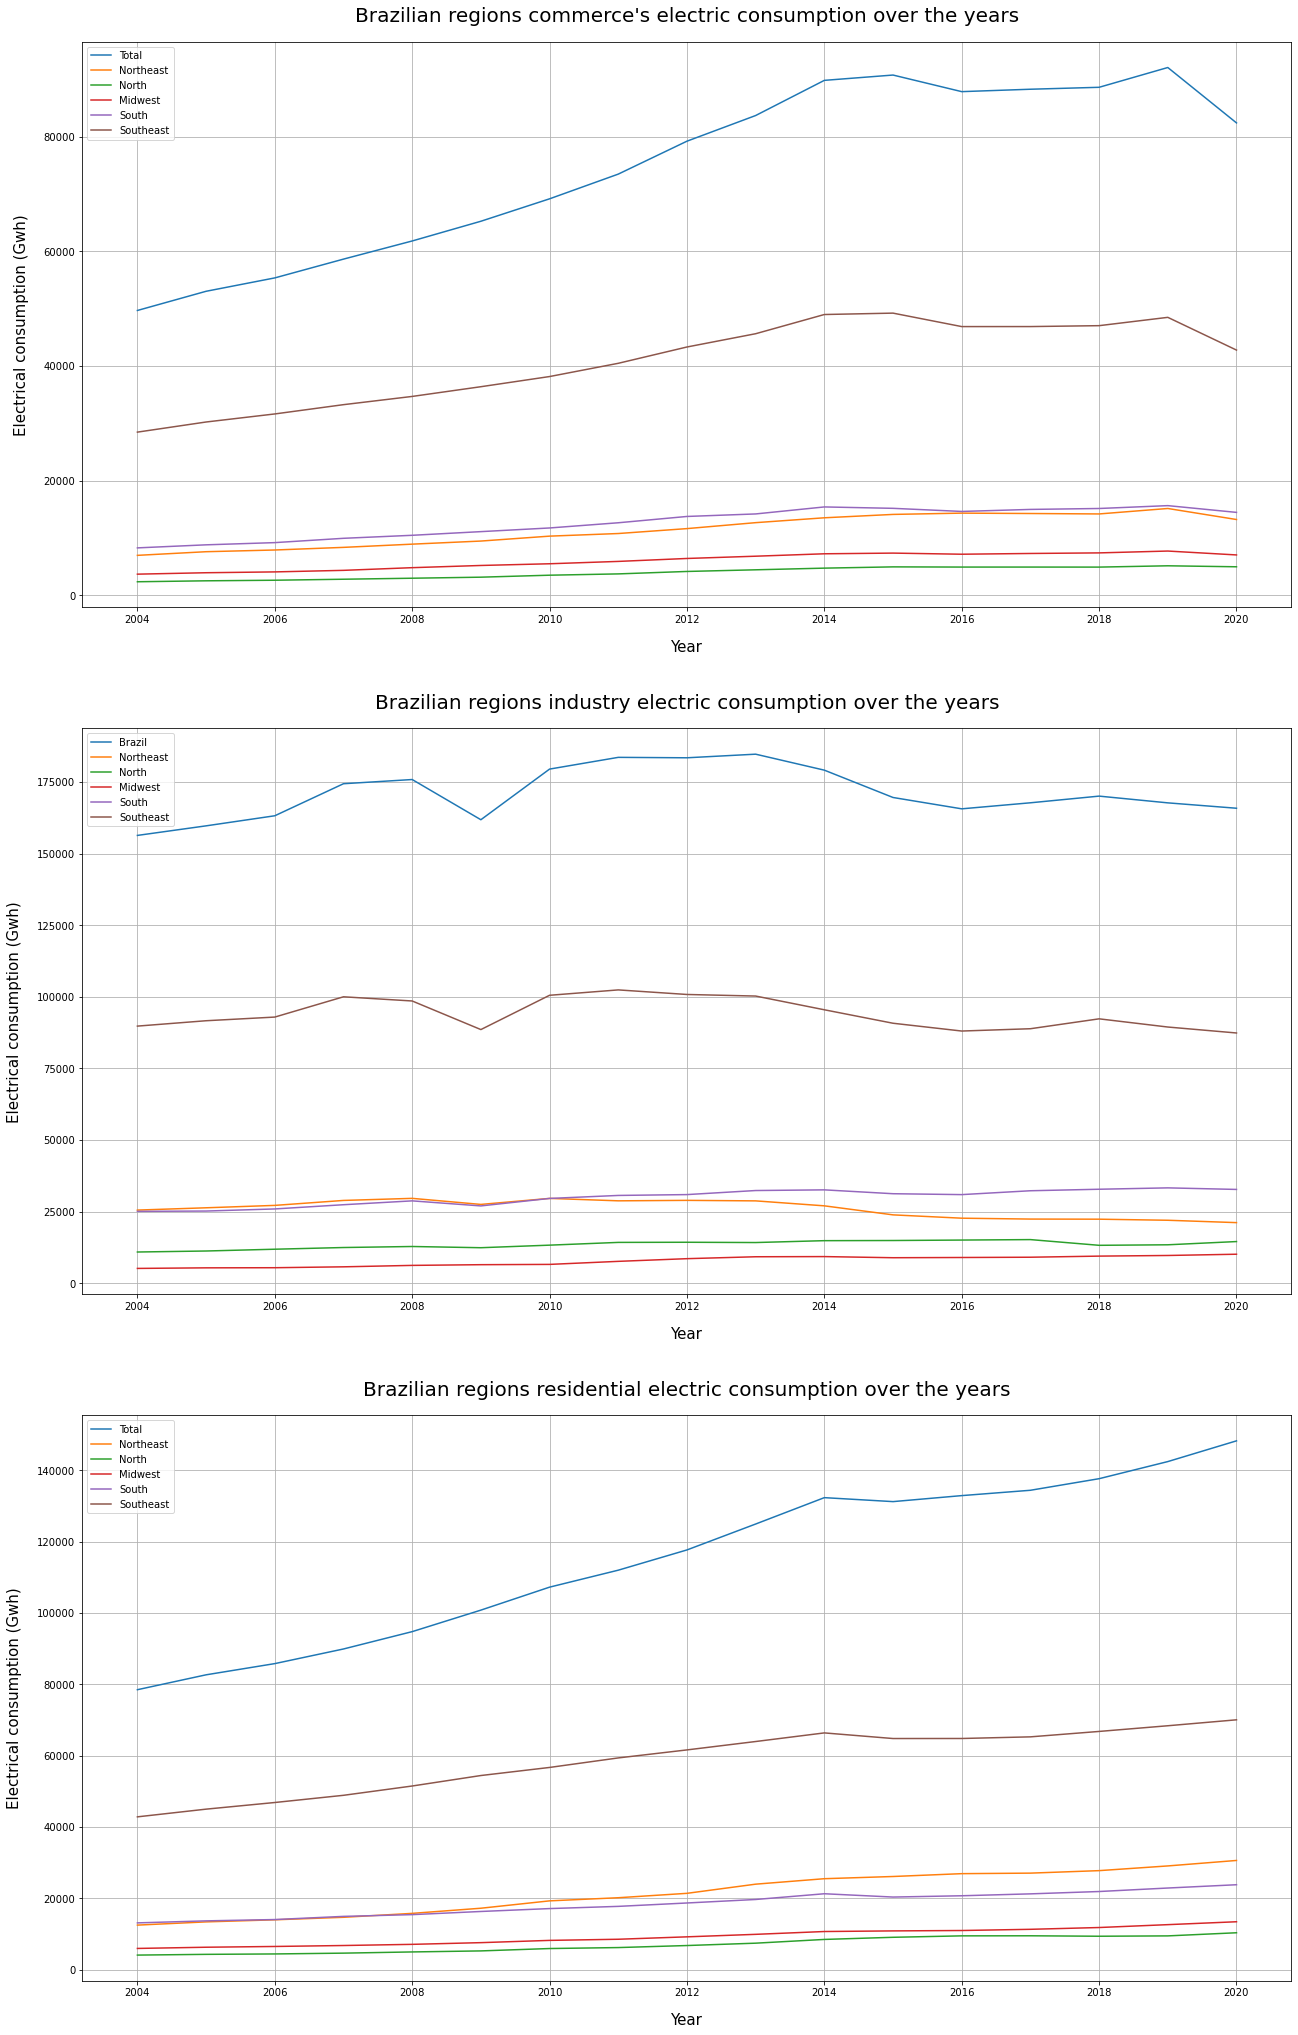

In [29]:
# creating the 'com_features' list with the commerce features that we will plot
com_features = ['com_br', 'com_ne', 'com_n', 'com_co', 'com_s', 'com_se']

# creating the 'ind_features' list with the industry features that we will plot
ind_features = ['ind_br', 'ind_ne', 'ind_n', 'ind_co', 'ind_s', 'ind_se']

# creating the 'res_features' list with the residential features that we will plot
res_features = ['res_br', 'res_ne', 'res_n', 'res_co', 'res_s', 'res_se']


# creating a figure
fig, ax = plt.subplots(3, 1, figsize=(20,30))

# adjusting subplot
plt.tight_layout(pad= 10)


# looping over the commerce features to create their lineplots
for com_feature in com_features:
    sns.lineplot(ax= ax[0], x= aux['ano'], y= aux[com_feature])

# setting ax graph, title, labels, ticks and sizes
ax[0].set_title("Brazilian regions commerce's electric consumption over the years", size= 20, pad= 20)
ax[0].set_ylabel("Electrical consumption (Gwh)", size= 15, labelpad= 15)
ax[0].set_xlabel("Year", size= 15, labelpad= 15)
ax[0].legend(labels=['Total', 'Northeast', 'North', 'Midwest', 'South', 'Southeast'])
ax[0].grid()


# looping over the industry features to create their lineplots
for ind_feature in ind_features:
    sns.lineplot(ax= ax[1], x= aux['ano'], y= aux[ind_feature])

# setting ax graph, title, labels, ticks and sizes
ax[1].set_title("Brazilian regions industry electric consumption over the years", size= 20, pad= 20)
ax[1].set_ylabel("Electrical consumption (Gwh)", size= 15, labelpad= 15)
ax[1].set_xlabel("Year", size= 15, labelpad= 15)
ax[1].legend(labels=['Brazil', 'Northeast', 'North', 'Midwest', 'South', 'Southeast'])
ax[1].grid()
    

# looping over the residential features to create their lineplots
for res_feature in res_features:
    sns.lineplot(ax= ax[2], x= aux['ano'], y= aux[res_feature])

# setting ax graph, title, labels, ticks and sizes
ax[2].set_title("Brazilian regions residential electric consumption over the years", size= 20, pad= 20)
ax[2].set_ylabel("Electrical consumption (Gwh)", size= 15, labelpad= 15)
ax[2].set_xlabel("Year", size= 15, labelpad= 15)
ax[2].legend(labels=['Total', 'Northeast', 'North', 'Midwest', 'South', 'Southeast'])
ax[2].grid()
    
# saving the graph as 'H1' in the storytelling folder  
plt.savefig('../storytelling/H1.png')

***
**As seen above, we can get some insights:**

- The Brazil commerce, industry and residential electric consumption doesn't always increase over the years, something already expected.
<br>

- The Brazilian regions commerce's electric consumptions have the same behavior over the years, keeping their values proportion.
<br>

- The Brazilian regions industry electric consumptions have the same behavior over the years, keeping their values proportion.
<br>

- The Brazilian regions residential electric consumptions have the same behavior over the years, keeping their values proportion.
<br>

- The Southeast and South regions electrical consumptions, be it commerce, industry or residential, prevails over the others Brazilian regions. That can be explained with these regions being the most industrialized regions and having the most resident population.
<br>

- Between 2019 and 2020 there is a abrupt commerce's electric consumption reduction in Brazil. This period behavior matches with the COVID-19 pandemic first wave over Brazil economy, increasing the unemployment rate, reducing the population purchasing power and consequently reducing the commerce's electric consumption.
<br>

- Between 2008 and 2009 years there is a clearly a industry electric consumption reduction in Brazil. This recession period matches with the 2008 world financial crises, the most serious financial crisis since the Great Depression. Then in 2009 to 2010 the economy starts to recover.
<br>

- Between 2013 and 2016 there is a industry electric consumption reduction in Brazil. This period behavior matches with the 2014 World Cup in Brazil spendings and the Lava Jato operation's apex, a investigations of billions in deviated resources from Brazilian state companies.
<br>

- There is a "exponential" residential electric consumption increase in Brazil between 2014 and 2020. By searching for the  Brazilian electrical tariff flag's historic in this period, this period was dominated by the green flag, the most favorable flag for  power generation.

### <font color=green size= 4>4.1.2 HYPOTHESIS 2: Brazil and regions annual electrical consumption, be it a Commerce, Industry or Residential consumption increases with the PIB increase. </font>  - TRUE
***

In [30]:
# creating the 'aux' dataframe, as a copy of the 'df3' dataframe
aux = df3.copy()

# removing the observations with NaN values in the 'pib' column in the 'aux' dataframe
aux = aux[aux['pib'].notnull()]

# creating the Brazil commerce, industry and residential total values, per observation, in the 'aux' dataframe
aux['com_br'] = aux['com_ne'] + aux['com_n'] + aux['com_co'] + aux['com_s'] + aux['com_se'] 
aux['ind_br'] = aux['ind_ne'] + aux['ind_n'] + aux['ind_co'] + aux['ind_s'] + aux['ind_se'] 
aux['res_br'] = aux['res_ne'] + aux['res_n'] + aux['res_co'] + aux['res_s'] + aux['res_se'] 

# creating the Brazil commerce, industry and residential total values, per year, in the 'aux' dataframe
aux = aux[['ano', 'pib', 'com_br', 'ind_br', 'res_br']].groupby(['ano']).agg({'pib': 'mean', \
                                                                              'com_br': 'sum', \
                                                                              'ind_br': 'sum', \
                                                                              'res_br': 'sum'}).reset_index()

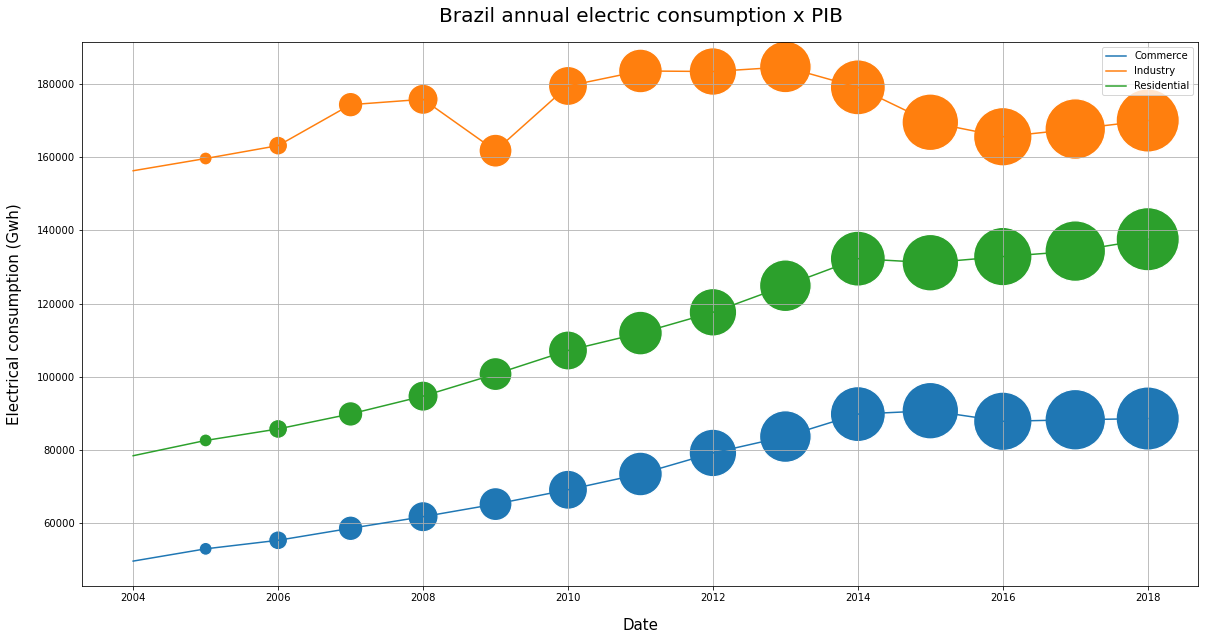

In [31]:
# creating a figure
fig, ax = plt.subplots(1, 1, figsize=(20,10))

# creating a lineplot for each eletric consumption segment
sns.lineplot(ax= ax, x= aux['ano'], y= aux['com_br'])
sns.lineplot(ax= ax, x= aux['ano'], y= aux['ind_br'])
sns.lineplot(ax= ax, x= aux['ano'], y= aux['res_br'])

# creating a scatterplot for each eletric consumption segment
sns.scatterplot(ax= ax, x= aux['ano'], y= aux['com_br'], size= aux['pib'], sizes= (1, 4000))
sns.scatterplot(ax= ax, x= aux['ano'], y= aux['ind_br'], size= aux['pib'], sizes= (1, 4000))
sns.scatterplot(ax= ax, x= aux['ano'], y= aux['res_br'], size= aux['pib'], sizes= (1, 4000))

# setting ax graph, title, labels, ticks and sizes
ax.set_title("Brazil annual electric consumption x PIB", size= 20, pad= 20)
ax.set_ylabel("Electrical consumption (Gwh)", size= 15, labelpad= 15)
ax.set_xlabel("Date", size= 15, labelpad= 15)
ax.legend(labels=['Commerce', 'Industry', 'Residential'])
ax.grid()
    
# saving the graph as 'H2' in the storytelling folder  
plt.savefig('../storytelling/H2.png')

***
**As seen above, we can get some insights:**

- The PIB, represented by the bubbles size, increases year over year, which is great for our nation. 
<br>

- There is a pattern, if we close our eyes for the crises events mentioned in the Hypothesis 1 above, which we can say that the Industry, Commerce and Residential electric consumptions increases with the PIB increase.
<br>

This correlation is probably caused due to the Brazil industrial and economic power increasing year by year. Then, we can spend more in industrial production, warm up our commerce due to the purchasing power increasing and spend more in residential comfort.

### <font color=green size= 4>4.1.3 HYPOTHESIS 3: Brazilian regions monthly residential electric consumption per its resident population, are higher in summer season then in the others. </font> - FALSE
***

In [32]:
# creating the 'aux' dataframe, as a copy of the 'df3' dataframe
aux = df3.copy()

# removing the 2021 year informations, because there are only 2 observed months for this year and we have not informations about
# resident population about them
aux = aux[aux['ano'] != 2021]

# creating the Brazil residential total values, per observation, in the 'aux' dataframe
aux['res_br'] = aux['res_ne'] + aux['res_n'] + aux['res_co'] + aux['res_s'] + aux['res_se'] 

# creating the Brazil regions residential electric consumption per its resident population, per observation, in the 'aux' 
# dataframe
aux['res_per_resid_pop'] = aux['res_br'] / aux['pop_resid'] * 1000000
aux['res_per_resid_pop_n'] = aux['res_n'] / aux['pop_resid_n'] * 1000000
aux['res_per_resid_pop_ne'] = aux['res_ne'] / aux['pop_resid_ne'] * 1000000
aux['res_per_resid_pop_co'] = aux['res_co'] / aux['pop_resid_co'] * 1000000
aux['res_per_resid_pop_s'] = aux['res_s'] / aux['pop_resid_s'] * 1000000
aux['res_per_resid_se'] = aux['res_br'] / aux['pop_resid_se'] * 1000000

# creating the Brazil total residential electric consumption per capita per season, in the 'aux' dataframe
aux = aux[['estacao', 'res_per_resid_pop', 'res_per_resid_pop_n', 'res_per_resid_pop_ne', \
           'res_per_resid_pop_co', 'res_per_resid_pop_s', 'res_per_resid_se']].groupby(['estacao']).mean().reset_index()

# segmenting the 'estacao' column values for each other column as an unique observation in 'aux' dataframe
aux = aux.melt(id_vars= 'estacao').rename(columns= str.title)

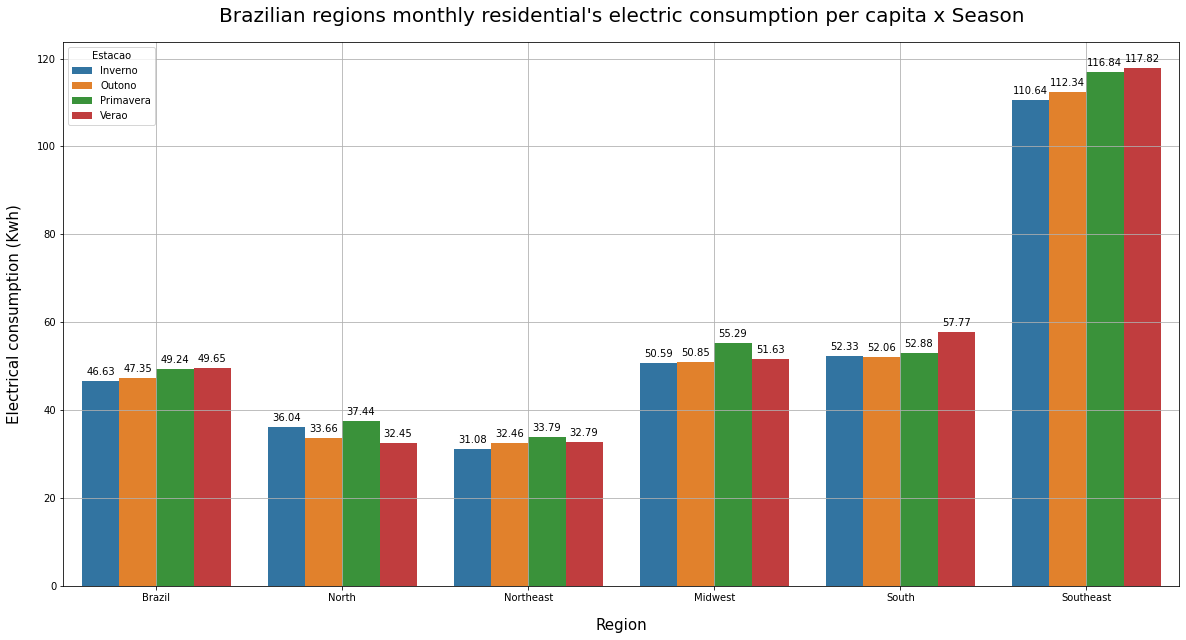

In [33]:
# creating a figure
fig, ax = plt.subplots(1, 1, figsize= (20,10))

# setting the axes graphs, titles, labels, ticks and sizes
ax = sns.barplot(ax= ax, x= aux['Variable'], y= aux['Value'], hue= aux['Estacao'])
ax.set_title("Brazilian regions monthly residential's electric consumption per capita x Season", size= 20, pad= 20)
ax.set_xlabel("Region", size= 15, labelpad= 15)
ax.set_ylabel('Electrical consumption (Kwh)', size= 15, labelpad= 15)
ax.set_xticklabels(['Brazil', 'North', 'Northeast', 'Midwest', 'South', 'Southeast']);
ax.grid()

# inserting column values over them
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
# saving the graph as 'H3' in the storytelling folder     
plt.savefig('../storytelling/H3.png')

***
**As seen above, we can get some insights:**

- Brazil monthly residential electric consumption per capita in summer is the highest one.
<br>

- The regions residential's electric consumption distribution per capita over the seasons are not so discrepant from each other. That is probably due to some kind of compensation. For example, in summer people tends spend a lot of electric power with air conditioner, and in the winter this consumption is compensated with some kind of room heater and electric shower. 
<br>

- Something that is interesting is that the North region is the one with the most discrepant residential's electric consumption values distribution over the seasons, but its the second region with the lowest maximum temperature range over the dataset timeline (as we saw in section 2.6), due to be the most equatorial region.

### <font color=green size= 4>4.1.4 HYPOTHESIS 4: Brazilian regions monthly industry electric consumption are higher in spring season than in the others. </font> - FALSE
***

In [34]:
# creating the 'aux' dataframe, as a copy of the 'df3' dataframe
aux = df3.copy()

# removing the 2021 year informations, because there are only 2 observed months for this year and we have not informations about
# resident population about them
aux = aux[aux['ano'] != 2021]

# creating the Brazil industry total values, per observation, in the 'aux' dataframe
aux['ind_br'] = aux['ind_ne'] + aux['ind_n'] + aux['ind_co'] + aux['ind_s'] + aux['ind_se'] 

# creating the Brazil industry total values, per season, in the 'aux' dataframe
aux = aux[['estacao', 'ind_br', 'ind_n', 'ind_ne', 'ind_co', 'ind_s', 'ind_se']].groupby(['estacao']).mean().reset_index()

# segmenting the 'estacao' column values for each other column as an unique observation in 'aux' dataframe
aux = aux.melt(id_vars= 'estacao').rename(columns= str.title)

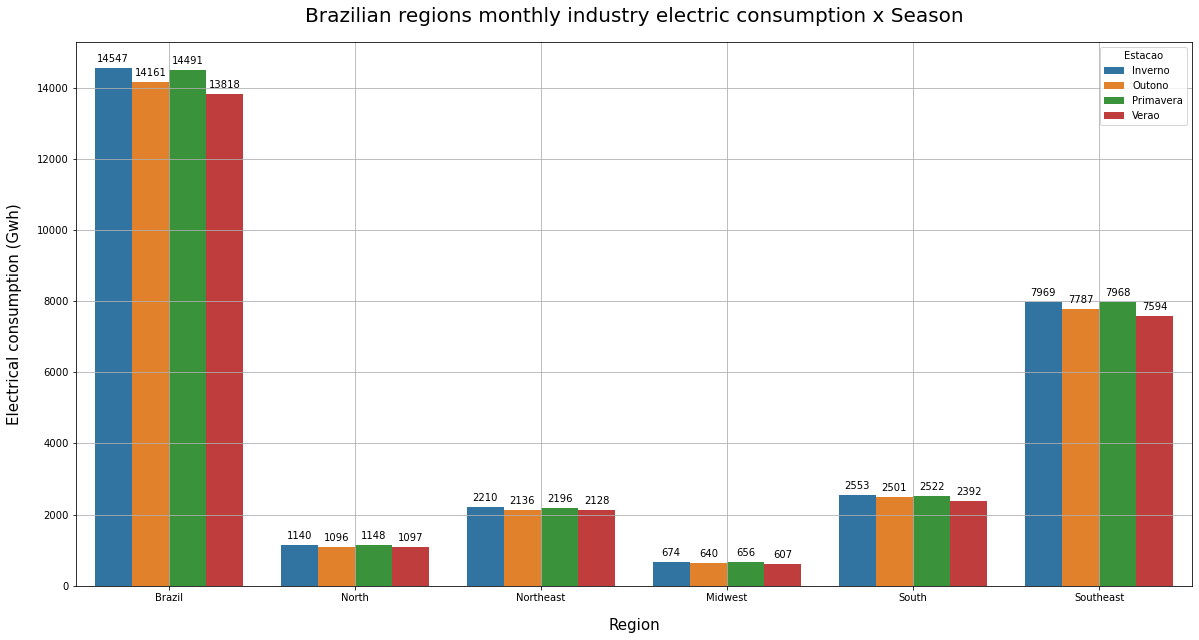

In [35]:
# creating a figure
fig, ax = plt.subplots(1, 1, figsize= (20,10))

# setting the axes graphs, titles, labels, ticks and sizes
ax = sns.barplot(ax= ax, x= aux['Variable'], y= aux['Value'], hue= aux['Estacao'])
ax.set_title("Brazilian regions monthly industry electric consumption x Season", size= 20, pad= 20)
ax.set_xlabel("Region", size= 15, labelpad= 15)
ax.set_ylabel('Electrical consumption (Gwh)', size= 15, labelpad= 15)
ax.set_xticklabels(['Brazil', 'North', 'Northeast', 'Midwest', 'South', 'Southeast']);
ax.grid()

# inserting column values over them
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
# saving the graph as 'H4' in the storytelling folder     
plt.savefig('../storytelling/H4.png')

***
**As seen above, we can get some insights:**

- The regions monthly industry electric consumption over the weather seasons maintains the same distribution pattern.
<br>

- Despite of our hypothesis affirmation, winter seems to be the season that the industry section consume more electrical power, winning by a slightly difference from spring season. Our hypothesis was based that in summer the industry employees go on vacation and the industry rush on spring season to compensate this.
<br>

- Overall, the industry sector seems to maintain the same production / electrical consumption pattern over the year. I would be interesting understand more about it, because there are some industries that have a seasonal production.

### <font color=green size= 4>4.1.5 HYPOTHESIS 5: Brazilian annual commerce's electric consumption increases with the PIB per capita increase. </font> - TRUE
***

In [36]:
# creating the 'aux' dataframe, as a copy of the 'df3' dataframe
aux = df3.copy()

# removing the observations with NaN values in the 'pib_pc' column in the 'aux' dataframe
aux = aux[aux['pib_pc'].notnull()]

# creating the Brazil commerce total values, per observation, in the 'aux' dataframe
aux['com_br'] = aux['com_ne'] + aux['com_n'] + aux['com_co'] + aux['com_s'] + aux['com_se'] 

# creating the Brazil commerce total values, per year, in the 'aux' dataframe
aux = aux[['ano', 'pib_pc', 'com_br']].groupby(['ano']).agg({'pib_pc': 'mean', \
                                                             'com_br': 'sum'}).reset_index()

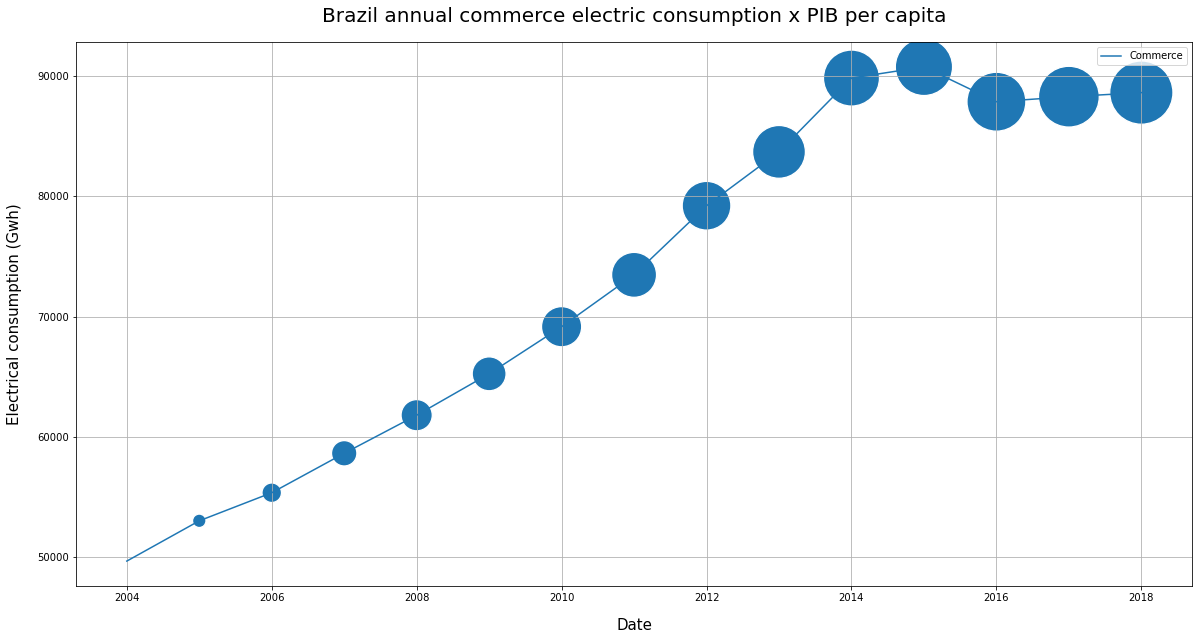

In [37]:
# creating a figure
fig, ax = plt.subplots(1, 1, figsize=(20,10))

# creating a lineplot for the commerce's eletric consumption segment
sns.lineplot(ax= ax, x= aux['ano'], y= aux['com_br'])

# creating a scatterplot for the commerce's eletric consumption segment
sns.scatterplot(ax= ax, x= aux['ano'], y= aux['com_br'], size= aux['pib_pc'], sizes= (1, 4000))

# setting ax graph, title, labels, ticks and sizes
ax.set_title("Brazil annual commerce electric consumption x PIB per capita", size= 20, pad= 20)
ax.set_ylabel("Electrical consumption (Gwh)", size= 15, labelpad= 15)
ax.set_xlabel("Date", size= 15, labelpad= 15)
ax.legend(labels= ['Commerce'])
ax.grid()
    
# saving the graph as 'H5' in the storytelling folder  
plt.savefig('../storytelling/H5.png')

***
**As seen above, we can get some insights:**

- The Brazil commerce electric consumption over the years X PIB per capita have the same behavior as compare to the PIB, as we saw in section 4.1.2. 
<br>

We know, Brazil is one of the top countries when we rank the countries with the worsts distribution of income. So even if Brazil's PIB per capita increases over the years, it doesn't mean that this income increase is well distributed to the population.

Based on this, checking if the commerce electric consumption increases with the PIB per capita, its an indicator that probably the income distribution is getting better, because the commerce is warmed by the population's purchase power.

### <font color=green size= 4>4.1.6 HYPOTHESIS 6: Brazil and regions monthly electrical consumption, be it a Commerce, Industry or Residential consumption decreases on months of daylight saving time than the others. </font> - FALSE
***

In [38]:
# creating the 'aux' dataframe, as a copy of the 'df3' dataframe
aux = df3.copy()

# creating the Brazil industry total values, per observation, in the 'aux' dataframe
aux['ind_br'] = aux['ind_ne'] + aux['ind_n'] + aux['ind_co'] + aux['ind_s'] + aux['ind_se'] 

# creating the Brazil commerce, industry and residential total values, per observation, in the 'aux' dataframe
aux['com_br'] = aux['com_ne'] + aux['com_n'] + aux['com_co'] + aux['com_s'] + aux['com_se'] 
aux['ind_br'] = aux['ind_ne'] + aux['ind_n'] + aux['ind_co'] + aux['ind_s'] + aux['ind_se'] 
aux['res_br'] = aux['res_ne'] + aux['res_n'] + aux['res_co'] + aux['res_s'] + aux['res_se'] 

# changing the 'horario_Verao' column values to strings
aux['horario_verao'] = aux['horario_verao'].apply(lambda x: 'Yes' if x == 1 else 'No')

# creating the Brazil residential total values, if is daylight saving time period, in the 'aux' dataframe
res_aux = aux[['horario_verao', 'res_br', 'res_co', 'res_s', 'res_se']].groupby(['horario_verao']).mean().reset_index()

# creating the Brazil indutry total values, if is daylight saving time period, in the 'aux' dataframe
ind_aux = aux[['horario_verao', 'ind_br', 'ind_co', 'ind_s', 'ind_se']].groupby(['horario_verao']).mean().reset_index()

# creating the Brazil commerce total values, if is daylight saving time period, in the 'aux' dataframe
com_aux = aux[['horario_verao', 'com_br', 'com_co', 'com_s', 'com_se']].groupby(['horario_verao']).mean().reset_index()

# segmenting the 'horario_verao' column values for each other column as an unique observation in 'res_aux' dataframe
res_aux = res_aux.melt(id_vars= 'horario_verao').rename(columns= str.title)

# segmenting the 'horario_verao' column values for each other column as an unique observation in 'ind_aux' dataframe
ind_aux = ind_aux.melt(id_vars= 'horario_verao').rename(columns= str.title)

# segmenting the 'horario_verao' column values for each other column as an unique observation in 'com_aux' dataframe
com_aux = com_aux.melt(id_vars= 'horario_verao').rename(columns= str.title)

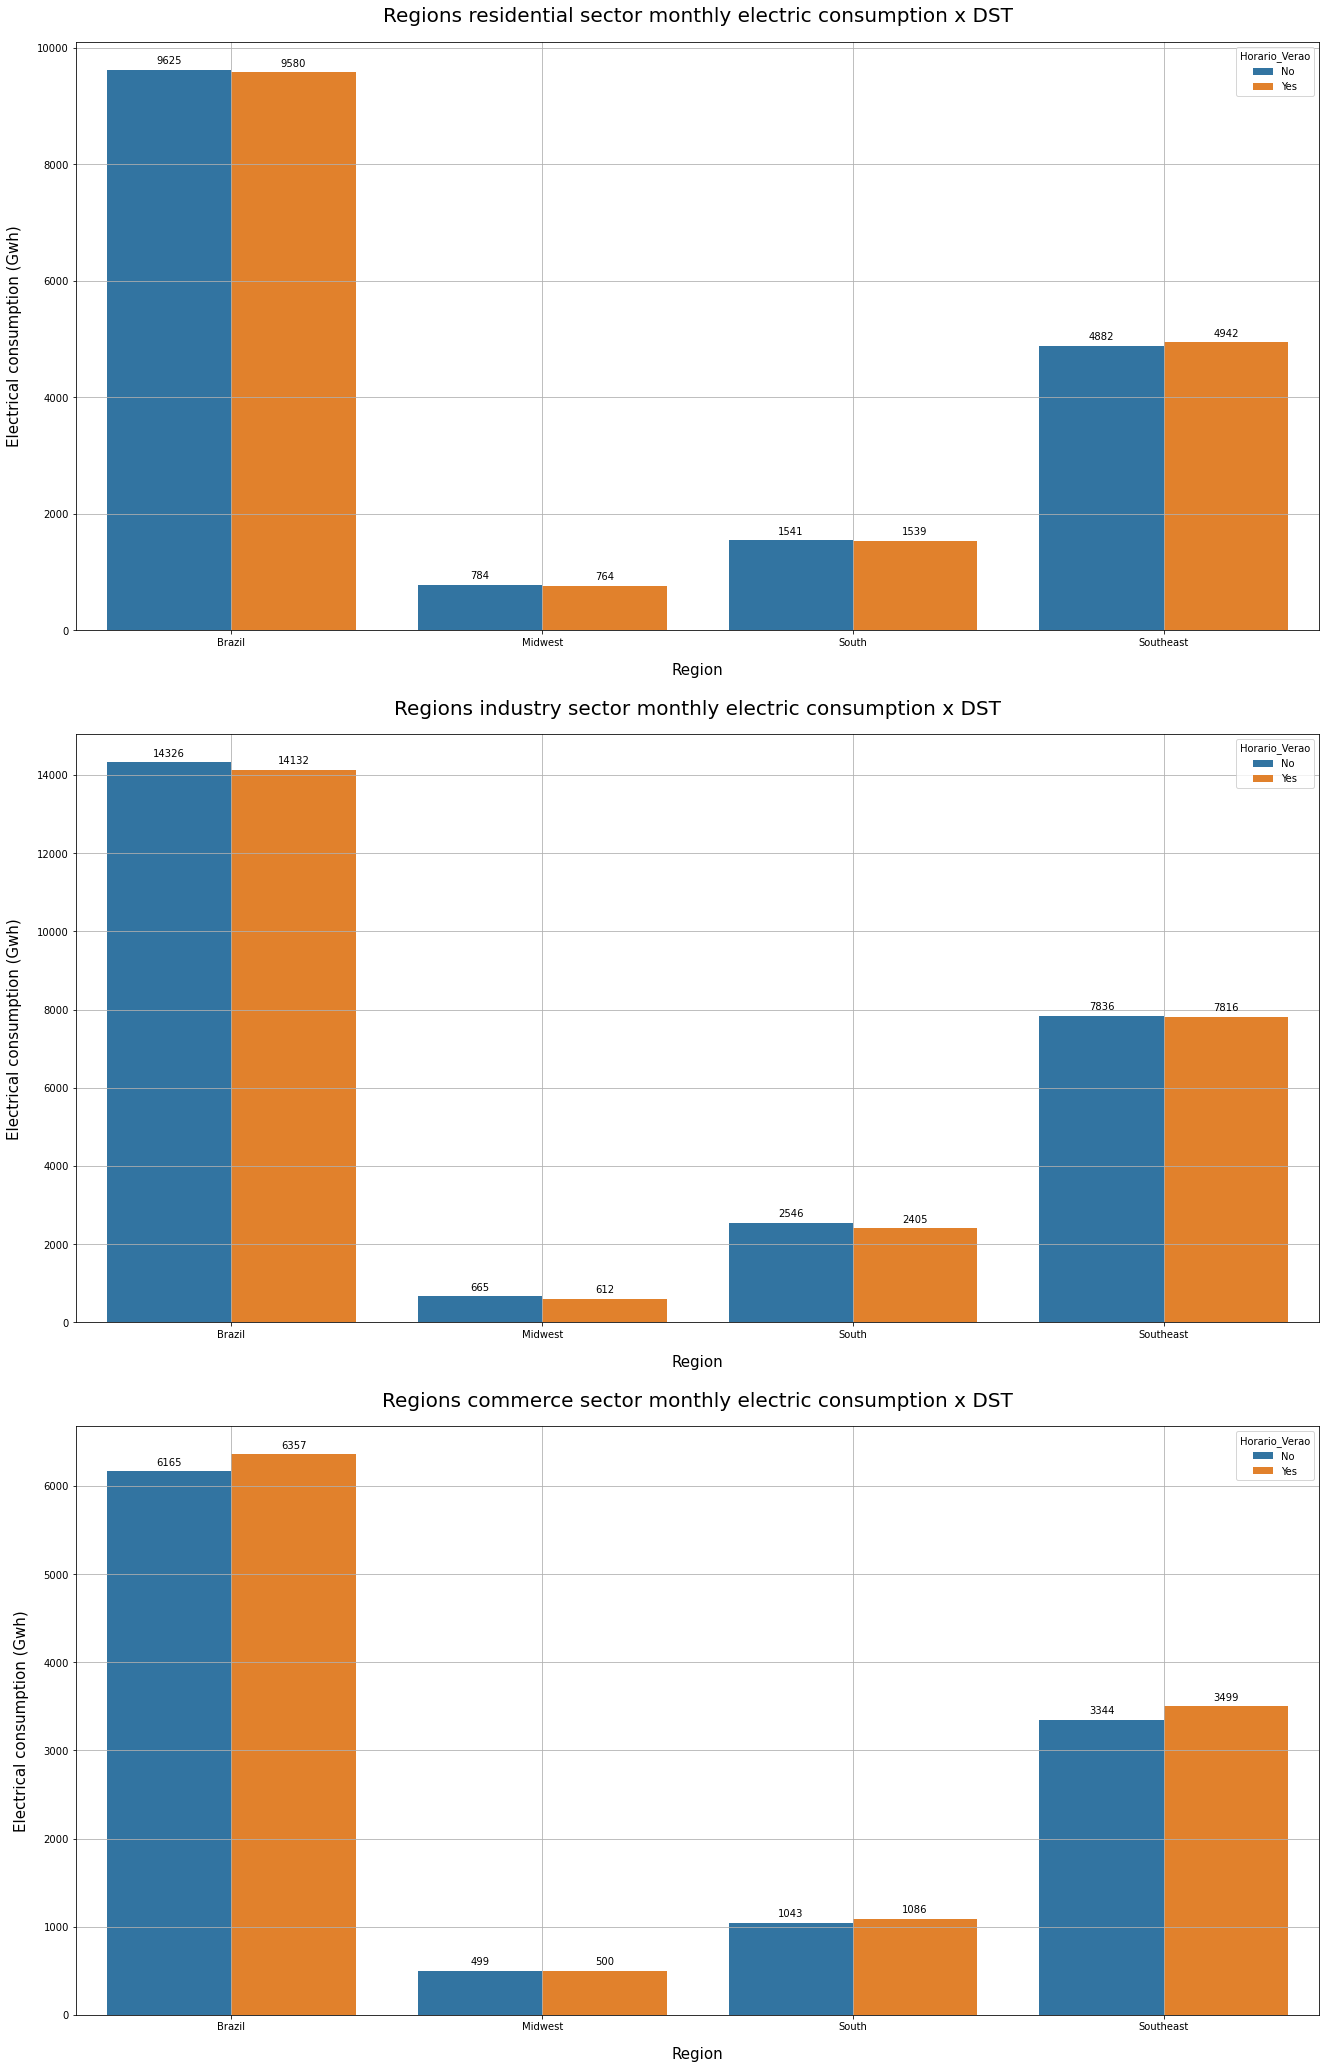

In [39]:
# creating a figure with 3 rows and 1 column
fig, axes = plt.subplots(3, 1, figsize= (20,30))
fig.tight_layout(pad=8.3)

#
dataframes = [res_aux, ind_aux, com_aux]
graphs = list(range(3))
sectors = ['residential', 'industry', 'commerce']

#
for dataframe, graph, sector in zip(dataframes, graphs, sectors):

    # setting the axes graphs, titles, labels, ticks and sizes
    sns.barplot(ax= axes[graph], x= dataframe['Variable'], y= dataframe['Value'], hue= dataframe['Horario_Verao'])
    axes[graph].set_title(f"Regions {sector} sector monthly electric consumption x DST", size= 20, pad= 20)
    axes[graph].set_xlabel("Region", size= 15, labelpad= 15)
    axes[graph].set_ylabel('Electrical consumption (Gwh)', size= 15, labelpad= 15)
    axes[graph].set_xticklabels(['Brazil', 'Midwest', 'South', 'Southeast']);
    axes[graph].grid()

    # inserting column values over them
    for p in axes[graph].patches:
        axes[graph].annotate(format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')
    
# saving the graph as 'H6' in the storytelling folder     
plt.savefig('../storytelling/H6.png')

***
**As seen above, we can get some insights:**

- There isn't a big difference between the monthly electrical consumption between months with daylight saving time in the residential sector. In factor, almost all regions, excluding Southeast, have a slights residential electric consumption higher when is not a DST period. 
<br>

- The regions industry sector follows the same pattern as the residential sector, without a big difference between the monthly electrical consumption between months with daylight saving time in the residential sector. But, in the big picture, Brazil presents a 194 Gwh monthly industry electric consumption reduction when in DST period. 

Doing a quick research, assuming that 1 Mwh costs R\$ 350 for the industry sector in Brazil, the 194 Ghw reduction indicates a 
R\\$ 68.000.000,00 cost reduction. 
<br>

- For the commerce sector, the Brazil and Southeast region total electrical consumption are higher when in DST.I couldn't find a possible explanation for this, so far.

This **perhaps** could be explained by: A longer daylight period makes people stay on the street longer, more propense to go to the commerce, so the commerce have to stay opened a longer period, then consuming more electricity.
<br>

**DISCLAIMER**: As we said in section 3.1, DST were not applied to the North and Northeast regions in this dataset timeline, that's why they were not analyzed.

### <font color=green size= 4>4.1.7 HYPOTHESIS 7: Brazil electrical consumption mean value, be it a Commerce, Industry or Residential consumption increases with the working population increase. </font> - TRUE
***

In [40]:
# creating the 'aux' dataframe, as a copy of the 'df3' dataframe
aux = df3.copy()

# removing the 2021 year informations, because there are only 2 observed months for this year and we have not informations about
# resident population about them
aux = aux[aux['ano'] != 2021]

# creating the 'groups_pop_ocup' column
aux['groups_pop_ocup'] = pd.cut(aux['pop_ocup'], bins= list(np.arange(75000, 97000, 5000)))

# creating the Brazil commerce, industry and residential total values, per observation, in the 'aux' dataframe
aux['com_br'] = aux['com_ne'] + aux['com_n'] + aux['com_co'] + aux['com_s'] + aux['com_se'] 
aux['ind_br'] = aux['ind_ne'] + aux['ind_n'] + aux['ind_co'] + aux['ind_s'] + aux['ind_se'] 
aux['res_br'] = aux['res_ne'] + aux['res_n'] + aux['res_co'] + aux['res_s'] + aux['res_se'] 

# creating the Brazil commerce, industry and residential total values, per year, in the 'aux' dataframe
aux = aux[['groups_pop_ocup', 'com_br', 'ind_br', 'res_br']].groupby(['groups_pop_ocup']).agg({'com_br': 'mean', \
                                                                                   'ind_br': 'mean', \
                                                                                   'res_br': 'mean'}).reset_index()

# segmenting the 'horario_verao' column values for each other column as an unique observation in 'res_aux' dataframe
aux = aux.melt(id_vars= 'groups_pop_ocup').rename(columns= str.title)

# changing the 'Variable' column values to strings
aux['Variable'] = aux.apply(lambda x: 'Commerce' if x['Variable'] == 'com_br' else
                          'Industry' if x['Variable'] == 'ind_br' else
                          'Residential', axis= 1)

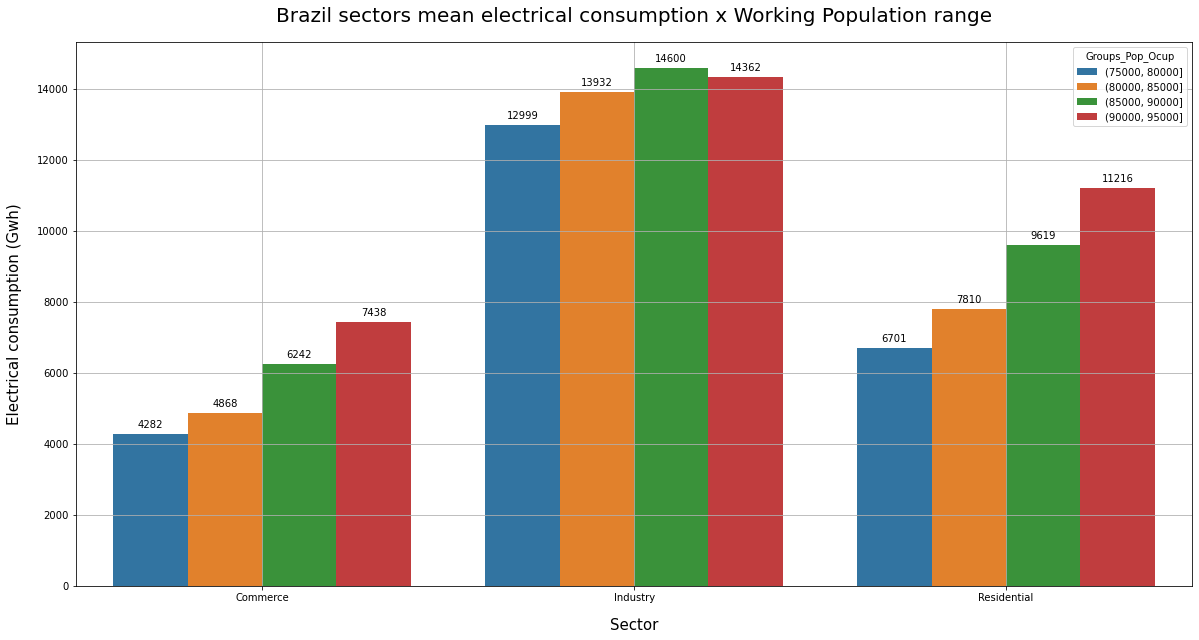

In [41]:
# creating a figure with 1 rows and 1 column
fig, ax = plt.subplots(1, 1, figsize= (20,10))

# setting the axes graphs, titles, labels, ticks and sizes
sns.barplot(ax= ax, x= aux['Variable'], y= aux['Value'], hue= aux['Groups_Pop_Ocup'])
ax.set_title(f"Brazil sectors mean electrical consumption x Working Population range", size= 20, pad= 20)
ax.set_xlabel("Sector", size= 15, labelpad= 15)
ax.set_ylabel('Electrical consumption (Gwh)', size= 15, labelpad= 15)
ax.grid()

# inserting column values over them
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
# saving the graph as 'H7' in the storytelling folder     
plt.savefig('../storytelling/H7.png')

***
**As seen above, we can get some insights:**

- This hypothesis is pretty clear, almost trivial so to speak, that for all sectors the working population increase will automatically increase the sector electrical consumption. 

There are a reduction of the industry electrical consumption for working populations range between 90 and 95 millions, but this is probably due to the crises period that we analyzed in section 4.1.1.

**The working population shows as pretty good feature to be considered for the ML model, which we will try to predict the Southeast industry electric consumption.**
<br>

### <font color=green size= 4>4.1.8 HYPOTHESIS 8: Brazil residential electrical consumption mean value increases with the real income increase. </font> - TRUE
***

In [42]:
# creating the 'aux' dataframe, as a copy of the 'df3' dataframe
aux = df3.copy()

# removing the 2021 year informations, because there are only 2 observed months for this year and we have not informations about
# resident population about them
aux = aux[aux['ano'] != 2021]

# removing the observations with NaN values in the 'renda_r' column in the 'aux' dataframe
aux = aux[aux['renda_r'].notnull()]

# creating the 'groups_pop_ocup' column
aux['groups_renda_r'] = pd.cut(aux['renda_r'], bins= list(np.arange(1300, 2200, 160)))

# creating the Brazil residential total values, per observation, in the 'aux' dataframe
aux['res_br'] = aux['res_ne'] + aux['res_n'] + aux['res_co'] + aux['res_s'] + aux['res_se'] 

# creating the Brazil residential total values, per year, in the 'aux' dataframe
aux = aux[['groups_renda_r', 'res_br']].groupby(['groups_renda_r']).mean().reset_index()

# segmenting the 'horario_verao' column values for each other column as an unique observation in 'res_aux' dataframe
aux = aux.melt(id_vars= 'groups_renda_r').rename(columns= str.title)

# changing the 'Variable' column values to strings
aux['Variable'] = aux.apply(lambda x: 'Commerce' if x['Variable'] == 'com_br' else
                          'Industry' if x['Variable'] == 'ind_br' else
                          'Residential', axis= 1)

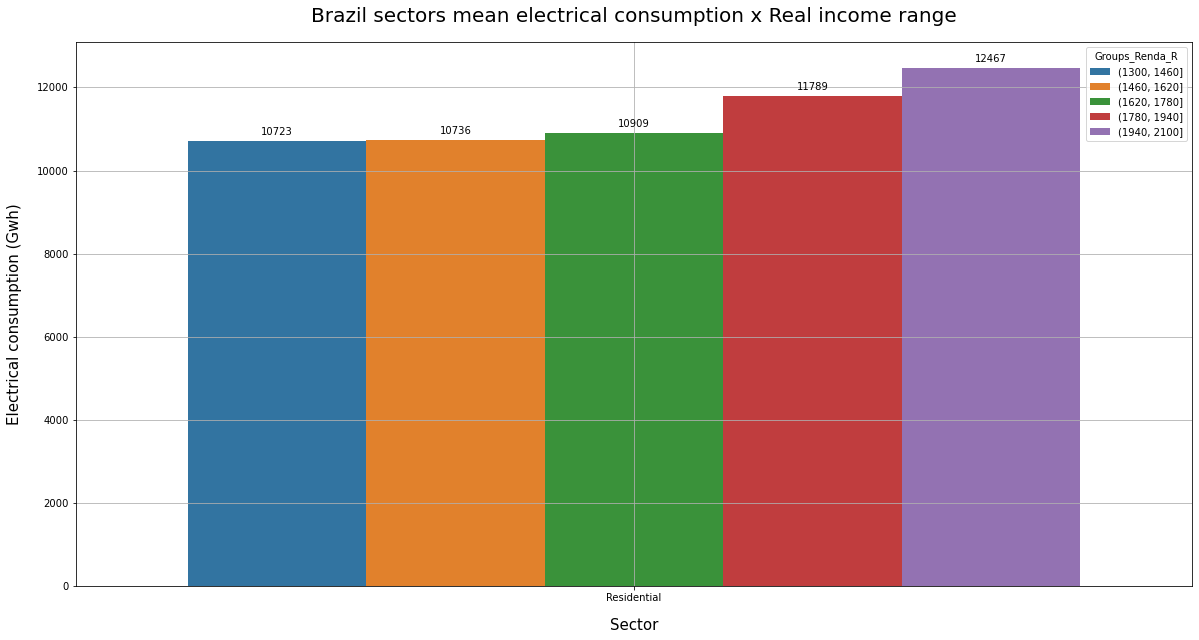

In [43]:
# creating a figure with 1 rows and 1 column
fig, ax = plt.subplots(1, 1, figsize= (20,10))

# setting the axes graphs, titles, labels, ticks and sizes
sns.barplot(ax= ax, x= aux['Variable'], y= aux['Value'], hue= aux['Groups_Renda_R'])
ax.set_title(f"Brazil sectors mean electrical consumption x Real income range", size= 20, pad= 20)
ax.set_xlabel("Sector", size= 15, labelpad= 15)
ax.set_ylabel('Electrical consumption (Gwh)', size= 15, labelpad= 15)
ax.grid()

# inserting column values over them
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
# saving the graph as 'H8' in the storytelling folder     
plt.savefig('../storytelling/H8.png')

***
**As seen above, we can get some insights:**

- This hypothesis is pretty clear, almost trivial so to speak again, that for the residential sector the real income increase will automatically increase the residential electric consumption. 

This can be explained by the families purchasing power increase, by the real income increase (which is apply by person). So, with this real income increase the families with probably spend more in home comfort and some of these home upgrades includes buying more home appliances, for example.

## <font color=green size= 5>4.2 MULTIVARIATE ANALYSIS </font>
***

In this section I will only analyze the correlation between the features that I initially think that will have a significant relation with the **`ind_se`** label, because this is the value that we want to predict with our choose ML model.

In the next CRISP-DM cycle I will analyze other possible features relations with the **`ind_se`** label. 

### <font color=green size= 4>4.2.1 NUMERICAL FEATURES CORRELATION </font>
***

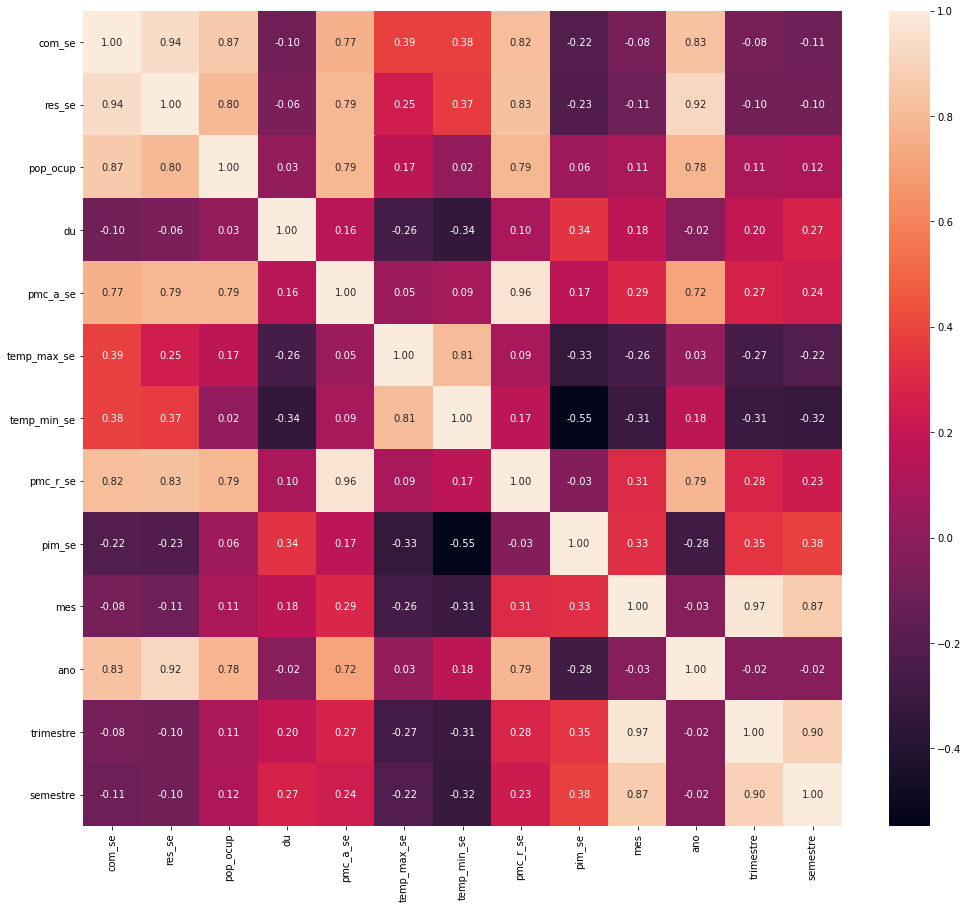

In [44]:
# creating the 'df3_num' dataframe with only numerical features from the 'df3' dataframe, which are not categorical features
df3_num = df3.select_dtypes(include= ['float64', 'int64', 'int32'])

# filtering in the 'df3_num' dataframe the features that we think that have a significant relation with the 'ind_se' label
df3_num = df3_num[['com_se', 'res_se', 'pop_ocup', 'du', 'pmc_a_se', 'temp_max_se', 'temp_min_se', 'pmc_r_se', 'pim_se', \
                 'mes', 'ano', 'trimestre', 'semestre']]

# creating a figure and adjusting its size
plt.figure(figsize= (17, 15))

# creating a correlation matrix from 'df3_num' dataframe
corre_num = df3_num.corr(method = 'pearson')

# creating a heatmap graph using the correlation matrix 'corre_num' as data
ax = sns.heatmap(corre_num, annot = True, fmt= '.2f')

# plotting the heat map
ax;

# saving the graph as 'num_features_relations_1' in the storytelling folder  
plt.savefig('../storytelling/num_features_relations_1.png')

***
**As seen above:**

There are some numerical features that have a strong correlation between them (90% or more).

This correlation isn't good for the model, because it increases the dimensionality without a considerable variance. So in this case, we should remove one of them.

**There are a few strong correlated features, which are:**

- **`mes`**                   and   **`trimestre`**              (97% correlation)
- **`pmc_r_se`**              and   **`pmc_a_se`**               (96% correlation)
- **`res_se`**                and   **`com_se`**                 (94% correlation)
- **`res_se`**                and   **`ano`**                    (92% correlation)
- **`semestre`**              and   **`trimestre`**              (90% correlation)

I will not remove them for now, this because I will check their relations with the **`ind_se`** label and apply some feature select models to help me select the best features for the ML model.

***
Now we will verify the features correlations with the **`ind_se`** label.

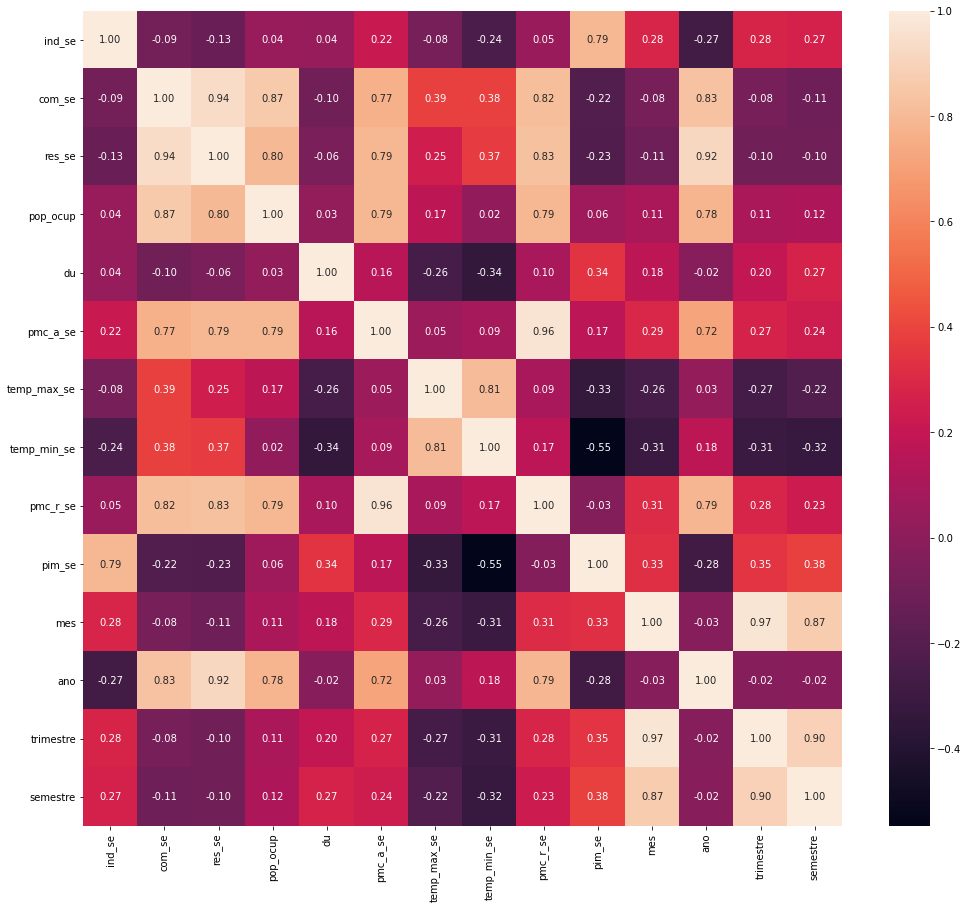

In [45]:
# creating the 'df3_num' dataframe with only numerical features from the 'df3' dataframe, which are not categorical features
df3_num = df3.select_dtypes(include= ['float64', 'int64', 'int32'])

# filtering in the 'df3_num' dataframe the features that we think that have a significant relation with the 'ind_se' label and 
# the 'ind_se' label too
df3_num = df3_num[['ind_se', 'com_se', 'res_se', 'pop_ocup', 'du', 'pmc_a_se', 'temp_max_se', 'temp_min_se', 'pmc_r_se', 'pim_se', \
                 'mes', 'ano', 'trimestre', 'semestre']]

# creating a figure and adjusting its size
plt.figure(figsize= (17, 15))

# creating a correlation matrix from 'df3_num' dataframe
corre_num = df3_num.corr(method = 'pearson')

# creating a heatmap graph using the correlation matrix 'corre_num' as data
ax = sns.heatmap(corre_num, annot = True, fmt= '.2f')

# plotting the heat map
ax;

# saving the graph as 'num_features_relations_2' in the storytelling folder  
plt.savefig('../storytelling/num_features_relations_2.png')

***
**As seen above:** 
<br>

**There are some numerical features that don't have a considerable impact over `ind_se` label value:**

- **`pop_ocup`** (4% correlation)
- **`du`** (4% correlation)
- **`pmc_r_se`** (5% correlation)
- **`temp_max_se`** (8% correlation)
- **`com_se`** (9% correlation)

As said before, I will not remove them for now. This will be done after I evaluate the features-label correlation with some feature select models to help me select the best features for the ML model.

### <font color=green size= 4>4.2.2 CATEGORICAL FEATURES CORRELATION </font>
***

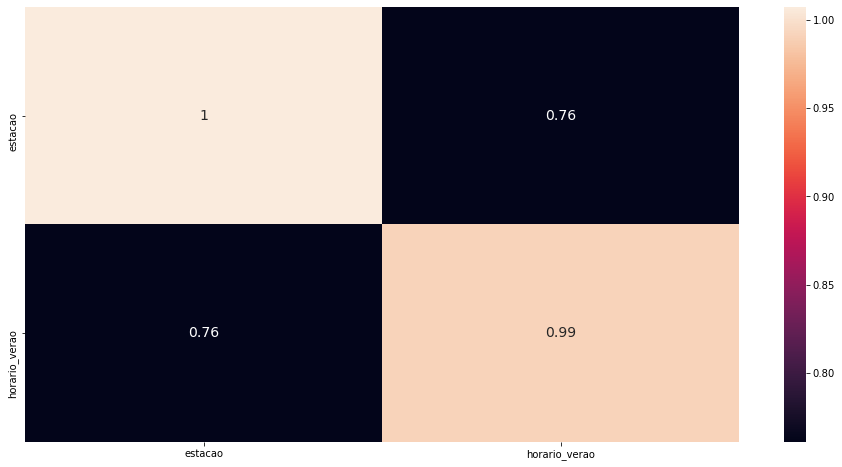

In [46]:
# creating the 'df3_cat' dataframe with only numerical features from the 'df3' dataframe, which are categorical features
df3_cat = df3[['estacao', 'horario_verao']]

# making all the possible combinations between the ategorical variables
a1 = cramer_v(df3_cat['estacao'], df3_cat['estacao'])
a2 = cramer_v(df3_cat['estacao'], df3_cat['horario_verao'])
a3 = cramer_v(df3_cat['horario_verao'], df3_cat['estacao'])
a4 = cramer_v(df3_cat['horario_verao'], df3_cat['horario_verao'])

# building the 'corre_cat' dataframe to make the correlations
corre_cat = pd.DataFrame({'estacao': [a1, a2],
                          'horario_verao': [a3, a4]})

# setting index equal to columns
corre_cat = corre_cat.set_index(corre_cat.columns)

# using the variable ax for single a axes
fig, ax = plt.subplots()

# setting the figure size in inches
ax.figure.set_size_inches(16, 8)

# plotting the heatmap
sns.heatmap(corre_cat, annot=True, annot_kws={"fontsize":14})

# displaying the plot
plt.show()

# saving the graph as 'cat_features_relations' in the storytelling folder  
fig.savefig('../storytelling/cat_features_relations.png')

***
**As seen above:**

There are only two categorical features in our dataset: **`estacao`** and **`horario_verao`**.

They have a significant correlation (76%), which makes sense, because the daylight saving time in Brazil covers almost all the summer season period.

This is something that we will need to keep in mind when select the best features for our ML model.

# <font color=green size= 6> <b>5. DATA PREPARATION </font></b>
***

In [47]:
# creating the 'df4' dataframe as a copy from the original 'df3' dataframe, to work with
df4 = df3.copy()

# filtering in the 'df4' dataframe the features that we think that have a significant relation with the 'ind_se' label and the
# 'ind_se' label
df4 = df4[['data', 'ind_se', 'com_se', 'res_se', 'pop_ocup', 'du', 'pmc_a_se', 'temp_max_se', 'temp_min_se', \
           'pmc_r_se', 'pim_se', 'mes', 'ano', 'trimestre', 'semestre', 'estacao', 'horario_verao']]

# displaying the 'df4' first 5 dataframe's observations  
df4.head()

,data,ind_se,com_se,res_se,pop_ocup,du,pmc_a_se,temp_max_se,temp_min_se,pmc_r_se,pim_se,mes,ano,trimestre,semestre,estacao,horario_verao
0,2004-01-01,6977.47082,2450.45329,3694.38561,75777.696766,21,50.755550,27.618279,20.365591,47.369,75.454326,1,2004,1,1,Verao,1
1,2004-02-01,7084.62266,2396.96520,3511.54126,76464.330910,18,48.108250,28.047126,20.089655,45.738,72.953183,2,2004,1,1,Verao,1
2,2004-03-01,7087.61326,2402.52074,3629.45543,75925.410718,23,54.134850,28.181720,19.749463,49.252,83.942665,3,2004,1,1,Verao,0
3,2004-04-01,7384.53963,2580.91388,3733.86311,77102.272116,20,52.015075,27.537778,19.650000,49.755,79.495481,4,2004,2,1,Outono,0
4,2004-05-01,7258.30672,2344.08400,3537.26872,77353.867496,21,54.345225,25.391398,17.573118,51.849,84.187962,5,2004,2,1,Outono,0


## <font color=green size= 5>5.1 RESCALE AND NORMALIZE NUMERICAL FEATURES </font>
***

In the section we will executed the numerical variables rescaling and/or normalization. For this, these variables outliers must be known, to choose the best method to be applied.

**The techniques that will be used:**

- **RobustScaler:** Robust in the presence of outliers, will be applied at features that have a significant amount of outliers. 

- **MinMaxScaler:** Sensitive in the presence of outliers, will be applied at features that don't have a significant amount of outliers.
<br>

Lets check the features values distribution that we selected in section 4.2 as candidates to be our ML model features, excluding the date features (month, year, semester...) because we will apply another transformation on them.

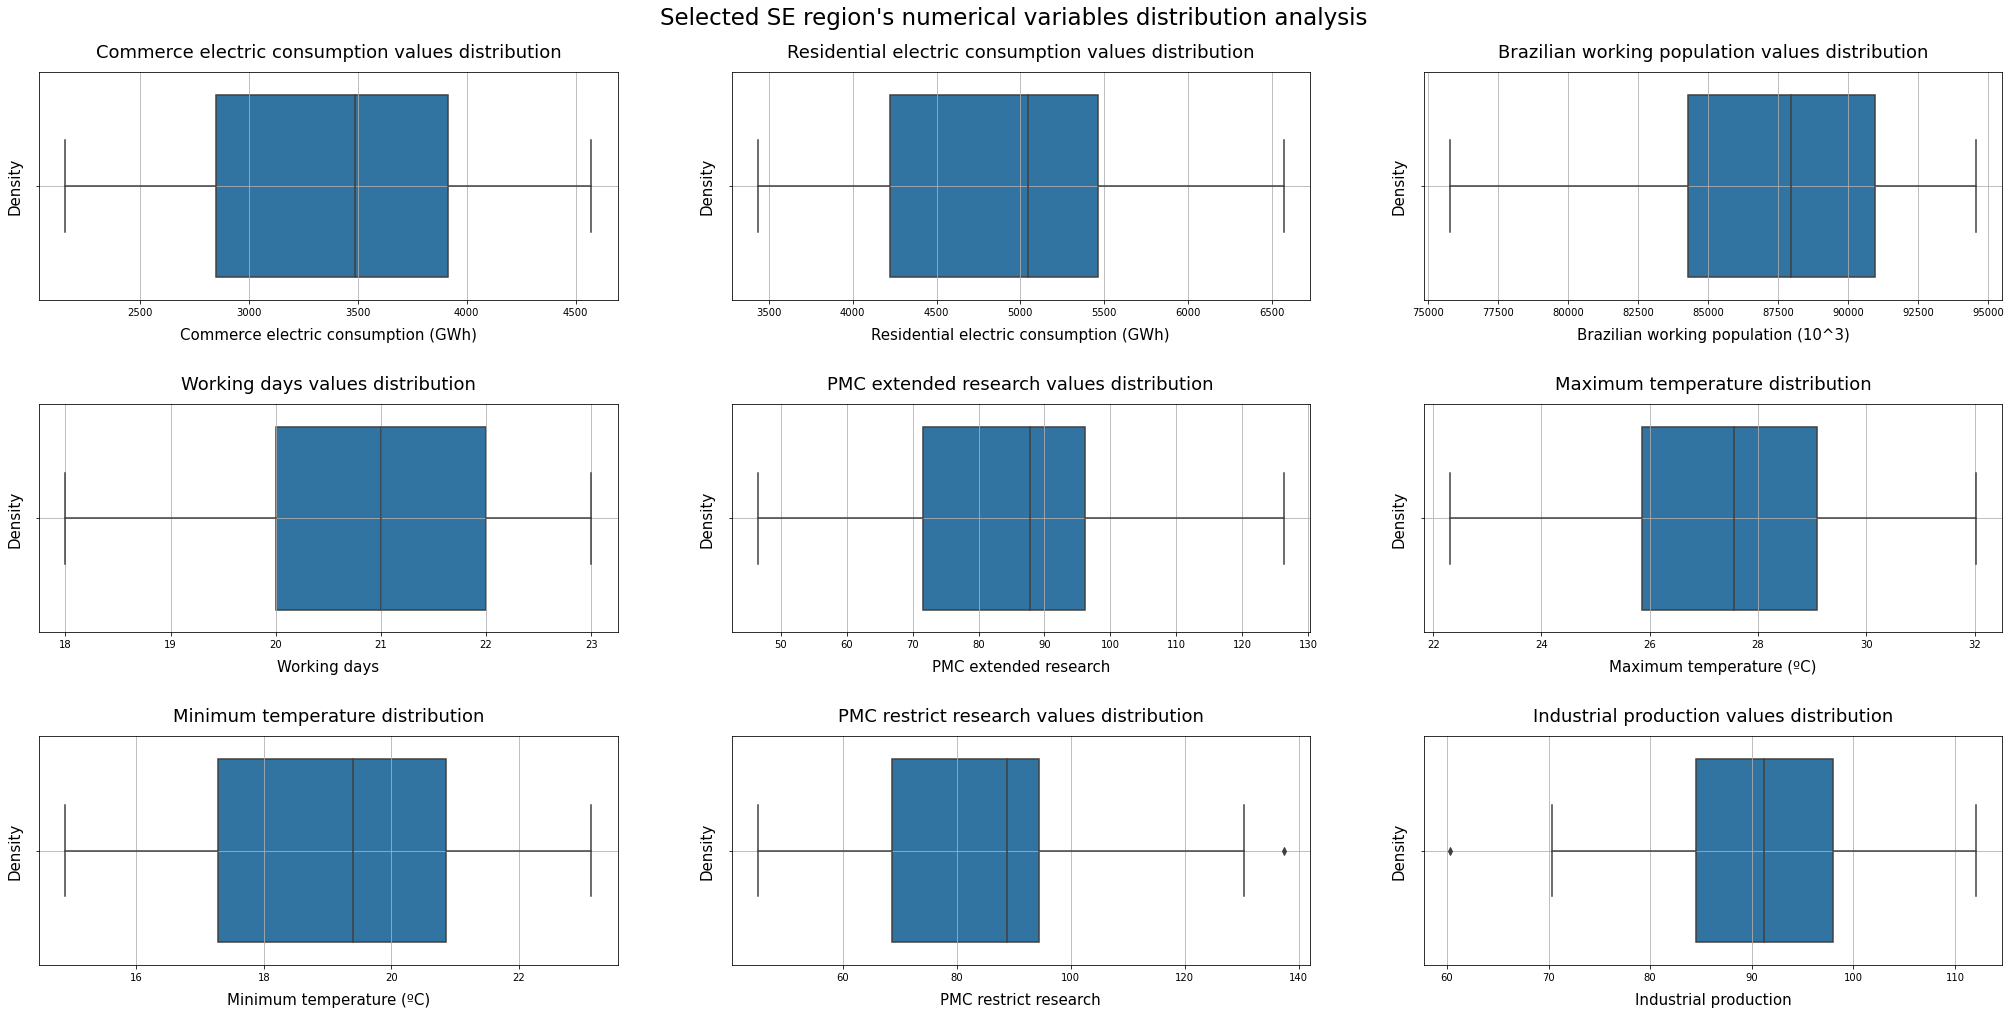

In [48]:
# creating a figure with 3 rows and 3 columns of axes
fig, axes = plt.subplots(3, 3, figsize= (30, 15))
fig.tight_layout(pad=8.3)

# setting the figure title and size
fig.suptitle("Selected SE region's numerical variables distribution analysis", size= 23)

# setting 0,0 axes graph, title, labels and sizes
sns.boxplot(ax= axes[0,0], x= df4['com_se'])
axes[0,0].set_title("Commerce electric consumption values distribution", size= 18, pad= 15)
axes[0,0].set_xlabel("Commerce electric consumption (GWh)", size= 15, labelpad= 10)
axes[0,0].set_ylabel('Density', size= 15, labelpad= 10)
axes[0,0].grid()

# setting 0,1 axes graph, title, labels and sizes
sns.boxplot(ax= axes[0,1], x= df4['res_se'])
axes[0,1].set_title("Residential electric consumption values distribution", size= 18, pad= 15)
axes[0,1].set_xlabel("Residential electric consumption (GWh)", size= 15, labelpad= 10)
axes[0,1].set_ylabel('Density', size= 15, labelpad= 10)
axes[0,1].grid()

# setting 0,2 axes graph, title, labels and sizes
sns.boxplot(ax= axes[0,2], x= df4['pop_ocup'])
axes[0,2].set_title("Brazilian working population values distribution", size= 18, pad= 15)
axes[0,2].set_xlabel("Brazilian working population (10^3)", size= 15, labelpad= 10)
axes[0,2].set_ylabel('Density', size= 15, labelpad= 10)
axes[0,2].grid()

# setting 1,0 axes graph, title, labels and sizes
sns.boxplot(ax= axes[1,0], x= df4['du'])
axes[1,0].set_title("Working days values distribution", size= 18, pad= 15)
axes[1,0].set_xlabel("Working days", size= 15, labelpad= 10)
axes[1,0].set_ylabel('Density', size= 15, labelpad= 10)
axes[1,0].grid()

# setting 1,1 axes graph, title, labels and sizes
sns.boxplot(ax= axes[1,1], x= df4['pmc_a_se'])
axes[1,1].set_title("PMC extended research values distribution", size= 18, pad= 15)
axes[1,1].set_xlabel("PMC extended research", size= 15, labelpad= 10)
axes[1,1].set_ylabel('Density', size= 15, labelpad= 10)
axes[1,1].grid()

# setting 1,2 axes graph, title, labels and sizes
sns.boxplot(ax= axes[1,2], x= df4['temp_max_se'])
axes[1,2].set_title("Maximum temperature distribution", size= 18, pad= 15)
axes[1,2].set_xlabel("Maximum temperature (ºC)", size= 15, labelpad= 10)
axes[1,2].set_ylabel('Density', size= 15, labelpad= 10)
axes[1,2].grid()

# setting 2,0 axes graph, title, labels and sizes
sns.boxplot(ax= axes[2,0], x= df4['temp_min_se'])
axes[2,0].set_title("Minimum temperature distribution", size= 18, pad= 15)
axes[2,0].set_xlabel("Minimum temperature (ºC)", size= 15, labelpad= 10)
axes[2,0].set_ylabel('Density', size= 15, labelpad= 10)
axes[2,0].grid()

# setting 2,1 axes graph, title, labels and sizes
sns.boxplot(ax= axes[2,1], x= df4['pmc_r_se'])
axes[2,1].set_title("PMC restrict research values distribution", size= 18, pad= 15)
axes[2,1].set_xlabel("PMC restrict research", size= 15, labelpad= 10)
axes[2,1].set_ylabel('Density', size= 15, labelpad= 10)
axes[2,1].grid()

# setting 2,2 axes graph, title, labels and sizes
sns.boxplot(ax= axes[2,2], x= df4['pim_se'])
axes[2,2].set_title("Industrial production values distribution", size= 18, pad= 15)
axes[2,2].set_xlabel("Industrial production", size= 15, labelpad= 10)
axes[2,2].set_ylabel('Density', size= 15, labelpad= 10)
axes[2,2].grid()

# saving the graph as 'selected_num_features_distribution' in the storytelling folder  
fig.savefig('../storytelling/selected_num_features_distribution.png')

***
**As seen above:**
    
Neither of the numerical features that we analyzed above have a significant amount of outliers, some of them don't even have outliers. This is expected, as we saw in section 2.6, their kurtosis values are closer to zero, an indicator of a light amount of outliers.

In [49]:
# instantiating MinMaxScaler method as 'mms'
mms = MinMaxScaler()

# creating the 'features' list with the features names that we want to iterating over
features = ['com_se', 'res_se', 'pop_ocup', 'du', 'pmc_a_se', 'temp_max_se', 'temp_min_se', 'pmc_r_se', 'pim_se']

# iterating over all the numerical features that we selected as candidates to our ML model features
for feature in features:
    
    # rescaling the dataset's analyzed feature values 
    df4[feature] = mms.fit_transform(df4[[feature]].values)

    # saving the analyzed feature rescaling method
    pickle.dump(mms, open(f'../parameters/{feature}_scaler.pkl', 'wb'))

## <font color=green size= 5>5.2 ENCODE CATEGORICAL FEATURES </font>
***

### <font color=green size= 4>5.2.1 BINARY CATEGORICAL FEATURES </font>
***

In [50]:
# creating the 'semesters' dictonary to replace the 'semestre' column type to a numeral representative
semesters = {1: 0, 2: 1}

# transforming the 'semestre' column values into a numeral representative
df4['semestre'] = df4['semestre'].map(semesters)

### <font color=green size= 4>5.2.2 NOMINAL CATEGORICAL FEATURES </font>
***

In [51]:
# instantiating the OneHotEncoder method as 'ohe'
ohe = OneHotEncoder(cols= ['estacao'], use_cat_names= True)

# transforming the 'df4' datafrane with the 'ohe' method. It will only be applied over the object type columns ('estacao')
df4 = ohe.fit_transform(df4)

# saving the OneHotEncoder trained method
pickle.dump(ohe, open('../parameters/onehotencoder_estacao.pkl', 'wb'))

# renaming the columns created by the OneHotEncoder method in the 'df4' dataframe
df4.rename(columns = {'estacao_Verao':     'verao', 
                      'estacao_Outono':    'outono', 
                      'estacao_Inverno':   'inverno',
                      'estacao_Primavera': 'primavera'}, inplace= True)

### <font color=green size= 4>5.2.3 ORDINAL CATEGORICAL FEATURES </font>
***

There are no ordinal categorical features in our dataset.

## <font color=green size= 5>5.3 DATE FEATURES TRANSFORMATION  </font>
***

In this section we will executed the date type features transformation. This because date in general (days, weeks, months...) are cyclical and we are dealing with a regression method. 

So, for an example, if we let **`mes`** column values between 1 and 12, we are saying that 12th month is 12 times farer from the 1st month than the 2nd month to the 1st month, which is a false affirmative. When analyzing it as a cyclical event, both have the same 'distance' to the 1st month.

So, to avoid this behavior, we will transform all date features into a sine values, creating cyclical date features to replace the original ones.

In [52]:
# creating the 'mes_seno' column in the 'df4' dataframe by transforming the 'mes' column values into sine values
df4['mes_seno'] = df4['mes'].apply(lambda x: np.sin(x *(2. * np.pi / 12)))

# creating the 'trimestre_seno' column in the 'df4' dataframe by transforming the 'trimestre' column values into sine values
df4['trimestre_seno'] = df4['trimestre'].apply(lambda x: np.sin(x *(2. * np.pi / 4)))

# removing the 'mes' and 'trimestre' columns from the 'df4' dataframe
df4.drop(columns= ['mes', 'trimestre'], inplace= True)

## <font color=green size= 5>5.4 TRANSFORM LABEL (response feature)  </font>
***

As seen in section 2.6, the **`ind_se`** label have a kurtosis and skew values pretty closer to zero, indicating a light amount of outliers and possibly a normal distribution of its values.

Lets check it.

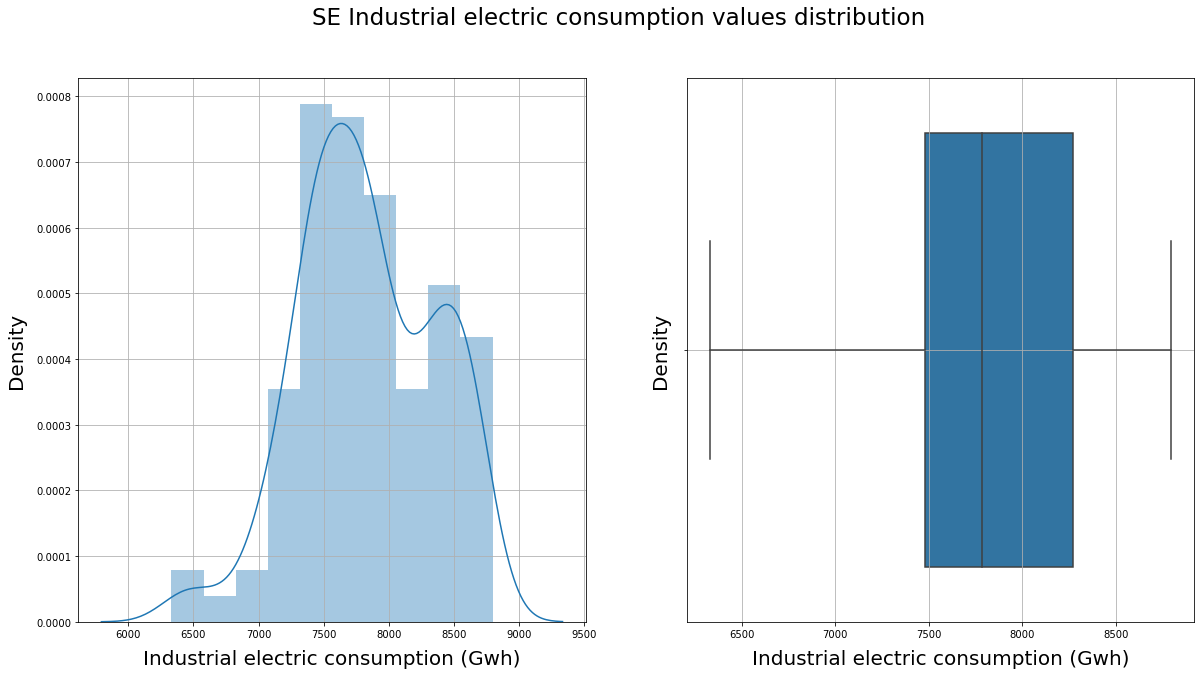

In [53]:
# creating a figure with 1 rows and 2 columns of axes
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# setting the figure title and size
fig.suptitle("SE Industrial electric consumption values distribution", size= 23)

# setting first graph, title, labels, ticks and sizes
sns.distplot(ax= axes[0], x= df4['ind_se'], kde= True)
axes[0].set_xlabel('Industrial electric consumption (Gwh)', size= 20, labelpad= 10)
axes[0].set_ylabel('Density', size= 20, labelpad= 10)
axes[0].grid()

# setting second graph, title, labels, ticks and sizes
sns.boxplot(ax= axes[1], x= df4['ind_se'])
axes[1].set_xlabel('Industrial electric consumption (Gwh)', size= 20, labelpad= 10)
axes[1].set_ylabel('Density', size= 20, labelpad= 10)
axes[1].grid()

***
**As seen above:**

- The **`ind_se`** label have something similar to a normal distribution, with a peak between 82500 and 8500 Gwh, but it can't be considered a bimodal distribution.
<br>

- Also, we can confirm that **`ind_se`** don't have outliers, which is good.
<br>

Based on this, I could try to apply a method trying to fit it closer to a normal distribution, but it something that I will keep to do in another CRISP-DM cycle.

For now, I will apply a logarithmic transformation over the **`ind_se`** label, only to approximate its values magnitude to features magnitudes. 

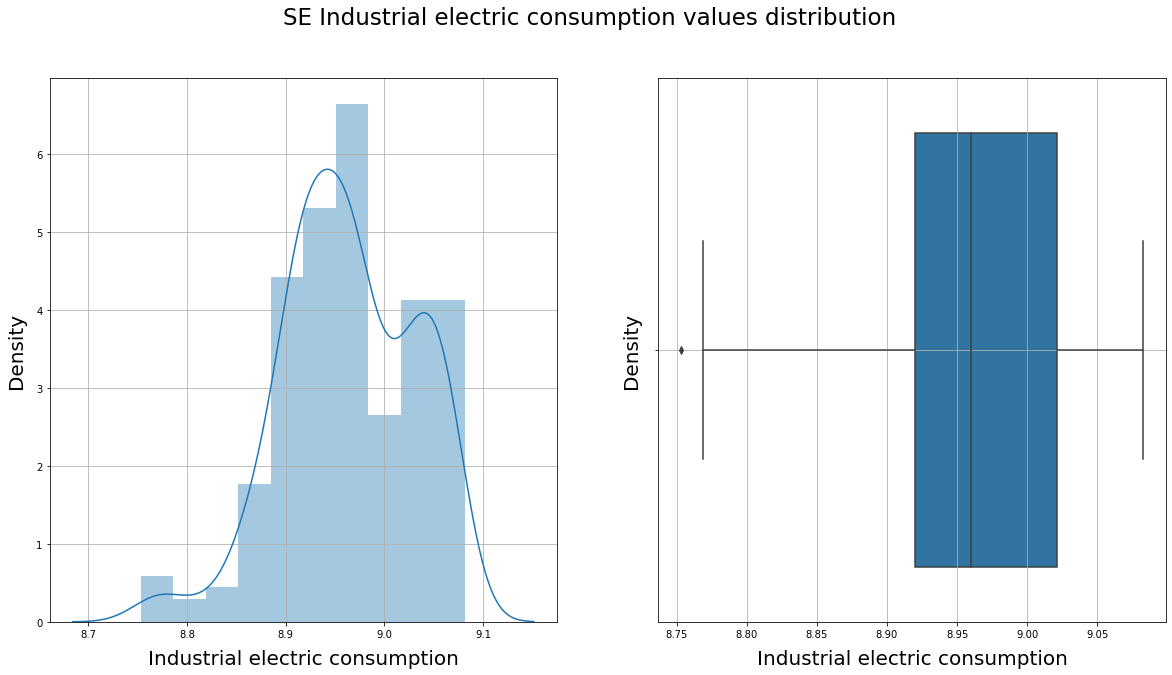

In [54]:
# transforming the 'ind_se' column values into logarithmic values
df4['ind_se'] = np.log1p(df4['ind_se'])

# creating a figure with 1 rows and 2 columns of axes
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# setting the figure title and size
fig.suptitle("SE Industrial electric consumption values distribution", size= 23)

# setting first graph, title, labels, ticks and sizes
sns.distplot(ax= axes[0], x= df4['ind_se'], kde= True)
axes[0].set_xlabel('Industrial electric consumption', size= 20, labelpad= 10)
axes[0].set_ylabel('Density', size= 20, labelpad= 10)
axes[0].grid()

# setting second graph, title, labels, ticks and sizes
sns.boxplot(ax= axes[1], x= df4['ind_se'])
axes[1].set_xlabel('Industrial electric consumption', size= 20, labelpad= 10)
axes[1].set_ylabel('Density', size= 20, labelpad= 10)
axes[1].grid()

# <font color=green size= 6> <b>6. FEATURE SELECTION </font></b>
***

In [55]:
# creating the 'df5' dataframe as a copy from the original 'df4' dataframe, to work with
df5 = df4.copy()

# displaying the 'df5' first 5 dataframe's observations  
df5.head()

,data,ind_se,com_se,res_se,pop_ocup,du,pmc_a_se,temp_max_se,temp_min_se,pmc_r_se,pim_se,ano,semestre,verao,outono,inverno,primavera,horario_verao,mes_seno,trimestre_seno
0,2004-01-01,8.850585,0.120624,0.083159,0.000000,0.6,0.052996,0.546347,0.664424,0.024769,0.292546,2004,0,1,0,0,0,1,0.500000,1.000000e+00
1,2004-02-01,8.865823,0.098450,0.024889,0.036573,0.0,0.019791,0.590519,0.630955,0.007089,0.244191,2004,0,1,0,0,0,1,0.866025,1.000000e+00
2,2004-03-01,8.866245,0.100753,0.062467,0.007868,1.0,0.095383,0.604382,0.589691,0.045181,0.456651,2004,0,1,0,0,0,0,1.000000,1.000000e+00
3,2004-04-01,8.907279,0.174707,0.095740,0.070553,0.4,0.068795,0.538055,0.577627,0.050634,0.370673,2004,0,0,1,0,0,0,0.866025,1.224647e-16
4,2004-05-01,8.890040,0.076528,0.033088,0.083954,0.6,0.098022,0.316972,0.325715,0.073333,0.461393,2004,0,0,1,0,0,0,0.500000,1.224647e-16


## <font color=green size= 5>6.1 SPLIT TRAIN & TEST DATASET BY TIME SERIE </font>
***

In [56]:
# priting the 'df5' dataframe maximum and minimum 'data' column values
print(f"The minimum date is: {df5['data'].min()}")
print(f"The maximum date is: {df5['data'].max()}")

The minimum date is: 2004-01-01 00:00:00
The maximum date is: 2021-02-01 00:00:00


In [57]:
# filtering the 'df5' dataframe by the date, creating a training dataset. Then splitting this dataset by the features and labels
x_train_time = df5[df5['data'] < (df5['data'].max() - relativedelta(months=+22))]
y_train_time = df5[df5['data'] < (df5['data'].max() - relativedelta(months=+22))]['ind_se']

# filtering the 'df5' dataframe by the date, creating a testing dataset. Then splitting this dataset by the features and labels
x_test_time = df5[df5['data'] >= (df5['data'].max() - relativedelta(months=+22))]
y_test_time = df5[df5['data'] >= (df5['data'].max() - relativedelta(months=+22))]['ind_se']

# printing the training and testing datasets maximum's and minimum's 'data' column values
print('Traning Min Date: {}'.format(x_train_time['data'].min()))
print('Traning Max Date: {}'.format(x_train_time['data'].max()))
print('\nTest Min Date: {}'.format(x_test_time['data'].min()))
print('Test Max Date: {}'.format(x_test_time['data'].max()))

Traning Min Date: 2004-01-01 00:00:00
Traning Max Date: 2019-03-01 00:00:00

Test Min Date: 2019-04-01 00:00:00
Test Max Date: 2021-02-01 00:00:00


## <font color=green size= 5>6.2 BORUTA BEST FEATURES SELECTION </font>
***

**Boruta library:** <a href="https://pypi.org/project/Boruta/">Here</a></font>

In [58]:
# instantiating Random Forest Regressor as the model that will be checked by the boruta model
rfr_model = RandomForestRegressor(n_jobs = -1, random_state= 301)

# defining the training datasets
x_train_boruta = x_train_time.drop(columns= ['data', 'ind_se']).values
y_train_boruta = y_train_time.values.ravel()

# instantiating the BorutaPy model as 'boruta'
boruta = BorutaPy(rfr_model, n_estimators= 'auto', verbose= False, random_state= 301)

# training the 'boruta' model with the training datasets
boruta.fit(x_train_boruta, y_train_boruta)

BorutaPy(estimator=RandomForestRegressor(n_estimators=31, n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x19C669A9140),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x19C669A9140, verbose=False)

In [59]:
# creating and manipulation a list with the features selected by the 'boruta' model
cols = boruta.support_.tolist()
boruta_selected_features = x_train_time.drop(columns= ['data', 'ind_se']).iloc[:, cols].columns.to_list()

# displaying the selected features by 'boruta' model
print('Boruta selected features:')
boruta_selected_features

Boruta selected features:


['pop_ocup', 'pmc_a_se', 'temp_min_se', 'pim_se', 'ano']

***
**As seen above:**

Boruta model selected only 5 features as the best features to use in our ML model:

- **`pop_ocup`**
- **`pmc_a_se`**
- **`temp_min_se`**
- **`pim_se`**
- **`ano`**

All of them, excluding **`pop_ocup`**, are the numerical features with the highest correlation with the **`ind_se`** label, as we saw in the correlation matrix in section 4.2.2.

## <font color=green size= 5>6.3 RANDOM FOREST REGRESSOR BEST FEATURES SELECTION </font>
***

Random forest features importance:


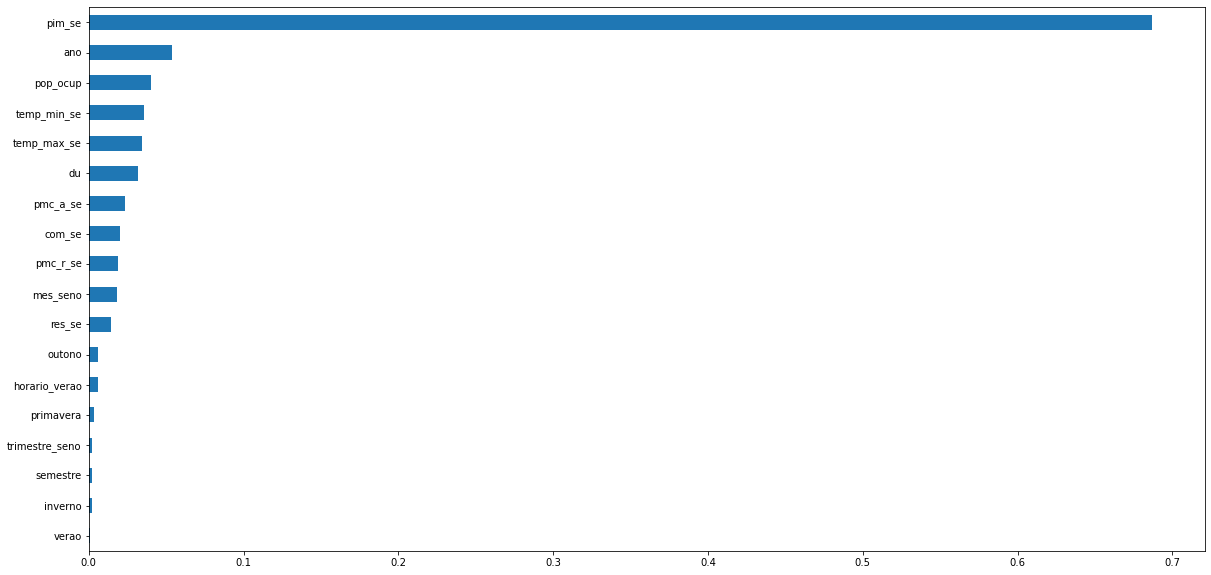

In [60]:
# instantiating Random Forest Regressor as 'rfr'
rfr = RandomForestRegressor(n_estimators= 100, n_jobs= -1, random_state= 301)

# defining the training datasets
x_train_rfr = df5.drop(columns= ['data', 'ind_se'])
y_train_rfr = df5['ind_se']

# training the 'rfr' model with the training datasets
rfr.fit(x_train_rfr, y_train_rfr)

# creating a figure with 1 rows and 1 columns of axes
plt.figure(figsize= (20, 10))

# creating a series and plot the 'rfr' model's features importance
feat_importances = pd.Series(rfr.feature_importances_, index= x_train_rfr.columns)
print('Random forest features importance:')
feat_importances.sort_values().plot(kind= 'barh');

***
**As seen above:**

Random Forest Regressor model indicates that the most important features are:

- **`pim_se`**
- **`ano`**
- **`pop_ocup`**
- **`temp_min_se`**
- **`temp_max_se`**
- **`du`**

Comparing it to the correlation matrix that we created in section 4.2.2 and the Boruta model in section 6.2, we can see that **`pim_se`**, **`temp_min_se`**, **`ano`** and **`pmc_a_se`** possibly have a considerable impact over the **`ind_se`** label.

Something that only Random Forest Regressor model and Boruta model accused is that **`pop_ocup`** have a significant impact over the **`ind_se`** label, but the correlation matrix in section 4.2.2 didn't. We need to remember that the **`pop_ocup`** feature have a good correlation with the Brazil total industry electric consumption, as we saw in section 4.1.7.

Lets check it with another feature selection model, the RFE.

## <font color=green size= 5>6.4 RECURSIVE FEATURE ELIMINATION (RFE) FEATURES SELECTION </font>
***

In [61]:
# instantiating Random Forest Regressor as the model that will be checked by the RFE model
rfr = RandomForestRegressor(n_estimators= 100, n_jobs= -1, random_state= 301)

# defining the training datasets
x_train_rfe = df5.drop(columns= ['data', 'ind_se'])
y_train_rfe = df5[['ind_se']]

# instatiating the RFE model as 'rfe' and that we want RFE to select the 8 best features
rfe = RFE(rfr, n_features_to_select= 8, step= 1)

# training the RFE model
rfe = rfe.fit(x_train_rfe, y_train_rfe)

# ranking the best features selected by the 'rfe' model
selected_features_T_F = rfe.support_.tolist()

# getting the selected features columns names
features_columns = x_train_rfe.columns

# instantiating 'rfe_selected_features' as an empty list
rfe_selected_features = []

# inserting the selected features into the 'rfe_selected_features'
for binary, feature in zip(selected_features_T_F, features_columns):
    if binary == True:
        rfe_selected_features.append(feature)

# displaying the selected features by RFE
print('RFE selected features:')
rfe_selected_features

RFE selected features:


['pop_ocup',
 'du',
 'pmc_a_se',
 'temp_max_se',
 'temp_min_se',
 'pim_se',
 'ano',
 'mes_seno']

***
**As seen above:**

The 8 best features selected by the RFE model are:

- **`pop_ocup`**
- **`du`**
- **`pmc_a_se`**
- **`temp_max_se`**
- **`temp_min_se`**
- **`pim_se`**
- **`ano`**
- **`mes_seno`**

By looking to the selected features by the RFE, we can see that **`pop_ocup`** were selected, ensuring that its probably a significant feature.

## <font color=green size= 5>6.5 MANUAL BEST FEATURES SELECTION </font>
***

In this section I will only consider variables that showed as a significant feature at least in 3 of the features selection methods: 

- Correlation Matrix method
- Boruta model
- Random Forest Regressor model
- RFE model

In [62]:
# creating the 'manual_selected_features' list with the final selected features to apply in our ML model
manual_selected_features = ['pop_ocup', 'pim_se', 'temp_min_se', 'ano','pmc_a_se', 'mes_seno']

# creating the 'manual_selected_features_cross' list with only the final selected features, the 'data' feature and the 'ind_se'
# label, for the cross validation method
manual_selected_features_cross = manual_selected_features.copy()
manual_selected_features_cross.extend(['data', 'ind_se']) 

## <font color=green size= 5>6.6 SPLIT TRAIN & TEST DATASET BY FEATURES </font>
***

In [63]:
# defining the training datasets
x_train = x_train_time[manual_selected_features]
y_train = y_train_time.copy()

# defining the testing datasets
x_test =  x_test_time[manual_selected_features]
y_test =  y_test_time.copy()

# defining the cross validation training/testing dataset
x_train_test_cross = df5[manual_selected_features_cross]

## <font color=green size= 5>6.7 CHECKPOINT </font>
***

In [64]:
# saving the'df5' dataframe
pickle.dump(df5, open('../parameters/df5.pkl', 'wb'))

# saving the manual selected columns features
pickle.dump(manual_selected_features, open('../parameters/manual_selected_features.pkl', 'wb'))

# saving the manual selected columns features for cross validation
pickle.dump(manual_selected_features_cross, open('../parameters/manual_selected_features_cross.pkl', 'wb'))

# saving the training datasets with the 'data' column
pickle.dump(x_train_time, open('../parameters/x_train_time.pkl', 'wb'))
pickle.dump(y_train_time, open('../parameters/y_train_time.pkl', 'wb'))

# saving the testing datasets without the 'data' column
pickle.dump(x_test_time, open('../parameters/x_test_time.pkl', 'wb'))
pickle.dump(y_test_time, open('../parameters/y_test_time.pkl', 'wb'))

# saving the training datasets without the 'data' column
pickle.dump(x_train, open('../parameters/x_train.pkl', 'wb'))
pickle.dump(y_train, open('../parameters/y_train.pkl', 'wb'))

# saving the testing datasets without the 'data' column
pickle.dump(x_test, open('../parameters/x_test.pkl', 'wb'))
pickle.dump(y_test, open('../parameters/y_test.pkl', 'wb'))

# saving the cross validation training/testing dataset
pickle.dump(x_train_test_cross, open('../parameters/x_train_test_cross.pkl', 'wb'))

In [65]:
# loading the'df5' dataframe
df5 = pickle.load(open('../parameters/df5.pkl', 'rb'))

# loading the manual selected columns features
manual_selected_features = pickle.load(open('../parameters/manual_selected_features.pkl', 'rb'))

# loading the manual selected columns features for cross validation
manual_selected_features_cross = pickle.load(open('../parameters/manual_selected_features_cross.pkl', 'rb'))

# loading the training datasets with the 'data' column
x_train_time = pickle.load(open('../parameters/x_train_time.pkl', 'rb'))
y_train_time = pickle.load(open('../parameters/y_train_time.pkl', 'rb'))

# loading the testing datasets without the 'data' column
x_test_time = pickle.load(open('../parameters/x_test_time.pkl', 'rb'))
y_test_time = pickle.load(open('../parameters/y_test_time.pkl', 'rb'))

# loading the training datasets without the 'data' column
x_train = pickle.load(open('../parameters/x_train.pkl', 'rb'))
y_train = pickle.load(open('../parameters/y_train.pkl', 'rb'))

# loading the testing datasets without the 'data' column
x_test = pickle.load(open('../parameters/x_test.pkl', 'rb'))
y_test = pickle.load(open('../parameters/y_test.pkl', 'rb'))

# loading the cross validation training/testing dataset
x_train_test_cross = pickle.load(open('../parameters/x_train_test_cross.pkl', 'rb'))

# <font color=green size= 6> <b>7. MACHINE LEARNING </font></b>
***

In this section, we will finally apply the Machine Learning models in which the motivation to use these algorithms is to build an intelligent model to predict the Brazil Southeast region's industrial electric consumption for the next 24 months. For this, we will use following supervised task regressive models:

- Linear Regression
- Linear Regression Regularized model (Lasso)
- Random Forest Regressor 
- XGBoost Regressor
- CatBoost Regressor

**DISCLAIMER**: The dataset that 4I company sent to me  have projections for the next 22 months, not 24 months. With the sort time that I have, I will assume that the objective is to predict the electrical consumption for the next 22 months, and not for 24 months, instead of trying to interpolate these features projections for the 2 missing months.

## <font color=green size= 5>7.1 INSTANTIATE MODELS </font>
***

In [66]:
# instantiating the LinearRegression model as 'lr'
lr = LinearRegression()

# instantiating the Lasso model as 'lrr'
lrr = Lasso(alpha= 0.01, 
            random_state= 301)

# instantiating the RandomForestRegressor model as 'rfr'
rfr = RandomForestRegressor(n_estimators= 100, n_jobs= -1, random_state= 301)

# instantiating the XGBRegressor model as 'xgbr'
xgbr = xgb.XGBRegressor(objective= 'reg:squarederror',
                          n_estimators= 100, 
                          eta= 0.01, 
                          max_depth= 10, 
                          subsample= 0.7,
                          colsample_bytree= 0.9,
                          random_state= 301)

# instantiating the CatBoostRegressor model as 'catr'
catr = CatBoostRegressor(random_state= 301, verbose= False)

## <font color=green size= 5>7.2 MODELS TRAINING AND PERFORMANCE RESULTS </font>
***

For this section, we will create an average model, which will serve as a baseline to compare the regressive models metrics. 

This average/dummy model consist in to consider all electrical consumption predictions (**`ind_se`**) as the mean value of all the historical observations electrical consumption values (**`ind_se`**).

In [67]:
# creating the 'y_test_avg_ind_se' as an empty dataframe
y_test_avg_ind_se = pd.DataFrame()

# creating the 'ind_se' column in the 'y_test_avg_ind_se' dataframe
y_test_avg_ind_se['ind_se'] = y_test.copy()

# creating the 'predictions' column in the 'y_test_avg_ind_se' dataframe and filling all columns with the 'ind_se' column mean
# value
y_test_avg_ind_se['predictions'] = y_test_avg_ind_se['ind_se'].mean()

# calculating all evaluated metrics for the average model
MAE   = mean_absolute_error(np.expm1(y_test_avg_ind_se['ind_se']), np.expm1(y_test_avg_ind_se['predictions']))
MAPE  = mean_absolute_percentage_error(np.expm1(y_test_avg_ind_se['ind_se']), np.expm1(y_test_avg_ind_se['predictions']))
RMSE  = np.sqrt(mean_squared_error(np.expm1(y_test_avg_ind_se['ind_se']), np.expm1(y_test_avg_ind_se['predictions'])))
RMSPE = np.sqrt(np.mean(np.square((np.expm1(y_test_avg_ind_se['ind_se']) - np.expm1(y_test_avg_ind_se['predictions'])) / np.expm1(y_test_avg_ind_se['ind_se']))))
    
# creating the 'baseline_model_metrics' dataframe to display the average/dummy model resulting metrics
baseline_model_metrics = pd.DataFrame({'Model': 'Baseline Model',
                                       'MAE':    MAE,
                                       'MAPE':   MAPE,
                                       'RMSE':   RMSE,
                                       'RMSPE':  RMSPE}, index=[0])

# displaying the 'baseline_model_metrics' dataframe's content 
baseline_model_metrics

,Model,MAE,MAPE,RMSE,RMSPE
0,Baseline Model,324.127304,0.045568,423.640756,0.062352


***
**As seen above:**
    
- The average model has a mean absolute error value of 324.13 Gwh, which we don't know the direction.
<br>

- The average model has a mean absolute percentage error value of 4.60%, which we don't know the direction.
<br>

- The average model has a root mean square error value of 423.64 Gwh, which we don't know the direction. Its values will always be higher than the MAE, because it penalizes the outliers errors values by increasing their coefficient. **This is the metric that we will use to validate the evaluated models until we find the final model.**
<br>

- The average model has a root mean square percentage error value of 6.20%, which we don't know the direction. 

In [68]:
# creating the 'models' list with the evaluated models instances
models =[lr, lrr, rfr, xgbr, catr]

# getting the trained models performance metrics for 'y_test' dataset (using the helper functions at section 1.2)
df_models_performance = get_models_performance(x_train, x_test, np.ravel(y_train), np.ravel(y_test), models)   

# resetting the 'df_models_performance' dataset index
df_models_performance.reset_index(inplace= True, drop= True)

# displaying the 'df_models_performance' dataframe content and hightlight the best (minimum) value for each metrics
df_models_performance.style.highlight_min(color= 'yellow')

Training LinearRegression...
Training Lasso...
Training RandomForestRegressor...
Training XGBRegressor...
Training CatBoostRegressor...


,model,MAE,MAPE,RMSE,RMSPE
0,LinearRegression,242.818105,0.033733,328.614145,0.047251
1,Lasso,403.580257,0.058203,568.468302,0.085509
2,RandomForestRegressor,287.358773,0.040202,353.028151,0.050952
3,XGBRegressor,7040.589663,0.953165,7053.312020,0.953169
4,CatBoostRegressor,341.526670,0.048281,429.904668,0.063144


***
**As seen above:**
    
-  Linear Regression model has a RMSE value lower than the average/dummy model, which means that it predictions are better than a dummy model.
<br>

- Lasso model has a RMSE value higher than the average model, which means that it predictions are poorer than a dummy model.
<br>

- XGB Regressor model has a RMSE value higher than the average model, which means that it predictions are poorer than a dummy model.
<br>

- Linear Regression, Random Forest Regressor and CatBoost Regressor models apparently have the lower or close RMSE values compared to the average model RMSE value, indicating that their are strong candidates to final model.
 
But, to be sure about this, we will submit all models to a cross validation. The cross validation will check the models metrics for different cuts in the dataset, and create intervals for each metric. **This is important, because we need to make sure that our model have a low metric deviance for different cuts in the timeline, then we can proceed to train it with the whole dataset and predict the Southeast electric consumption for the 'df_real_predictions_raw' dataframe.**

## <font color=green size= 5>7.3 CROSS VALIDATION </font>
***

In [69]:
# creating the 'models' list with the evaluated models instances
models =[lr, lrr, rfr, xgbr, catr]

# getting the models performance for a cross validation of 5 folds (using the helper functions at section 1.2) each fold is a 
# cut of 22 months backward in the timeline
df_models_crossvalidation_performance = cross_validation_models(x_train_test_cross, 5, models, verbose= False)

# displaying the 'df_models_performance' dataframe content
df_models_crossvalidation_performance

,Model Name,MAE CV,MAPE CV,RMSE CV,RMSPE CV
0,LinearRegression,249.898 +/- 112.9786,0.032 +/- 0.013,308.196 +/- 122.929,0.04 +/- 0.015
2,Lasso,504.341 +/- 564.7614,0.068 +/- 0.0778,578.263 +/- 547.2324,0.079 +/- 0.077
4,RandomForestRegressor,288.734 +/- 37.236,0.038 +/- 0.0064,351.844 +/- 64.0082,0.046 +/- 0.0086
6,XGBRegressor,7379.359 +/- 772.877,0.955 +/- 0.0048,7385.114 +/- 769.9266,0.955 +/- 0.0048
8,CatBoostRegressor,294.281 +/- 195.0048,0.039 +/- 0.029,350.879 +/- 210.5562,0.048 +/- 0.0332


***
**As seen above:**


- Linear Regression model errors intervals are the expected ones. Its values are not so different from the 'x_test' and 'y_test' cut's metrics. But its RMSE's interval has a significant deviance, compared to the the Random Forest Regressor and CatBoost Regressor RMSE's intervals. Still, it is a candidate as a final ML model.
<br>

- Lasso interval errors are the expected ones. Its values are not so different from the 'x_test' and 'y_test' cut's metrics. But its RMSE's interval has a significant deviance and its still higher than the Average (dummy) model RMSE's intervals. So it will be cut off from the candidates as final ML model.
<br>

- Random Forest Regressor errors intervals are the expected ones. Its values are not so different from the 'x_test' and 'y_test' cut's metrics. Its RMSE's interval seen not to have a significant deviance, compared to the the Linear Regression and CatBoost Regressor RMSE's intervals. So, its a strong candidate as a final ML model and we will try refinate its predictions even more by hyperparameters tuning.
<br>

- XGB Regressor errors are the expected ones. Its values are not so different from the 'x_test' and 'y_test' cut's metrics. But its RMSE's interval has a significant deviance and its still higher than the Average (dummy) model RMSE's intervals. So it will be cut off from the candidates as final ML model.
<br>

- CatBoost Regressor errors intervals are the expected ones. Its values are not so different from the 'x_test' and 'y_test' cut's metrics. But its RMSE's interval has a significant deviance, compared to the the Random Forest Regressor and Linear Regression RMSE's intervals. Still, it is a candidate as a final ML model, because we will try refinate its predictions by hyperparameters tuning.
<br>

## <font color=green size= 5>7.4 CHECKPOINT </font>
***

In [70]:
# saving the 'lr' model
pickle.dump(lr, open('../models/lr.pkl', 'wb'))

# saving the 'rfr' model
pickle.dump(rfr, open('../models/rfr_not_tuned.pkl', 'wb'))

# saving the 'catr' model
pickle.dump(catr, open('../models/catr_not_tuned.pkl', 'wb'))

In [71]:
# loading the 'lr' model
lr = pickle.load(open('../models/lr.pkl', 'rb'))

# loading the 'rfr' model
rfr = pickle.load(open('../models/rfr_not_tuned.pkl', 'rb'))

# loading the 'catr' model
catr = pickle.load(open('../models/catr_not_tuned.pkl', 'rb'))

# <font color=green size= 6>8. HYPERPARAMETERS FINE TUNING </font>
***

In machine learning, hyperparameter optimization or tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm. A hyperparameter is a parameter whose value is used to control the learning process. By contrast, the values of other parameters (typically node weights) are learned.

- **GridSearch:** Is simply an exhaustive searching through a manually specified subset of the hyperparameter space of a learning algorithm. A grid search algorithm must be guided by some performance metric, typically measured by cross-validation on the training set or evaluation on a held-out validation set.
<br>

- **RandomSearch:** The algorithm described herein is a type of local random search, where every iteration is dependent on the prior iteration's candidate solution.
on the training set or evaluation on a held-out validation set.
<br>

- **Bayesian optimization:** It builds a probabilistic model of mapping the function of hyperparameter values ​​to the evaluated objective in a validation set.

## <font color=green size= 5>8.1 RANDOM SEARCH </font>
***

### <font color=green size= 4>8.1.1 RANDOM FOREST REGRESSOR RANDOM SEARCH </font>
***

In [72]:
# creating a dictionary with the hyperparameters possible values to apply the randomized search for the best final 
# Random Forest Regressor model
params = {"n_estimators": list(np.arange(10, 1001, 10)),
          "max_depth": list(np.arange(2, 8, 1)),
          'min_samples_split': list(np.arange(16, 129, 1)),
          'min_samples_leaf': list(np.arange(16, 129, 1))}

In [73]:
# setting the 'evaluations' variable as 30
evaluations= 30

# creating the 'rfr_final_metrics' as an empty dataframe
rfr_final_metrics = pd.DataFrame()

# iterating over all integer values until 'evaluations' value
for i in range(evaluations):
    
    # choosing the hyperparameters values from 'params' dictionary randomly
    hp = {k: random.sample(v, 1)[0] for k, v in params.items()}
       
    # instantiating the Random Forest Regressor as 'rfr_not_tuned_cv' with the hyperparameters randomly selected before
    rfr_not_tuned_cv = RandomForestRegressor(n_estimators= hp['n_estimators'],
                                              max_depth= hp['max_depth'],
                                              min_samples_split= hp['min_samples_split'],
                                              min_samples_leaf= hp['min_samples_leaf'],
                                              n_jobs= -1,
                                              random_state= 301)
       
    # getting the 'rfr_not_tuned_cv' performance for a cross validation of 5 folds (using the helper functions at section 1.2)
    rfr_cross_performance = cross_validation_models(x_train_test_cross, 5, [rfr_not_tuned_cv], verbose= False)
    
    # creating a 'hyperparameters' column at the dataframe returned from the 'cross_validation_models' function
    rfr_cross_performance['hyperparameters'] = str(hp)
    
    # appending the 'rfr_cross_performance' dataframe in the 'rfr_final_metrics' dataframe
    rfr_final_metrics = rfr_final_metrics.append(rfr_cross_performance)

# resetting the 'rfr_final_metrics' dataframe's index
rfr_final_metrics.reset_index(drop= True, inplace= True)

# displaying the 'rfr_final_metrics' dataframe's observations
rfr_final_metrics

,Model Name,MAE CV,MAPE CV,RMSE CV,RMSPE CV,hyperparameters
0,RandomForestRegressor,436.947 +/- 275.5238,0.058 +/- 0.0406,505.019 +/- 294.0074,0.068 +/- 0.0476,"{'n_estimators': 540, 'max_depth': 6, 'min_sam..."
1,RandomForestRegressor,437.436 +/- 276.3102,0.058 +/- 0.0408,505.488 +/- 294.5138,0.069 +/- 0.0476,"{'n_estimators': 340, 'max_depth': 6, 'min_sam..."
2,RandomForestRegressor,394.461 +/- 314.4262,0.052 +/- 0.044,461.919 +/- 294.0918,0.062 +/- 0.0442,"{'n_estimators': 30, 'max_depth': 2, 'min_samp..."
3,RandomForestRegressor,437.448 +/- 276.4912,0.058 +/- 0.0408,505.507 +/- 294.6326,0.069 +/- 0.0476,"{'n_estimators': 350, 'max_depth': 3, 'min_sam..."
4,RandomForestRegressor,436.579 +/- 275.4352,0.058 +/- 0.0406,504.743 +/- 293.5196,0.068 +/- 0.0476,"{'n_estimators': 160, 'max_depth': 5, 'min_sam..."
5,RandomForestRegressor,436.669 +/- 275.5356,0.058 +/- 0.0406,504.759 +/- 293.9738,0.068 +/- 0.0476,"{'n_estimators': 720, 'max_depth': 2, 'min_sam..."
6,RandomForestRegressor,436.892 +/- 275.6382,0.058 +/- 0.0406,504.986 +/- 294.0482,0.068 +/- 0.0476,"{'n_estimators': 890, 'max_depth': 6, 'min_sam..."
7,RandomForestRegressor,323.385 +/- 156.8788,0.042 +/- 0.0188,396.153 +/- 158.5994,0.053 +/- 0.0242,"{'n_estimators': 710, 'max_depth': 4, 'min_sam..."
8,RandomForestRegressor,334.082 +/- 151.258,0.044 +/- 0.0176,406.637 +/- 141.7662,0.054 +/- 0.0212,"{'n_estimators': 180, 'max_depth': 5, 'min_sam..."
9,RandomForestRegressor,437.162 +/- 275.6736,0.058 +/- 0.0408,505.211 +/- 294.2044,0.068 +/- 0.0476,"{'n_estimators': 1000, 'max_depth': 4, 'min_sa..."


***
**As seen above:**

We applied the cross validation with controlled random hyperparameters over the Random Forest Regressor model with 5 folds, 30 times. All of them showed RMSE mean values and deviation magnitude higher than the Linear Regression model and even higher than the Random Forest Regressor default model, so these Random Forest Regressor models with hyperparameters tuning will be cut off from the candidates as final ML model.

### <font color=green size= 4>8.1.2 CATBOOST REGRESSOR RANDOM SEARCH </font>
***

In [74]:
# creating a dictionary with the hyperparameters possible values to apply the randomized search for the best final 
# CatBoost Regressor model
params = {"iterations": list(np.arange(100, 1001, 10)),
          "depth": list(np.arange(2, 13, 2)),
          'learning_rate': [0.01, 0.03, 0.06, 0.1]}

In [75]:
# setting the 'evaluations' variable as 30
evaluations= 30

# creating the 'cat_r_final_metrics' as an empty dataframe
catr_final_metrics = pd.DataFrame()

# iterating over all integer values until 'evaluations' value
for i in range(evaluations):
    
    # choosing the hyperparameters values from 'params' dictionary randomly
    hp = {k: random.sample(v, 1)[0] for k, v in params.items()}
    
    # instantiating the CatBoost Regressor as 'catr_not_tuned_cv' with the hyperparameters randomly selected before
    catr_not_tuned_cv = CatBoostRegressor(iterations= hp['iterations'],
                                           depth= hp['depth'],
                                           learning_rate= hp['learning_rate'],
                                           random_state= 301,
                                           verbose= False)
       
    # getting the 'catr_not_tuned_cv' performance for a cross validation of 5 folds (using the helper functions at section 1.2)
    catr_cross_performance = cross_validation_models(x_train_test_cross, 5, [catr_not_tuned_cv], verbose= False)
    
    # creating a 'hyperparameters' column at the dataframe returned from the 'cross_validation_models' function
    catr_cross_performance['hyperparameters'] = str(hp)
    
    # appending the 'catr_cross_performance' dataframe in the 'catr_final_metrics' dataframe
    catr_final_metrics = catr_final_metrics.append(catr_cross_performance)

# resetting the 'catr_final_metrics' dataframe's index
catr_final_metrics.reset_index(drop= True, inplace= True)

# displaying the 'catr_final_metrics' dataframe's observations
catr_final_metrics

,Model Name,MAE CV,MAPE CV,RMSE CV,RMSPE CV,hyperparameters
0,CatBoostRegressor,297.801 +/- 234.0536,0.04 +/- 0.0344,369.956 +/- 270.3332,0.051 +/- 0.0426,"{'iterations': 900, 'depth': 10, 'learning_rat..."
1,CatBoostRegressor,297.061 +/- 196.792,0.04 +/- 0.0294,355.473 +/- 214.4076,0.048 +/- 0.034,"{'iterations': 910, 'depth': 6, 'learning_rate..."
2,CatBoostRegressor,298.841 +/- 235.486,0.04 +/- 0.0346,371.271 +/- 270.6716,0.051 +/- 0.0426,"{'iterations': 160, 'depth': 10, 'learning_rat..."
3,CatBoostRegressor,305.822 +/- 251.4362,0.041 +/- 0.0362,374.606 +/- 269.2508,0.051 +/- 0.0416,"{'iterations': 170, 'depth': 8, 'learning_rate..."
4,CatBoostRegressor,279.464 +/- 116.9696,0.037 +/- 0.0184,338.318 +/- 138.3492,0.045 +/- 0.023,"{'iterations': 980, 'depth': 2, 'learning_rate..."
5,CatBoostRegressor,282.003 +/- 180.1882,0.038 +/- 0.0256,345.368 +/- 188.2052,0.047 +/- 0.0282,"{'iterations': 190, 'depth': 2, 'learning_rate..."
6,CatBoostRegressor,281.184 +/- 166.969,0.037 +/- 0.0238,344.512 +/- 174.811,0.046 +/- 0.026,"{'iterations': 100, 'depth': 2, 'learning_rate..."
7,CatBoostRegressor,307.649 +/- 270.4694,0.041 +/- 0.0388,376.091 +/- 288.2224,0.052 +/- 0.044,"{'iterations': 140, 'depth': 8, 'learning_rate..."
8,CatBoostRegressor,297.146 +/- 196.9488,0.04 +/- 0.0294,355.511 +/- 214.5222,0.048 +/- 0.0342,"{'iterations': 870, 'depth': 6, 'learning_rate..."
9,CatBoostRegressor,297.828 +/- 197.767,0.04 +/- 0.0294,355.936 +/- 214.921,0.048 +/- 0.0342,"{'iterations': 720, 'depth': 6, 'learning_rate..."


***
**As seen above:**

We applied the cross validation with controlled random hyperparameters over the CatBoost Regressor model with 5 folds, 30 times. All of them showed RMSE mean values and deviation magnitude higher than the Linear Regression model, so it will be cut off from the candidates as final ML model.

# <font color=green size= 6> <b>9. FINAL MACHINE LEARNING MODEL </font></b>
***

## <font color=green size= 5> <b>9.1 THE CHOOSEN ONE </font></b>
***

In this section we will evaluate the final candidates as final machine learning model.

As we saw in the sections 7 and 8, there are only two remaining models as candidates to be our final machine learning model:

- Default Linear Regression
<br>

- Default Random Forest Regressor

Lets check their metrics results again:

In [76]:
# creating the 'models' list with the final candidates as ML models instances
models =[lr, rfr]

# getting the models performance for a cross validation of 5 folds (using the helper functions at section 1.2) each fold is a 
# cut of 22 months backward in the timeline
df_models_crossvalidation_performance = cross_validation_models(x_train_test_cross, 5, models, verbose= False)

# displaying the 'df_models_performance' dataframe content
df_models_crossvalidation_performance

,Model Name,MAE CV,MAPE CV,RMSE CV,RMSPE CV
0,LinearRegression,249.898 +/- 112.9786,0.032 +/- 0.013,308.196 +/- 122.929,0.04 +/- 0.015
2,RandomForestRegressor,288.734 +/- 37.236,0.038 +/- 0.0064,351.844 +/- 64.0082,0.046 +/- 0.0086


- Their error metrics range are pretty close, with a little bit difference here and there.
<br>

- As we said before in section 7.2, we are aiming a lower RMSE value, and when we focus on it, the Random Forest Regressor model presents a lower range and more stable metric.
<br>

**SO, THE CHOSEN ONE IS: Random Forest Regressor !!!**
<br>
<br>


**DISCLAIMER:** As our dataset isn't that heavy, with only 200~ observations, I will not check the models processing (training and predicting) time. But, if we were dealing with a heavy dataset and short time to retrieve informations to the client, that would be some characteristic that needed to be evaluated.

***

Now, lets compare each observation absolute error in the 'y_test' array, and understand its distribution.

### <font color=green size= 4> <b>9.2.1 ABSOLUTE ERROR BEHAVIOR </font></b>
***

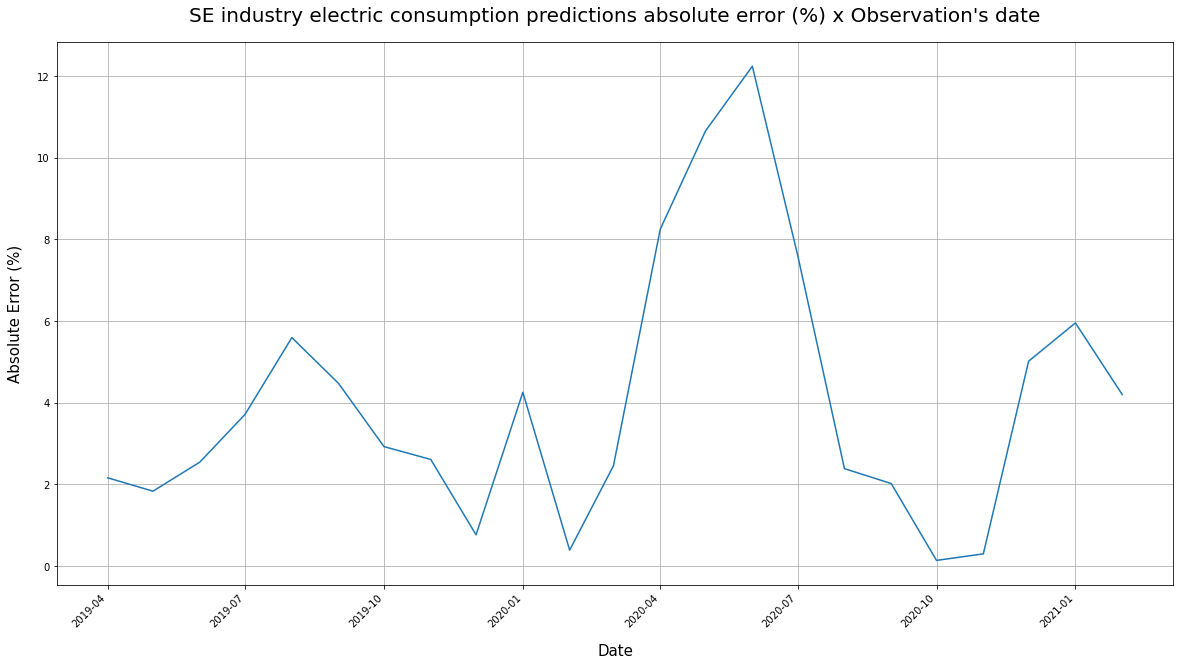

In [77]:
# training the 'rfr' model with the training datasets
rfr.fit(x_train, y_train)

# instantiating the 'y_pred' dataset as the predictions over the 'x_test' dataset 
y_pred = rfr.predict(x_test)

# creating the 'rfr_error_comparison' as an empty dataframe
rfr_error_comparison = pd.DataFrame()

# creating the 'real_ind_se' column in the 'rfr_error_comparison' dataframe as the real SE industry electric consumption values
rfr_error_comparison['real_ind_se'] = np.expm1(y_test)

# creating the 'predicted_ind_se' column in the 'rfr_error_comparison' dataframe as the predicted SE industry electric
#consumption values
rfr_error_comparison['predicted_ind_se'] = np.expm1(y_pred)

# creating the 'absolute_erro' column in the 'rfr_error_comparison' dataframe as the absolute error between the 'real_ind_se' 
# and 'predicted_ind_se' columns values
rfr_error_comparison['absolute_erro'] = (abs(rfr_error_comparison['real_ind_se'] - rfr_error_comparison['predicted_ind_se'])) / rfr_error_comparison['real_ind_se'] * 100

# creating the 'data' column in the 'rfr_error_comparison', by copying it from the 'x_test_time' dataframe
rfr_error_comparison['data'] = x_test_time['data']

# resetting the 'rfr_error_comparison' dataframe's index
rfr_error_comparison.reset_index(drop= True, inplace= True)
                                                                                        
# creating a figure
fig = plt.figure(figsize= (20,10))

# setting ax graph, title, labels, ticks and sizes
ax = sns.lineplot(x= rfr_error_comparison['data'], y= rfr_error_comparison['absolute_erro'])
ax.set_title("SE industry electric consumption predictions absolute error (%) x Observation's date", size= 20, pad= 20)
ax.set_ylabel("Absolute Error (%)", size= 15, labelpad= 15)
ax.set_xlabel("Date", size= 15, labelpad= 15)
ax.grid()

# rotating the x axis labels
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)
    
# saving the graph as 'rfr_absolute_error' in the storytelling folder  
plt.savefig('../storytelling/rfr_absolute_error.png')

***
**As seen above:**

There is a clearly peak between march 2020 and august 2020 and a smaller one between november 2020 and february 2021.

If we look for news about these two periods, the first matches with the first impact (first wave) of the COVID-19 pandemic in Brazil, and the second one matches with the second impact (second wave), when people started to be vaccinated and started behave without caution. 

So, probably thats why these two periods have a higher error than the others dates, the model couldn't identify (and never would) these COVID-19 impact over the economy and consequently over the industry electric consumption.

## <font color=green size= 5> <b>9.3 TRAINING AND REAL PREDICTIONS WITH THE WHOLE DATASET </font></b>
***

Now, as we saw when we applied the cross validation over the models, all of them kept their metrics stable when we changed the training and testing datasets cuts in the timeline.

Based on this, now we will consider all the initial dataset observations as the training array (01/2004 to 02/2021) and predict the next 22 months ( from 03/2021 to 12/2022) industry electric consumption for Brazil Southeast region.

For that, we will now work with the **'df_real_predictions_raw'** dataframe, that we created in section 2.5, as our testing dataset.

In [78]:
# loading all scaler methods for the selected numerical features
pop_ocup_scaler    = pickle.load(open('../parameters/pop_ocup_scaler.pkl', 'rb'))
pim_se_scaler      = pickle.load(open('../parameters/pim_se_scaler.pkl', 'rb'))
temp_min_se_scaler = pickle.load(open('../parameters/temp_min_se_scaler.pkl', 'rb'))
pmc_a_se_scaler    = pickle.load(open('../parameters/pmc_a_se_scaler.pkl', 'rb'))

# creating 'df_real_predictions' as an empty dataframe
df_real_predictions = pd.DataFrame()

# creating the 'data' column in the 'df_real_predictions' dataframe, by copying it from the 'df_real_predictions_raw' dataframe
df_real_predictions['data'] = df_real_predictions_raw['data']

# creating the 'pop_ocup' column in the 'df_real_predictions' dataframe, by copying and scaling the 'pop_ocup' column values of 
#'df_real_predictions_raw' dataframe
pop_ocup_list = [i[0] for i in pop_ocup_scaler.transform(df_real_predictions_raw[['pop_ocup']].values)]
df_real_predictions['pop_ocup'] = pop_ocup_list

# creating the 'pim_se' column in the 'df_real_predictions' dataframe, by copying and scaling the 'pim_se' column values of 
# 'df_real_predictions_raw' dataframe
pim_se_list = [i[0] for i in pim_se_scaler.transform(df_real_predictions_raw[['pim_se']].values)]
df_real_predictions['pim_se'] = pim_se_list

# creating the 'temp_min_se' column in the 'df_real_predictions' dataframe, by copying and scaling the 'temp_min_se' column values of 
# 'df_real_predictions_raw' dataframe
temp_min_se_list = [i[0] for i in temp_min_se_scaler.transform(df_real_predictions_raw[['temp_min_se']].values)]
df_real_predictions['temp_min_se'] = temp_min_se_list

# creating the 'pmc_a_se' column in the 'df_real_predictions' dataframe, by copying and scaling the 'pmc_a_se' column values of 
# 'df_real_predictions_raw' dataframe
pmc_a_se_list = [i[0] for i in pmc_a_se_scaler.transform(df_real_predictions_raw[['pmc_a_se']].values)]
df_real_predictions['pmc_a_se'] = pmc_a_se_list

# creating the 'ano' column in the 'df_real_predictions' dataframe, by copying and transforming the 'data' column values of 
# 'df_real_predictions_raw' dataframe
df_real_predictions['ano'] = df_real_predictions_raw['data'].dt.year

# creating the 'mes' column in the 'df_real_predictions' dataframe, by copying and transforming the 'data' column values of 
# 'df_real_predictions_raw' dataframe
df_real_predictions['mes'] = df_real_predictions_raw['data'].dt.month

# creating the 'mes_seno' column in the 'df_real_predictions' dataframe, by copying and transforming the 'mes' column values of 
# 'df_real_predictions' dataframe
df_real_predictions['mes_seno'] = df_real_predictions['mes'].apply(lambda x: np.sin(x *(2. * np.pi / 12)))

# removing the 'mes' column from the 'df_real_predictions' dataframe
df_real_predictions.drop(columns= ['mes'], inplace= True)

# displaying the 'df_real_predictions' dataframe with the selected and transformed features
print('\n Manipulated features projections for the next 22 months, to predict the Brazil Southeast industry electric consumption.')
display(df_real_predictions)

# creating the 'x_train_real' dataset as the final traning features dataset
x_train_real = df5.copy()[manual_selected_features]

# creating the 'y_train_real' dataset as the final traning label dataset
y_train_real = df5.copy()['ind_se']

# creating the 'x_test_real' dataset as the final traning features dataset, to predict the electric consumption
x_test_real = df_real_predictions.drop(columns= ['data'])

# instantiating the final model, Random Forest Regressor, as 'rfr_final'
rfr_final = RandomForestRegressor(n_estimators= 100, n_jobs= -1, random_state= 301)

# fitting the 'rfr_final' model with the final training datasets
rfr_final.fit(x_train_real, y_train_real)

# instantiating the 'y_pred_real' dataset as the predictions results over the 'x_test_real' dataset 
y_pred_real = rfr_final.predict(x_test_real)

# creating the 'ind_se' column in the 'df_real_predictions' with the final SE industry electric consumption values
df_real_predictions['ind_se'] = np.expm1(y_pred_real)

# displaying the 'df_real_predictions' dataframe with the selected and transformed features and the SE industry electric
# consumption predictions
print("\n Manipulated features projections and the Brazil Southeast industry electric consumption predictions for the next 22 months.")
display(df_real_predictions)


 Manipulated features projections for the next 22 months, to predict the Brazil Southeast industry electric consumption.


,data,pop_ocup,pim_se,temp_min_se,pmc_a_se,ano,mes_seno
0,2021-03-01,0.502980,0.433350,0.748480,0.706666,2021,1.000000e+00
1,2021-04-01,0.518677,0.426419,0.643595,0.598445,2021,8.660254e-01
2,2021-05-01,0.531673,0.558551,0.377247,0.610367,2021,5.000000e-01
3,2021-06-01,0.543523,0.541317,0.281330,0.583895,2021,1.224647e-16
4,2021-07-01,0.557632,0.620450,0.198535,0.602917,2021,-5.000000e-01
5,2021-08-01,0.579814,0.687675,0.230699,0.626769,2021,-8.660254e-01
6,2021-09-01,0.605108,0.605662,0.460416,0.564164,2021,-1.000000e+00
7,2021-10-01,0.633600,0.646347,0.616894,0.604394,2021,-8.660254e-01
8,2021-11-01,0.643819,0.504209,0.633562,0.648397,2021,-5.000000e-01
9,2021-12-01,0.628792,0.285880,0.765803,0.833179,2021,-2.449294e-16



 Manipulated features projections and the Brazil Southeast industry electric consumption predictions for the next 22 months.


,data,pop_ocup,pim_se,temp_min_se,pmc_a_se,ano,mes_seno,ind_se
0,2021-03-01,0.502980,0.433350,0.748480,0.706666,2021,1.000000e+00,7750.920620
1,2021-04-01,0.518677,0.426419,0.643595,0.598445,2021,8.660254e-01,7883.328776
2,2021-05-01,0.531673,0.558551,0.377247,0.610367,2021,5.000000e-01,7687.911713
3,2021-06-01,0.543523,0.541317,0.281330,0.583895,2021,1.224647e-16,7728.261850
4,2021-07-01,0.557632,0.620450,0.198535,0.602917,2021,-5.000000e-01,7943.313035
5,2021-08-01,0.579814,0.687675,0.230699,0.626769,2021,-8.660254e-01,8072.033833
6,2021-09-01,0.605108,0.605662,0.460416,0.564164,2021,-1.000000e+00,7833.572510
7,2021-10-01,0.633600,0.646347,0.616894,0.604394,2021,-8.660254e-01,8094.234870
8,2021-11-01,0.643819,0.504209,0.633562,0.648397,2021,-5.000000e-01,8043.425393
9,2021-12-01,0.628792,0.285880,0.765803,0.833179,2021,-2.449294e-16,7187.424328


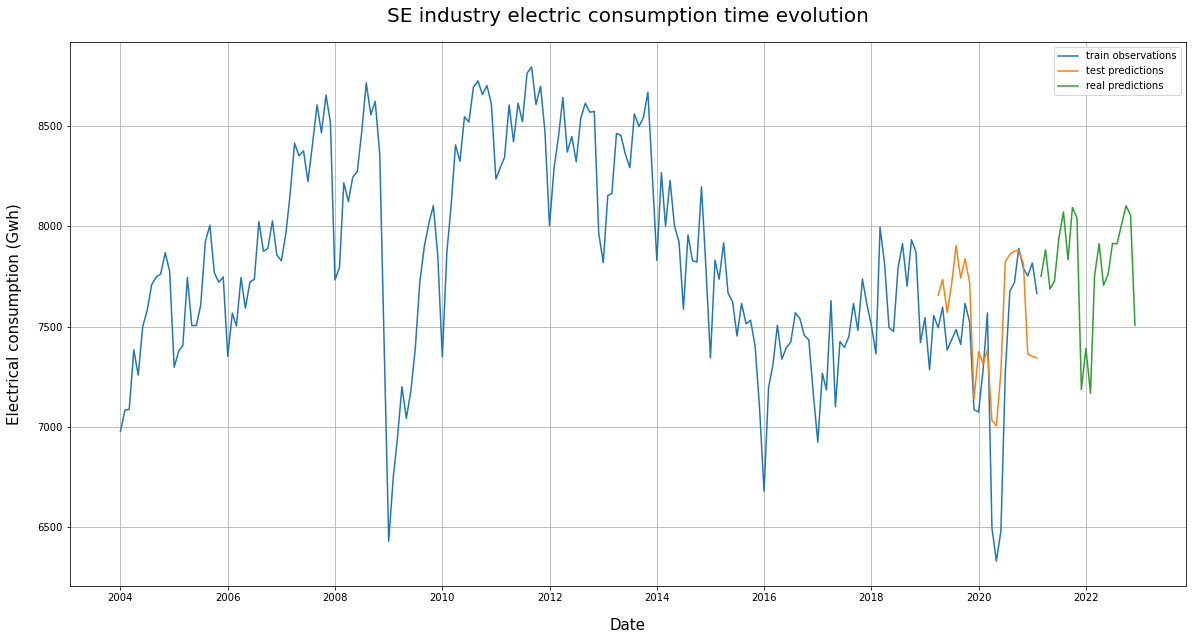

In [79]:
# creating a figure
fig, ax = plt.subplots(1, 1, figsize=(20,10))

# setting ax graph, title, labels, ticks and sizes
sns.lineplot(ax= ax, x= df5['data'], y= np.expm1(df5['ind_se']))
sns.lineplot(ax= ax, x= rfr_error_comparison['data'], y= rfr_error_comparison['predicted_ind_se'])
sns.lineplot(ax= ax, x= df_real_predictions['data'], y= df_real_predictions['ind_se'])
ax.set_title("SE industry electric consumption time evolution", size= 20, pad= 20)
ax.set_ylabel("Electrical consumption (Gwh)", size= 15, labelpad= 15)
ax.set_xlabel("Date", size= 15, labelpad= 15)
ax.legend(labels=['train observations', 'test predictions', 'real predictions'])
ax.grid()
    
# saving the graph as 'SE_consumption_evolution' in the storytelling folder  
plt.savefig('../storytelling/SE_consumption_evolution.png')

Something to discuss later is that if using the 04/2019 to 02/2021 dates as part of the training dataset to predict the next 22 months electric consumptions is fits good.

That's because this period of time will bring a high biased information, because of the COVID-19 impact, as the 2008 to 2010 period brought as well.

## <font color=green size= 5> <b>9.4 CHECKPOINT </font></b>
***

In [80]:
# saving the 'rfr_final' model
pickle.dump(rfr_final, open('../models/rfr_final.pkl', 'wb'))

In [81]:
# loading the 'rfr_final' model
rfr_final = pickle.load(open('../models/rfr_final.pkl', 'rb'))

# <font color=green size= 6> <b>10. DEPLOY </font></b>
***

In this section we will deploy the model to production on Heroku, a cloud plataform.

We will create an API with flask framework and a python file to manipulate the dataset imputed features.

With this, We can use request methods to imput some data to the model in production 24/7, respecting the features and their values obviously, and retrieve the Brazil southeast region's industry electric consumption predictions, in Gwh.

## <font color=green size= 5>10.1 DATA CLASS MANIPULATION</font>
***

In [ ]:
import pandas            as pd
import numpy             as np
import pickle
import json


class Electrical_Consumption (object):

    def __init__(self):

        # loading the scaler methods for the selected numerical features
        self.pop_ocup_scaler    = pickle.load(open('parameters/pop_ocup_scaler.pkl', 'rb'))
        self.pim_se_scaler      = pickle.load(open('parameters/pim_se_scaler.pkl', 'rb'))
        self.temp_min_se_scaler = pickle.load(open('parameters/temp_min_se_scaler.pkl', 'rb'))
        self.pmc_a_se_scaler    = pickle.load(open('parameters/pmc_a_se_scaler.pkl', 'rb'))
        self.manual_selected_features = pickle.load(open('parameters/manual_selected_features.pkl', 'rb'))

        
    def features_engineering(self, df):

        ''' creating and transforming the dataframes's features '''

        # modifying the 'data' column, because it came as a string type
        df['data'] = df['data'].astype('datetime64[ns]')
        
        # creating the 'ano' column in the 'df' dataframe
        df['ano'] = df['data'].dt.year

        # creating the 'mes' column in the 'df' dataframe
        df['mes'] = df['data'].dt.month

        # creating the 'mes_seno' column in the 'df' dataframe
        df['mes_seno'] = df['mes'].apply(lambda x: np.sin(x *(2. * np.pi / 12)))

        # removing the 'mes' column from the 'df' dataframe
        df.drop(columns= ['mes'], inplace= True)
        
        # modifying the 'data' column as a string type again, so we can send it through the API request
        df['data'] = df['data'].astype('str')
                
        return df
    

    def data_preparation(self, df):

        ''' rescaling the dataframe's numerical features '''
       
        # transforming the 'pop_ocup' column in the 'df' dataframe, with its imported scaler method
        pop_ocup_list = [i[0] for i in self.pop_ocup_scaler.transform(df[['pop_ocup']].values)]
        df['pop_ocup'] = pop_ocup_list

        # transforming the 'pim_se' column in the 'df' dataframe, with its imported scaler method
        pim_se_list = [i[0] for i in self.pim_se_scaler.transform(df[['pim_se']].values)]
        df['pim_se'] = pim_se_list

        # transforming the 'temp_min_se' column in the 'df' dataframe, with its imported scaler method
        temp_min_se_list = [i[0] for i in self.temp_min_se_scaler.transform(df[['temp_min_se']].values)]
        df['temp_min_se'] = temp_min_se_list

       # transforming the 'pmc_a_se' column in the 'df' dataframe, with its imported scaler method
        pmc_a_se_list = [i[0] for i in self.pmc_a_se_scaler.transform(df[['pmc_a_se']].values)]
        df['pmc_a_se'] = pmc_a_se_list

        return df
    

    def get_predict(self, model, df):

        ''' Filtering the features that will be used to predict the electrical consumption '''
        
        # instantiating the 'selected_features' list, with only the selected features names
        selected_features = self.manual_selected_features
        
        # filtering the 'df' dataframe with only the 'selected_features' and saving it as 'df_copy' dataframe
        df_copy = df.copy()[selected_features]

        # creating the 'ind_se' column with the final SE industry electric consumption predicted values
        df_copy['ind_se'] =  np.expm1(model.predict(df_copy))
        
        # creating the 'data' column, by copying it from the 'df' dataframe
        df_copy['data'] = df['data']
    
        return df_copy[['data', 'ind_se']].to_json(orient= 'records')

## <font color=green size= 5>10.2 API </font>
***

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from classes.electrical_consumption import Electrical_Consumption
import os

# loading model trained from pickle file
with open('models/rfr_final.pkl', 'rb') as file:
    model = pickle.load(file)

# initializing API
app = Flask(__name__)


@app.route('/predict', methods= ['POST'])
def electrical_consumption_prediction():
    
    test_json = request.get_json()

    if test_json:

        # unique observation
        if isinstance(test_json, dict):            
            test_raw = pd.DataFrame(test_json, index=[0])

        # multiple observations
        else:  # multiple Example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

            
        # instantiating EC class
        pipeline = Electrical_Consumption()

        # manipulating features
        test_raw_features = pipeline.features_engineering(test_raw)

        # rescaling and encoding features to predict
        test_raw_prepared = pipeline.data_preparation(test_raw_features)

        # predicting
        df_response = pipeline.get_predict(model, test_raw_prepared)

        return df_response

    else:

        return Response("{}", status= 200, mimetype= 'application/json')


if __name__ == '__main__':
    port = os.environ.get('PORT', 5000)
    app.run(host='0.0.0.0', port=port)

## <font color=green size= 5>10.3 API TESTER </font>
***

Dataframe with the next 22 months Brazil southeast industry electric consumption predictions (Gwh).


,data,ind_se
0,2021-03-01,7681.016822
1,2021-04-01,7644.701664
2,2021-05-01,7381.847526
3,2021-06-01,7457.148262
4,2021-07-01,7671.334166
5,2021-08-01,7747.979393
6,2021-09-01,7485.723797
7,2021-10-01,7707.227376
8,2021-11-01,7723.005944
9,2021-12-01,7170.327572


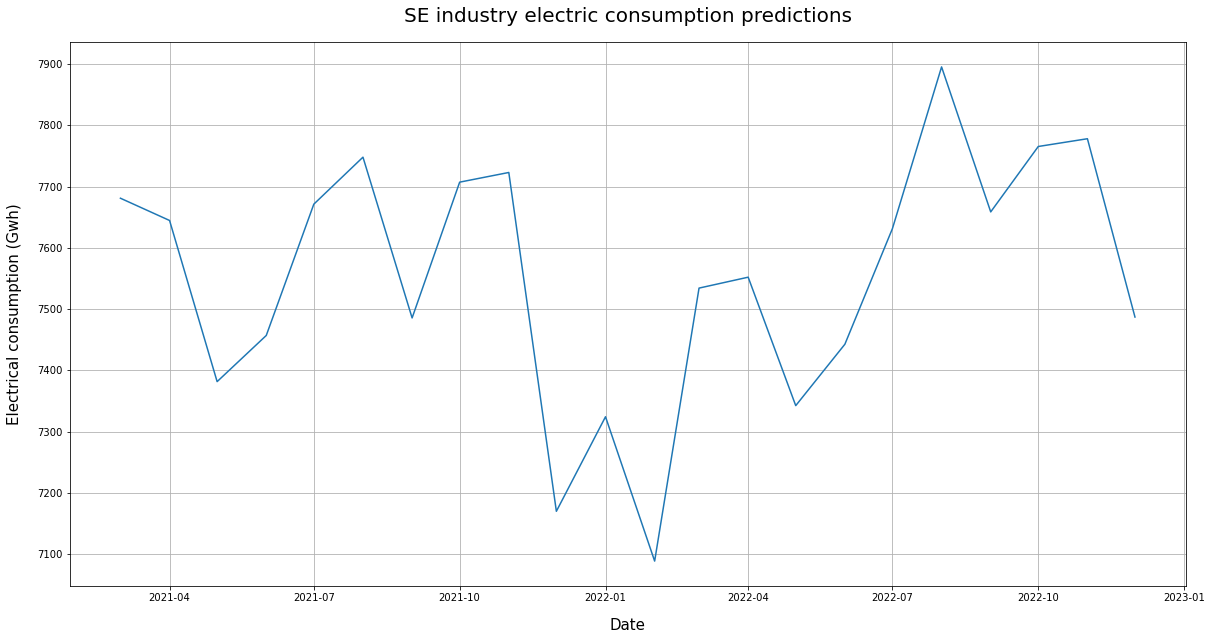

In [82]:
# creating the 'get_predictions' function
def get_predictions(dataframe):
    
    # setting url to post the data
    url = 'https://ph-4intelligence.herokuapp.com/predict'

    # setting the content type
    header = {'Content-type': 'application/json'} 

    # creating the 'df_api' dataframe as a copy of the imputed 'dataframe' dataframe
    df_api = dataframe.copy()

    # changing the 'data' column type to string in the 'df_api', so we can send via API request
    df_api['data'] = df_api['data'].astype('str')

    # setting data as a json format of the 'df_api' dataframe
    data = df_api.to_dict(orient = 'records')

    # sending a request to API
    r = requests.post(url= url, json= data)

    # collecting the API response and transforming it into a 'df' dataframe
    df = pd.DataFrame(r.json(), columns = r.json()[0].keys())

    # changing the 'data' column type to datetime64 again in the 'df' dataframe
    df['data'] = df['data'].astype('datetime64[ns]')

    # printing the 'df' dataframe informations
    print('Dataframe with the next 22 months Brazil southeast industry electric consumption predictions (Gwh).')
    
    # creating a figure
    fig, ax = plt.subplots(1, 1, figsize=(20,10))

    # setting ax graph, title, labels, ticks and sizes
    sns.lineplot(ax= ax, x= df['data'], y= df['ind_se'])
    ax.set_title("SE industry electric consumption predictions", size= 20, pad= 20)
    ax.set_ylabel("Electrical consumption (Gwh)", size= 15, labelpad= 15)
    ax.set_xlabel("Date", size= 15, labelpad= 15)
    ax.grid()

    return df

# applying the 'df_test_raw' dataframe (the one with the next 22 months projections) into the 'get_predictions' function
get_predictions(df_real_predictions_raw)